In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2022/Especialidad Prueba A.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 8 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=145.6, y1=139.9
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 388
Page 1, Q1, A: Yellow percentage: 0.0%


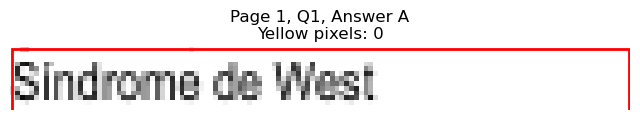

Page 1, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=113.9, y1=152.6
Page 1, Q1, B: Yellow pixels: 96
Page 1, Q1, B: Total non-white pixels: 336
Page 1, Q1, B: Yellow percentage: 28.6%


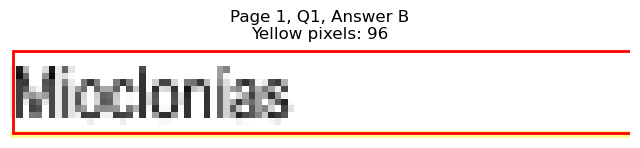

Page 1, Q1 - C: Detected box: x0=68.8, y0=152.5, x1=176.5, y1=165.2
Page 1, Q1, C: Yellow pixels: 1630
Page 1, Q1, C: Total non-white pixels: 2226
Page 1, Q1, C: Yellow percentage: 73.2%


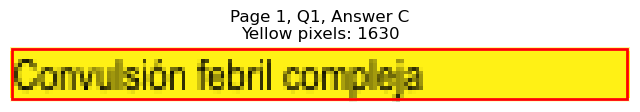

Page 1, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=425.3, y1=139.9
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 516
Page 1, Q1, D: Yellow percentage: 0.0%


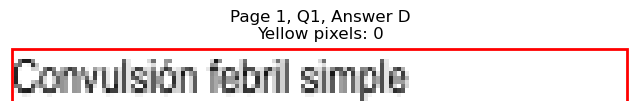

Page 1, Q1 - E: Detected box: x0=327.0, y0=139.9, x1=366.2, y1=152.6
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 231
Page 1, Q1, E: Yellow percentage: 0.0%


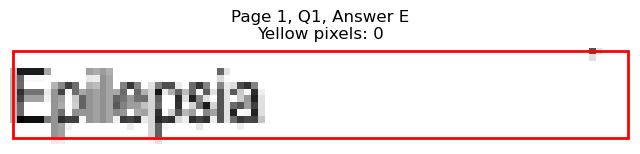


Page 1, Q1 - Selected Answer: C (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=159.6, y1=215.6
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 465
Page 1, Q2, A: Yellow percentage: 0.0%


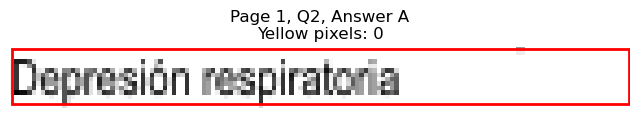

Page 1, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=143.5, y1=228.3
Page 1, Q2, B: Yellow pixels: 126
Page 1, Q2, B: Total non-white pixels: 514
Page 1, Q2, B: Yellow percentage: 24.5%


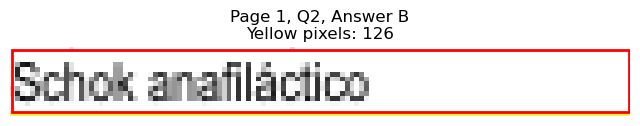

Page 1, Q2 - C: Detected box: x0=68.8, y0=228.3, x1=167.1, y1=240.9
Page 1, Q2, C: Yellow pixels: 1558
Page 1, Q2, C: Total non-white pixels: 1950
Page 1, Q2, C: Yellow percentage: 79.9%


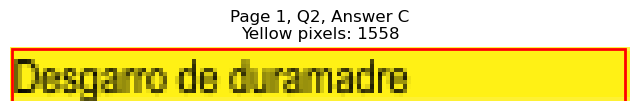

Page 1, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=391.7, y1=215.6
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 333
Page 1, Q2, D: Yellow percentage: 0.0%


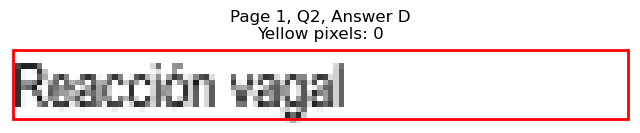

Page 1, Q2 - E: Detected box: x0=327.0, y0=215.7, x1=459.8, y1=228.3
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 628
Page 1, Q2, E: Yellow percentage: 0.0%


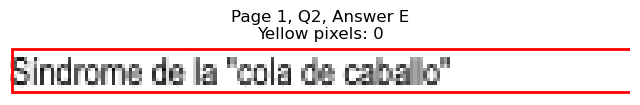


Page 1, Q2 - Selected Answer: C (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=304.0, x1=137.5, y1=316.7
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 362
Page 1, Q3, A: Yellow percentage: 0.0%


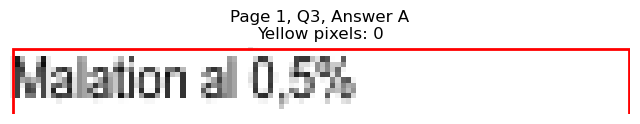

Page 1, Q3 - B: Detected box: x0=68.3, y0=316.6, x1=115.0, y1=329.3
Page 1, Q3, B: Yellow pixels: 97
Page 1, Q3, B: Total non-white pixels: 309
Page 1, Q3, B: Yellow percentage: 31.4%


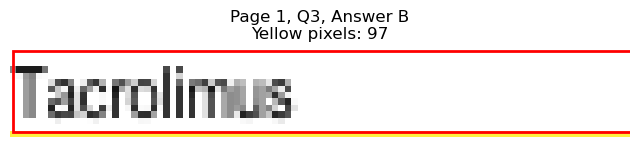

Page 1, Q3 - C: Detected box: x0=68.8, y0=329.2, x1=118.0, y1=341.9
Page 1, Q3, C: Yellow pixels: 1103
Page 1, Q3, C: Total non-white pixels: 1300
Page 1, Q3, C: Yellow percentage: 84.8%


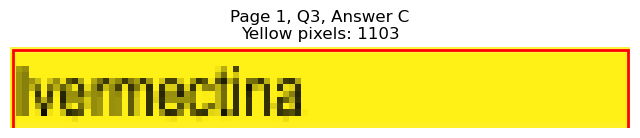

Page 1, Q3 - D: Detected box: x0=327.5, y0=304.0, x1=388.4, y1=316.7
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 274
Page 1, Q3, D: Yellow percentage: 0.0%


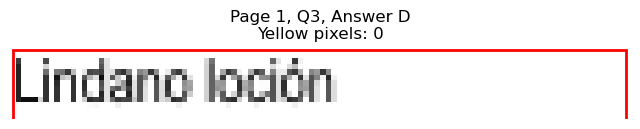

Page 1, Q3 - E: Detected box: x0=327.0, y0=316.6, x1=364.1, y1=329.3
Page 1, Q3, E: Yellow pixels: 0
Page 1, Q3, E: Total non-white pixels: 193
Page 1, Q3, E: Yellow percentage: 0.0%


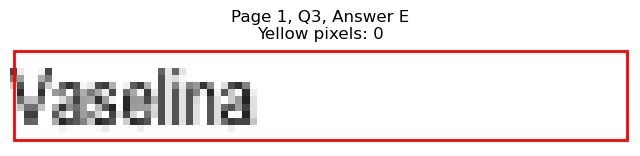


Page 1, Q3 - Selected Answer: C (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=367.1, x1=182.2, y1=379.8
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 562
Page 1, Q4, A: Yellow percentage: 0.0%


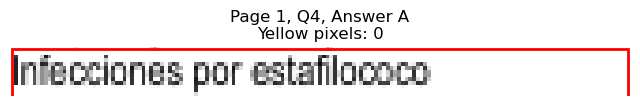

Page 1, Q4 - B: Detected box: x0=68.3, y0=379.7, x1=110.9, y1=392.4
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 220
Page 1, Q4, B: Yellow percentage: 0.0%


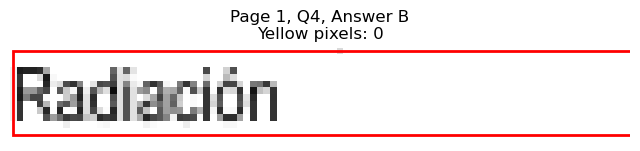

Page 1, Q4 - C: Detected box: x0=68.8, y0=392.3, x1=132.0, y1=405.0
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 336
Page 1, Q4, C: Yellow percentage: 0.0%


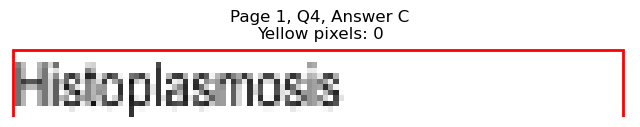

Page 1, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=388.3, y1=379.8
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 400
Page 1, Q4, D: Yellow percentage: 0.0%


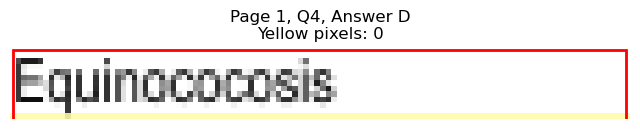

Page 1, Q4 - E: Detected box: x0=327.0, y0=379.7, x1=413.3, y1=392.4
Page 1, Q4, E: Yellow pixels: 1303
Page 1, Q4, E: Total non-white pixels: 1918
Page 1, Q4, E: Yellow percentage: 67.9%


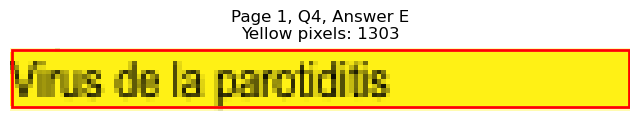


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=442.8, x1=183.1, y1=455.5
Page 1, Q5, A: Yellow pixels: 1705
Page 1, Q5, A: Total non-white pixels: 2324
Page 1, Q5, A: Yellow percentage: 73.4%


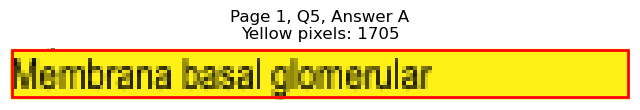

Page 1, Q5 - B: Detected box: x0=68.3, y0=455.5, x1=153.0, y1=468.1
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 454
Page 1, Q5, B: Yellow percentage: 0.0%


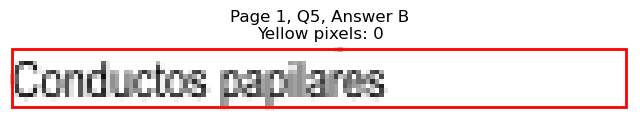

Page 1, Q5 - C: Detected box: x0=68.8, y0=468.1, x1=150.0, y1=480.7
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 393
Page 1, Q5, C: Yellow percentage: 0.0%


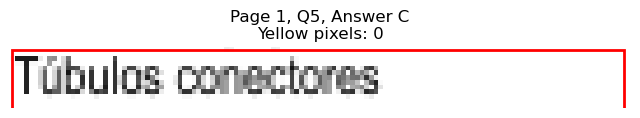

Page 1, Q5 - D: Detected box: x0=327.5, y0=442.8, x1=457.4, y1=455.5
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 654
Page 1, Q5, D: Yellow percentage: 0.0%


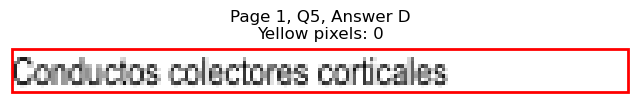

Page 1, Q5 - E: Detected box: x0=327.0, y0=455.5, x1=487.1, y1=468.1
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 830
Page 1, Q5, E: Yellow percentage: 0.0%


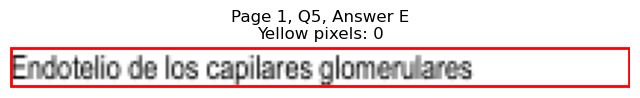


Page 1, Q5 - Selected Answer: A (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=531.2, x1=165.1, y1=543.8
Page 1, Q6, A: Yellow pixels: 1537
Page 1, Q6, A: Total non-white pixels: 1924
Page 1, Q6, A: Yellow percentage: 79.9%


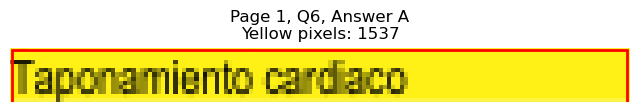

Page 1, Q6 - B: Detected box: x0=68.3, y0=543.8, x1=144.0, y1=556.4
Page 1, Q6, B: Yellow pixels: 126
Page 1, Q6, B: Total non-white pixels: 506
Page 1, Q6, B: Yellow percentage: 24.9%


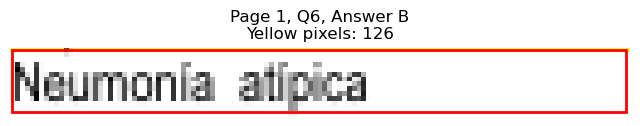

Page 1, Q6 - C: Detected box: x0=68.8, y0=556.5, x1=184.1, y1=569.2
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 572
Page 1, Q6, C: Yellow percentage: 0.0%


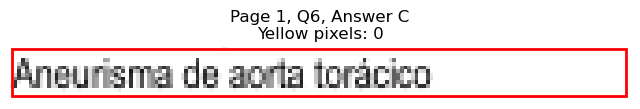

Page 1, Q6 - D: Detected box: x0=327.5, y0=531.2, x1=423.3, y1=543.8
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 524
Page 1, Q6, D: Yellow percentage: 0.0%


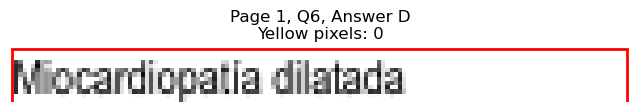

Page 1, Q6 - E: Detected box: x0=327.0, y0=543.8, x1=450.9, y1=556.4
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 631
Page 1, Q6, E: Yellow percentage: 0.0%


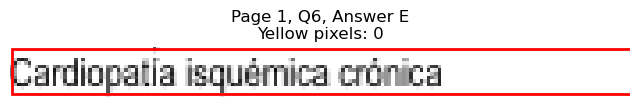


Page 1, Q6 - Selected Answer: A (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=606.9, x1=199.7, y1=619.6
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 657
Page 1, Q7, A: Yellow percentage: 0.0%


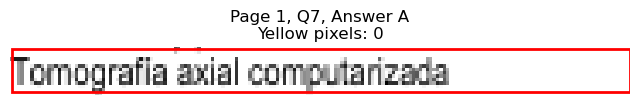

Page 1, Q7 - B: Detected box: x0=68.3, y0=619.6, x1=242.3, y1=632.3
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 919
Page 1, Q7, B: Yellow percentage: 0.0%


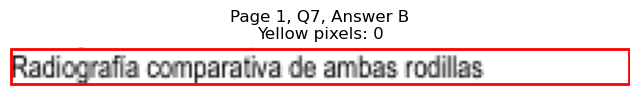

Page 1, Q7 - C: Detected box: x0=68.8, y0=632.2, x1=184.1, y1=644.9
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 585
Page 1, Q7, C: Yellow percentage: 0.0%


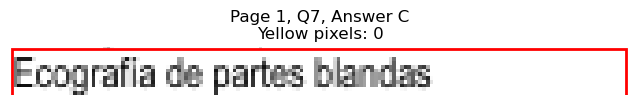

Page 1, Q7 - D: Detected box: x0=327.5, y0=606.9, x1=408.3, y1=619.6
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 427
Page 1, Q7, D: Yellow percentage: 0.0%


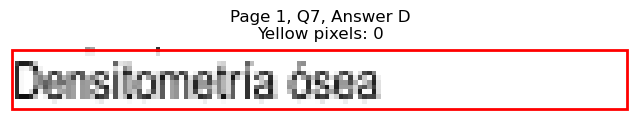

Page 1, Q7 - E: Detected box: x0=327.0, y0=619.6, x1=375.7, y1=632.3
Page 1, Q7, E: Yellow pixels: 991
Page 1, Q7, E: Total non-white pixels: 1386
Page 1, Q7, E: Yellow percentage: 71.5%


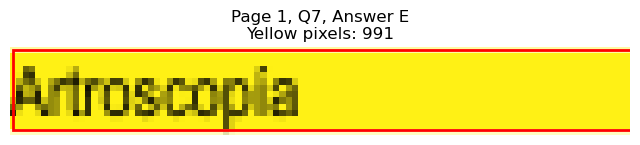


Page 1, Q7 - Selected Answer: E (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=695.4, x1=162.6, y1=708.0
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 489
Page 1, Q8, A: Yellow percentage: 0.0%


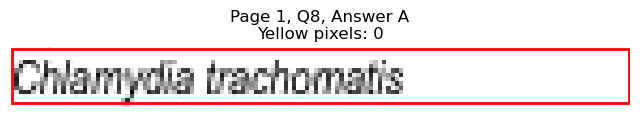

Page 1, Q8 - B: Detected box: x0=68.3, y0=708.0, x1=161.5, y1=720.6
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 473
Page 1, Q8, B: Yellow percentage: 0.0%


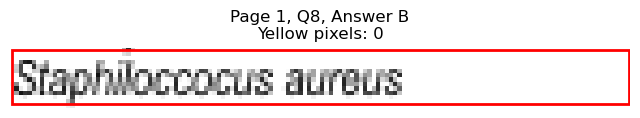

Page 1, Q8 - C: Detected box: x0=68.8, y0=720.6, x1=167.5, y1=733.2
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 502
Page 1, Q8, C: Yellow percentage: 0.0%


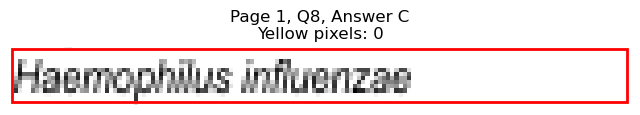

Page 1, Q8 - D: Detected box: x0=327.5, y0=695.4, x1=421.4, y1=708.0
Page 1, Q8, D: Yellow pixels: 1488
Page 1, Q8, D: Total non-white pixels: 1888
Page 1, Q8, D: Yellow percentage: 78.8%


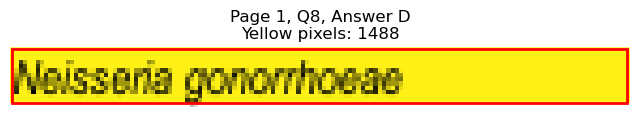

Page 1, Q8 - E: Detected box: x0=327.0, y0=708.0, x1=427.5, y1=720.6
Page 1, Q8, E: Yellow pixels: 147
Page 1, Q8, E: Total non-white pixels: 669
Page 1, Q8, E: Yellow percentage: 22.0%


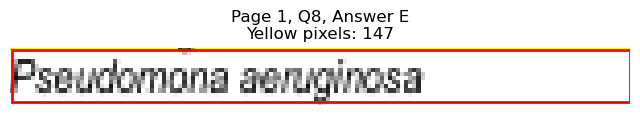


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)





Page 2: Found 8 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=124.5, y1=102.1
Page 2, Q1, A: Yellow pixels: 1162
Page 2, Q1, A: Total non-white pixels: 1498
Page 2, Q1, A: Yellow percentage: 77.6%


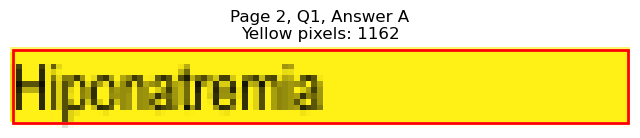

Page 2, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=152.5, y1=114.7
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 562
Page 2, Q1, B: Yellow percentage: 0.0%


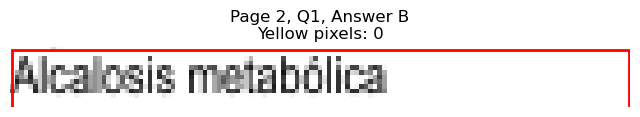

Page 2, Q1 - C: Detected box: x0=68.8, y0=114.6, x1=125.4, y1=127.3
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 303
Page 2, Q1, C: Yellow percentage: 0.0%


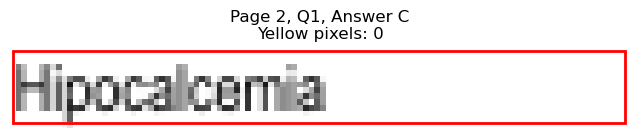

Page 2, Q1 - D: Detected box: x0=327.5, y0=89.4, x1=379.7, y1=102.1
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 289
Page 2, Q1, D: Yellow percentage: 0.0%


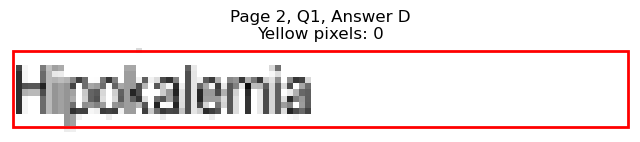

Page 2, Q1 - E: Detected box: x0=327.0, y0=102.0, x1=384.2, y1=114.7
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 313
Page 2, Q1, E: Yellow percentage: 0.0%


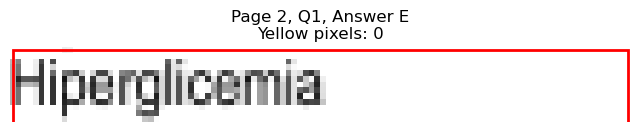


Page 2, Q1 - Selected Answer: A (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=152.5, x1=88.8, y1=165.2
Page 2, Q2, A: Yellow pixels: 71
Page 2, Q2, A: Total non-white pixels: 155
Page 2, Q2, A: Yellow percentage: 45.8%


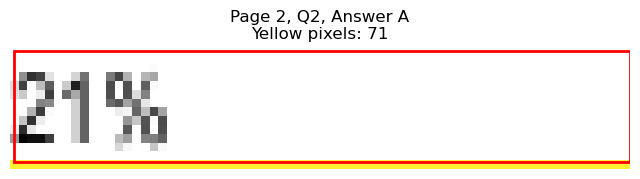

Page 2, Q2 - B: Detected box: x0=68.3, y0=165.1, x1=93.9, y1=177.8
Page 2, Q2, B: Yellow pixels: 894
Page 2, Q2, B: Total non-white pixels: 988
Page 2, Q2, B: Yellow percentage: 90.5%


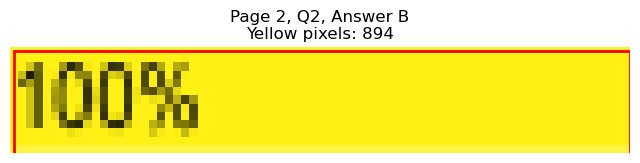

Page 2, Q2 - C: Detected box: x0=68.8, y0=177.7, x1=89.3, y1=190.4
Page 2, Q2, C: Yellow pixels: 72
Page 2, Q2, C: Total non-white pixels: 180
Page 2, Q2, C: Yellow percentage: 40.0%


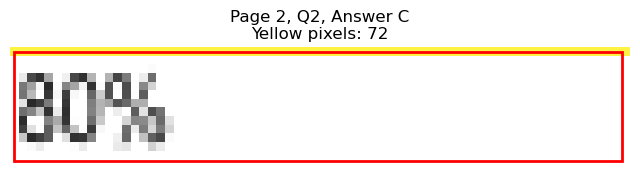

Page 2, Q2 - D: Detected box: x0=327.5, y0=152.5, x1=348.1, y1=165.2
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 100
Page 2, Q2, D: Yellow percentage: 0.0%


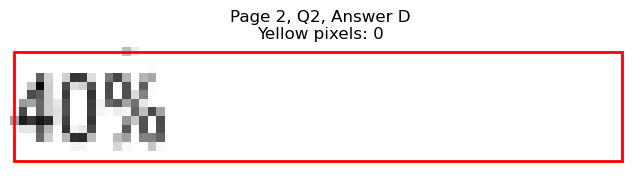

Page 2, Q2 - E: Detected box: x0=327.0, y0=165.1, x1=347.6, y1=177.8
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 113
Page 2, Q2, E: Yellow percentage: 0.0%


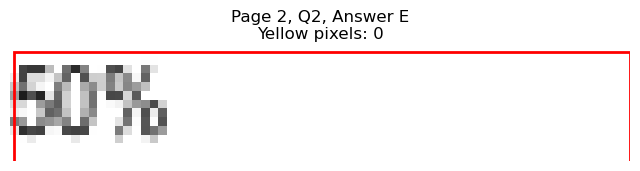


Page 2, Q2 - Selected Answer: B (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=240.9, x1=143.5, y1=253.5
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 371
Page 2, Q3, A: Yellow percentage: 0.0%


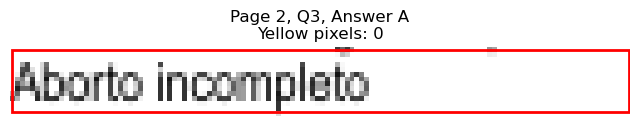

Page 2, Q3 - B: Detected box: x0=68.3, y0=253.5, x1=199.7, y1=266.1
Page 2, Q3, B: Yellow pixels: 182
Page 2, Q3, B: Total non-white pixels: 856
Page 2, Q3, B: Yellow percentage: 21.3%


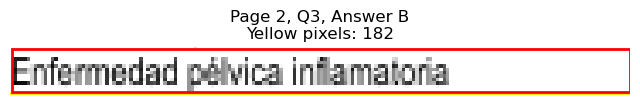

Page 2, Q3 - C: Detected box: x0=68.8, y0=266.1, x1=196.7, y1=278.7
Page 2, Q3, C: Yellow pixels: 1851
Page 2, Q3, C: Total non-white pixels: 2327
Page 2, Q3, C: Yellow percentage: 79.5%


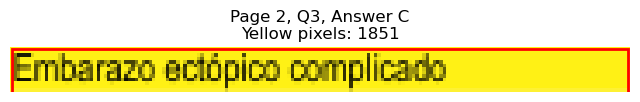

Page 2, Q3 - D: Detected box: x0=327.5, y0=240.9, x1=422.3, y1=253.5
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 498
Page 2, Q3, D: Yellow percentage: 0.0%


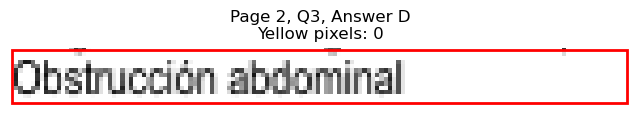

Page 2, Q3 - E: Detected box: x0=327.0, y0=253.5, x1=373.3, y1=266.1
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 257
Page 2, Q3, E: Yellow percentage: 0.0%


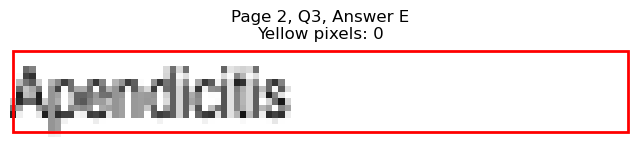


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=121.0, y1=341.9
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 232
Page 2, Q4, A: Yellow percentage: 0.0%


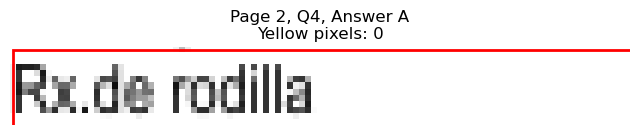

Page 2, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=118.5, y1=354.6
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 245
Page 2, Q4, B: Yellow percentage: 0.0%


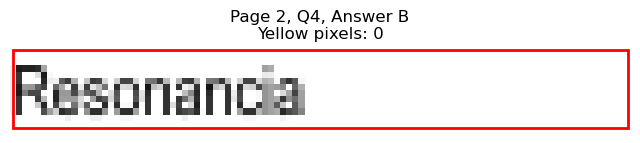

Page 2, Q4 - C: Detected box: x0=68.8, y0=354.5, x1=117.4, y1=367.2
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 250
Page 2, Q4, C: Yellow percentage: 0.0%


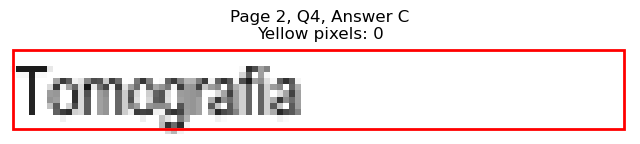

Page 2, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=406.7, y1=341.9
Page 2, Q4, D: Yellow pixels: 1369
Page 2, Q4, D: Total non-white pixels: 1690
Page 2, Q4, D: Yellow percentage: 81.0%


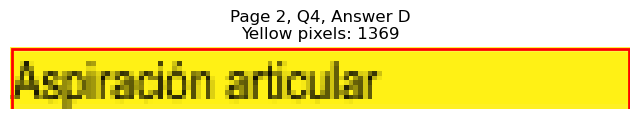

Page 2, Q4 - E: Detected box: x0=327.0, y0=341.9, x1=371.7, y1=354.6
Page 2, Q4, E: Yellow pixels: 93
Page 2, Q4, E: Total non-white pixels: 322
Page 2, Q4, E: Yellow percentage: 28.9%


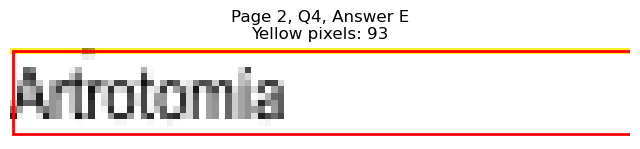


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=159.0, y1=417.6
Page 2, Q5, A: Yellow pixels: 1488
Page 2, Q5, A: Total non-white pixels: 1988
Page 2, Q5, A: Yellow percentage: 74.8%


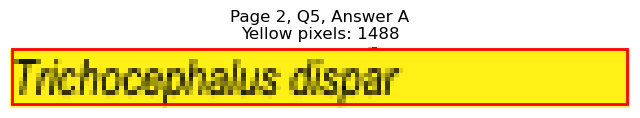

Page 2, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=130.9, y1=430.3
Page 2, Q5, B: Yellow pixels: 113
Page 2, Q5, B: Total non-white pixels: 429
Page 2, Q5, B: Yellow percentage: 26.3%


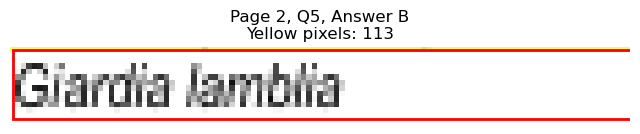

Page 2, Q5 - C: Detected box: x0=68.8, y0=430.2, x1=169.6, y1=442.9
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 526
Page 2, Q5, C: Yellow percentage: 0.0%


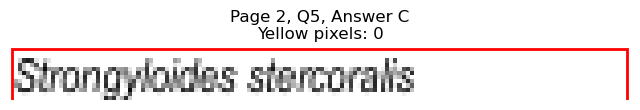

Page 2, Q5 - D: Detected box: x0=327.5, y0=417.6, x1=412.7, y1=430.3
Page 2, Q5, D: Yellow pixels: 136
Page 2, Q5, D: Total non-white pixels: 565
Page 2, Q5, D: Yellow percentage: 24.1%


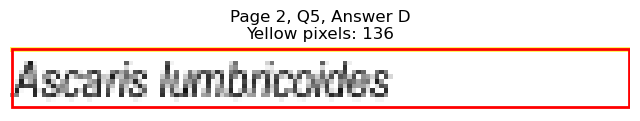

Page 2, Q5 - E: Detected box: x0=327.0, y0=430.2, x1=425.8, y1=442.9
Page 2, Q5, E: Yellow pixels: 0
Page 2, Q5, E: Total non-white pixels: 502
Page 2, Q5, E: Yellow percentage: 0.0%


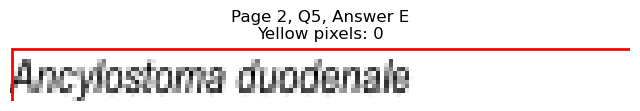


Page 2, Q5 - Selected Answer: A (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=493.4, x1=100.3, y1=506.0
Page 2, Q6, A: Yellow pixels: 934
Page 2, Q6, A: Total non-white pixels: 1079
Page 2, Q6, A: Yellow percentage: 86.6%


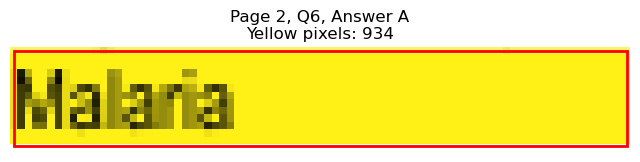

Page 2, Q6 - B: Detected box: x0=68.3, y0=506.0, x1=130.5, y1=518.6
Page 2, Q6, B: Yellow pixels: 113
Page 2, Q6, B: Total non-white pixels: 429
Page 2, Q6, B: Yellow percentage: 26.3%


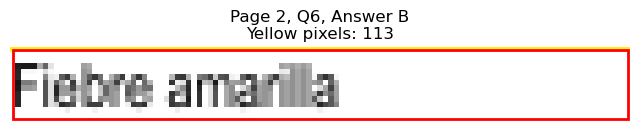

Page 2, Q6 - C: Detected box: x0=68.8, y0=518.6, x1=88.3, y1=531.2
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 99
Page 2, Q6, C: Yellow percentage: 0.0%


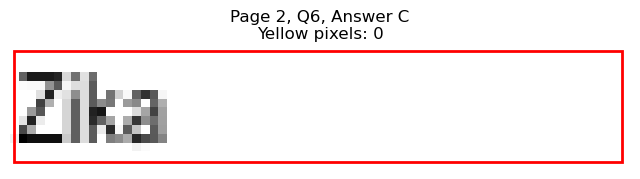

Page 2, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=382.7, y1=506.0
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 287
Page 2, Q6, D: Yellow percentage: 0.0%


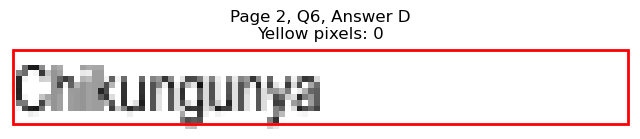

Page 2, Q6 - E: Detected box: x0=327.0, y0=506.0, x1=361.1, y1=518.6
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 179
Page 2, Q6, E: Yellow percentage: 0.0%


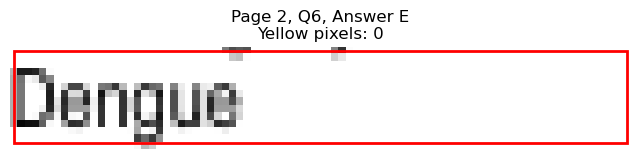


Page 2, Q6 - Selected Answer: A (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=569.1, x1=216.9, y1=581.8
Page 2, Q7, A: Yellow pixels: 2017
Page 2, Q7, A: Total non-white pixels: 2587
Page 2, Q7, A: Yellow percentage: 78.0%


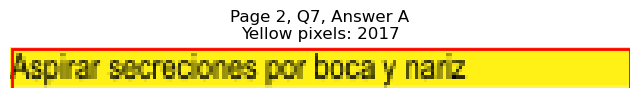

Page 2, Q7 - B: Detected box: x0=68.3, y0=581.7, x1=223.8, y1=594.4
Page 2, Q7, B: Yellow pixels: 205
Page 2, Q7, B: Total non-white pixels: 997
Page 2, Q7, B: Yellow percentage: 20.6%


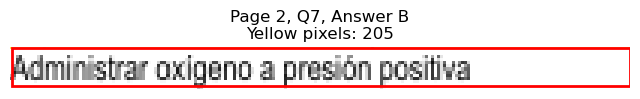

Page 2, Q7 - C: Detected box: x0=68.8, y0=594.3, x1=208.2, y1=607.0
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 688
Page 2, Q7, C: Yellow percentage: 0.0%


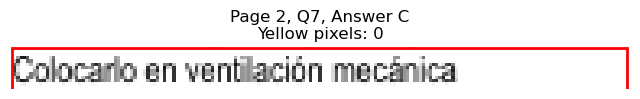

Page 2, Q7 - D: Detected box: x0=327.5, y0=569.1, x1=541.2, y1=581.8
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 1052
Page 2, Q7, D: Yellow percentage: 0.0%


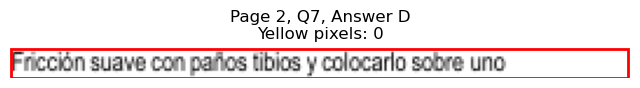

Page 2, Q7 - E: Detected box: x0=327.0, y0=594.3, x1=455.9, y1=607.0
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 629
Page 2, Q7, E: Yellow percentage: 0.0%


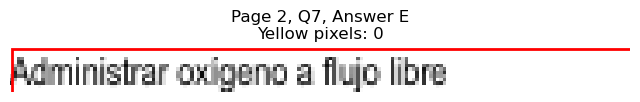


Page 2, Q7 - Selected Answer: A (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=657.5, x1=224.3, y1=670.1
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 756
Page 2, Q8, A: Yellow percentage: 0.0%


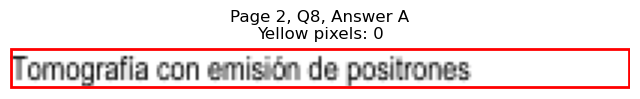

Page 2, Q8 - B: Detected box: x0=68.3, y0=670.1, x1=170.7, y1=682.7
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 498
Page 2, Q8, B: Yellow percentage: 0.0%


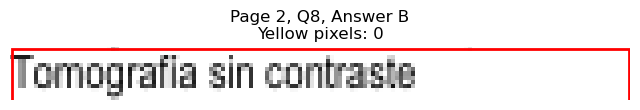

Page 2, Q8 - C: Detected box: x0=68.8, y0=682.7, x1=142.0, y1=695.3
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 366
Page 2, Q8, C: Yellow percentage: 0.0%


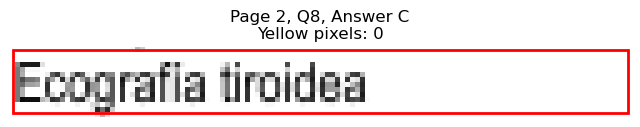

Page 2, Q8 - D: Detected box: x0=327.5, y0=657.5, x1=442.4, y1=670.1
Page 2, Q8, D: Yellow pixels: 1747
Page 2, Q8, D: Total non-white pixels: 2324
Page 2, Q8, D: Yellow percentage: 75.2%


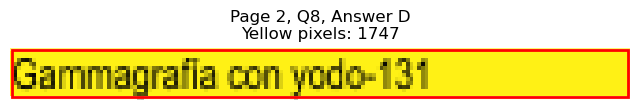

Page 2, Q8 - E: Detected box: x0=327.0, y0=670.1, x1=421.4, y1=682.7
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 655
Page 2, Q8, E: Yellow percentage: 0.0%


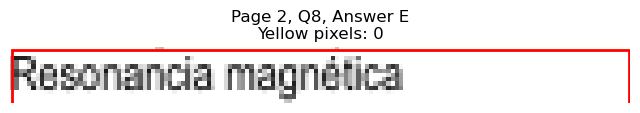


Page 2, Q8 - Selected Answer: D (based on yellow pixel count)





Page 3: Found 7 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=142.6, y1=127.3
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 363
Page 3, Q1, A: Yellow percentage: 0.0%


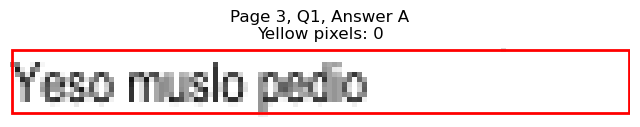

Page 3, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=141.0, y1=139.9
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 379
Page 3, Q1, B: Yellow percentage: 0.0%


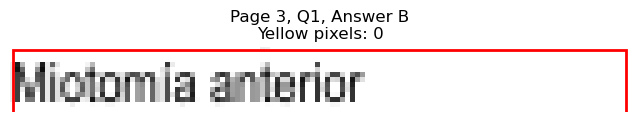

Page 3, Q1 - C: Detected box: x0=68.8, y0=139.9, x1=149.5, y1=152.6
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 423
Page 3, Q1, C: Yellow percentage: 0.0%


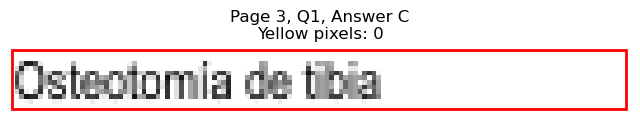

Page 3, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=393.8, y1=127.3
Page 3, Q1, D: Yellow pixels: 117
Page 3, Q1, D: Total non-white pixels: 461
Page 3, Q1, D: Yellow percentage: 25.4%


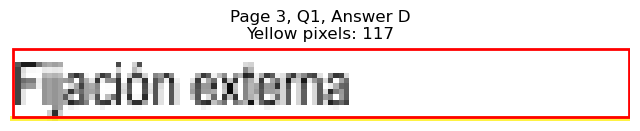

Page 3, Q1 - E: Detected box: x0=327.0, y0=127.2, x1=378.7, y1=139.9
Page 3, Q1, E: Yellow pixels: 1120
Page 3, Q1, E: Total non-white pixels: 1326
Page 3, Q1, E: Yellow percentage: 84.5%


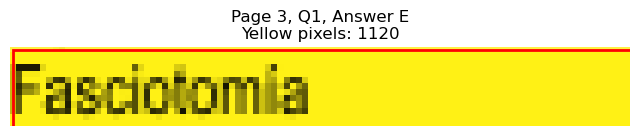


Page 3, Q1 - Selected Answer: E (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=119.9, y1=203.0
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 286
Page 3, Q2, A: Yellow percentage: 0.0%


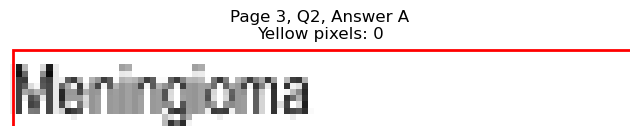

Page 3, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=198.7, y1=215.6
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 644
Page 3, Q2, B: Yellow percentage: 0.0%


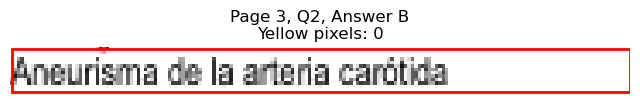

Page 3, Q2 - C: Detected box: x0=68.8, y0=215.7, x1=170.1, y1=228.3
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 511
Page 3, Q2, C: Yellow percentage: 0.0%


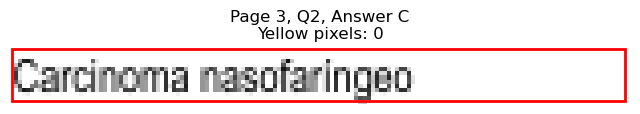

Page 3, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=436.4, y1=203.0
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 704
Page 3, Q2, D: Yellow percentage: 0.0%


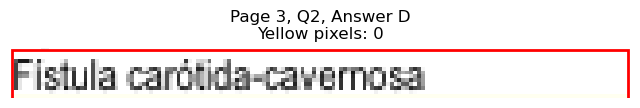

Page 3, Q2 - E: Detected box: x0=327.0, y0=202.9, x1=452.5, y1=215.6
Page 3, Q2, E: Yellow pixels: 1849
Page 3, Q2, E: Total non-white pixels: 2464
Page 3, Q2, E: Yellow percentage: 75.0%


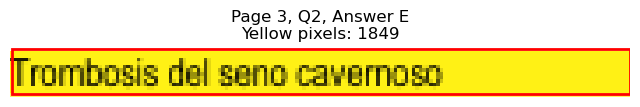


Page 3, Q2 - Selected Answer: E (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=235.2, y1=278.7
Page 3, Q3, A: Yellow pixels: 2106
Page 3, Q3, A: Total non-white pixels: 2782
Page 3, Q3, A: Yellow percentage: 75.7%


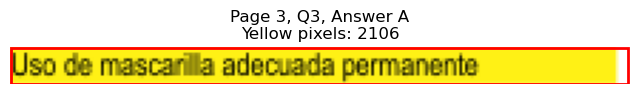

Page 3, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=156.0, y1=291.5
Page 3, Q3, B: Yellow pixels: 139
Page 3, Q3, B: Total non-white pixels: 563
Page 3, Q3, B: Yellow percentage: 24.7%


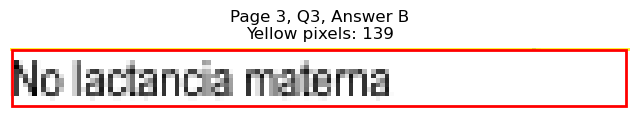

Page 3, Q3 - C: Detected box: x0=68.8, y0=291.4, x1=192.6, y1=304.1
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 618
Page 3, Q3, C: Yellow percentage: 0.0%


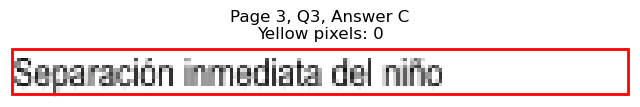

Page 3, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=454.5, y1=278.7
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 664
Page 3, Q3, D: Yellow percentage: 0.0%


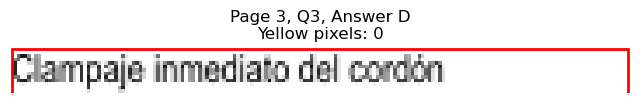

Page 3, Q3 - E: Detected box: x0=327.0, y0=278.8, x1=363.8, y1=291.5
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 194
Page 3, Q3, E: Yellow percentage: 0.0%


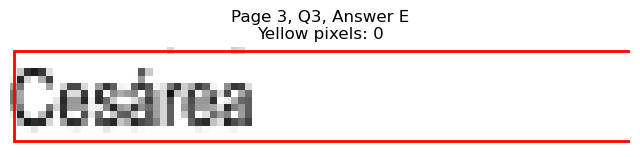


Page 3, Q3 - Selected Answer: A (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=367.1, x1=102.9, y1=379.8
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 176
Page 3, Q4, A: Yellow percentage: 0.0%


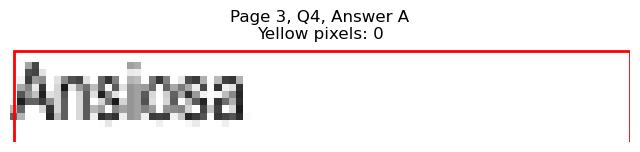

Page 3, Q4 - B: Detected box: x0=68.3, y0=379.7, x1=110.4, y1=392.4
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 236
Page 3, Q4, B: Yellow percentage: 0.0%


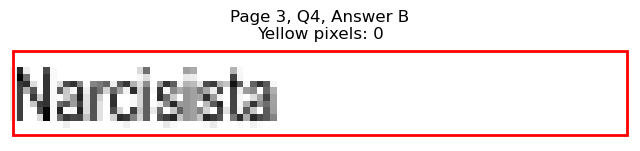

Page 3, Q4 - C: Detected box: x0=68.8, y0=392.3, x1=112.5, y1=405.0
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 228
Page 3, Q4, C: Yellow percentage: 0.0%


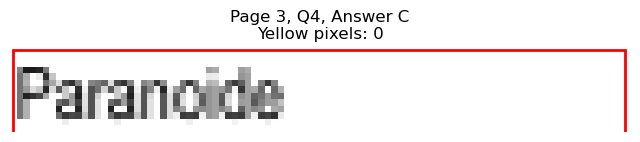

Page 3, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=364.1, y1=379.8
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 283
Page 3, Q4, D: Yellow percentage: 0.0%


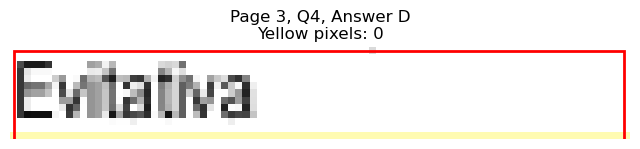

Page 3, Q4 - E: Detected box: x0=327.0, y0=379.7, x1=373.7, y1=392.4
Page 3, Q4, E: Yellow pixels: 977
Page 3, Q4, E: Total non-white pixels: 1358
Page 3, Q4, E: Yellow percentage: 71.9%


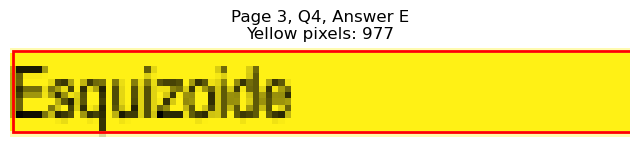


Page 3, Q4 - Selected Answer: E (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=442.8, x1=160.1, y1=455.5
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 425
Page 3, Q5, A: Yellow percentage: 0.0%


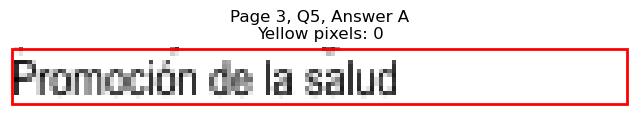

Page 3, Q5 - B: Detected box: x0=68.3, y0=455.5, x1=109.5, y1=468.1
Page 3, Q5, B: Yellow pixels: 92
Page 3, Q5, B: Total non-white pixels: 298
Page 3, Q5, B: Yellow percentage: 30.9%


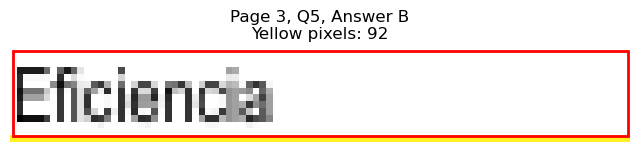

Page 3, Q5 - C: Detected box: x0=68.8, y0=468.1, x1=153.5, y1=480.7
Page 3, Q5, C: Yellow pixels: 1429
Page 3, Q5, C: Total non-white pixels: 1768
Page 3, Q5, C: Yellow percentage: 80.8%


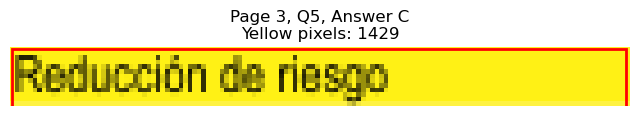

Page 3, Q5 - D: Detected box: x0=327.5, y0=442.8, x1=363.2, y1=455.5
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 177
Page 3, Q5, D: Yellow percentage: 0.0%


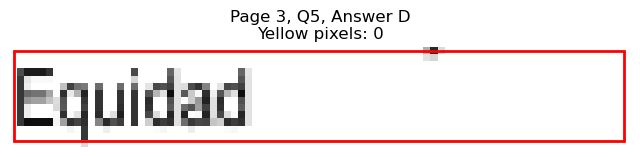

Page 3, Q5 - E: Detected box: x0=327.0, y0=455.5, x1=373.7, y1=468.1
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 257
Page 3, Q5, E: Yellow percentage: 0.0%


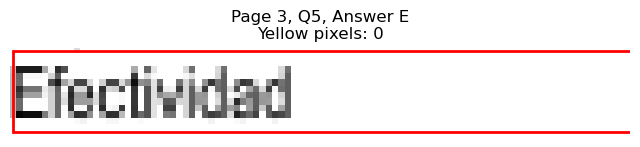


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=543.8, x1=205.1, y1=556.4
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 674
Page 3, Q6, A: Yellow percentage: 0.0%


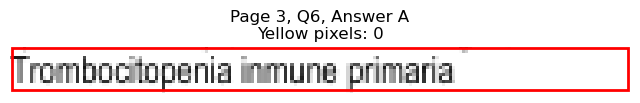

Page 3, Q6 - B: Detected box: x0=68.3, y0=556.5, x1=185.2, y1=569.2
Page 3, Q6, B: Yellow pixels: 168
Page 3, Q6, B: Total non-white pixels: 745
Page 3, Q6, B: Yellow percentage: 22.6%


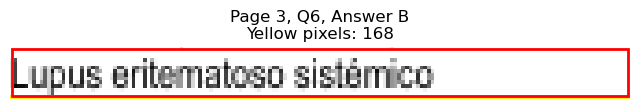

Page 3, Q6 - C: Detected box: x0=68.8, y0=569.1, x1=189.1, y1=581.8
Page 3, Q6, C: Yellow pixels: 1766
Page 3, Q6, C: Total non-white pixels: 2236
Page 3, Q6, C: Yellow percentage: 79.0%


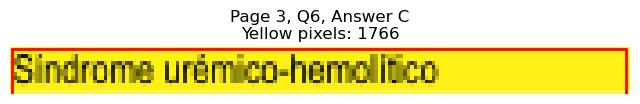

Page 3, Q6 - D: Detected box: x0=327.5, y0=543.8, x1=368.2, y1=556.4
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 223
Page 3, Q6, D: Yellow percentage: 0.0%


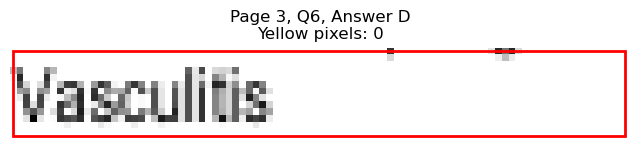

Page 3, Q6 - E: Detected box: x0=327.0, y0=556.5, x1=429.4, y1=569.2
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 529
Page 3, Q6, E: Yellow percentage: 0.0%


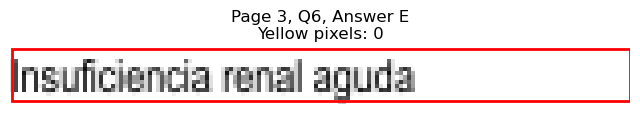


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=657.5, x1=154.1, y1=670.1
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 417
Page 3, Q7, A: Yellow percentage: 0.0%


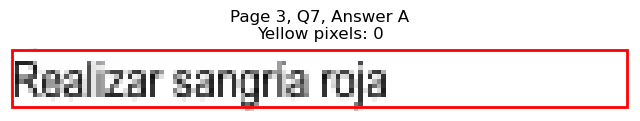

Page 3, Q7 - B: Detected box: x0=68.3, y0=670.1, x1=158.1, y1=682.7
Page 3, Q7, B: Yellow pixels: 2
Page 3, Q7, B: Total non-white pixels: 598
Page 3, Q7, B: Yellow percentage: 0.3%


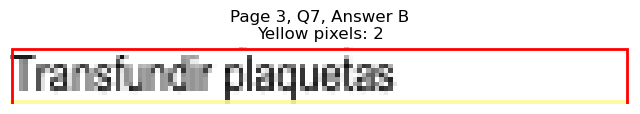

Page 3, Q7 - C: Detected box: x0=68.8, y0=682.7, x1=195.7, y1=695.3
Page 3, Q7, C: Yellow pixels: 1604
Page 3, Q7, C: Total non-white pixels: 2492
Page 3, Q7, C: Yellow percentage: 64.4%


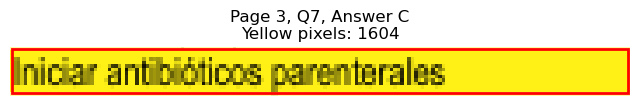

Page 3, Q7 - D: Detected box: x0=327.5, y0=657.5, x1=450.9, y1=670.1
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 628
Page 3, Q7, D: Yellow percentage: 0.0%


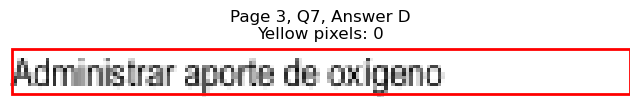

Page 3, Q7 - E: Detected box: x0=327.0, y0=670.1, x1=480.6, y1=682.7
Page 3, Q7, E: Yellow pixels: 0
Page 3, Q7, E: Total non-white pixels: 781
Page 3, Q7, E: Yellow percentage: 0.0%


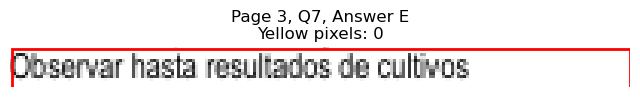


Page 3, Q7 - Selected Answer: C (based on yellow pixel count)





Page 4: Found 8 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=104.9, y1=139.9
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 201
Page 4, Q1, A: Yellow percentage: 0.0%


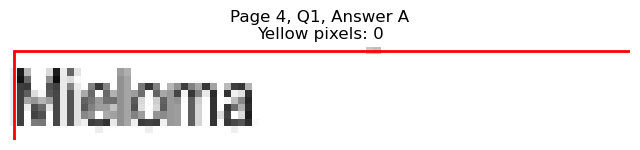

Page 4, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=102.9, y1=152.6
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 165
Page 4, Q1, B: Yellow percentage: 0.0%


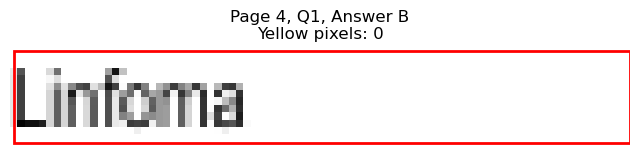

Page 4, Q1 - C: Detected box: x0=68.8, y0=152.5, x1=178.1, y1=165.2
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 553
Page 4, Q1, C: Yellow percentage: 0.0%


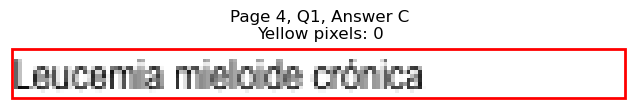

Page 4, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=433.9, y1=139.9
Page 4, Q1, D: Yellow pixels: 1642
Page 4, Q1, D: Total non-white pixels: 2041
Page 4, Q1, D: Yellow percentage: 80.5%


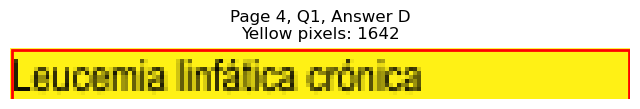

Page 4, Q1 - E: Detected box: x0=327.0, y0=139.9, x1=432.4, y1=152.6
Page 4, Q1, E: Yellow pixels: 156
Page 4, Q1, E: Total non-white pixels: 701
Page 4, Q1, E: Yellow percentage: 22.3%


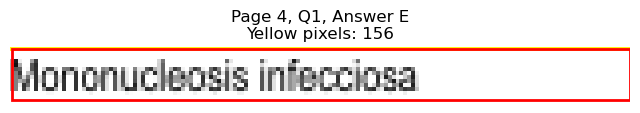


Page 4, Q1 - Selected Answer: D (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=137.5, y1=203.0
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 315
Page 4, Q2, A: Yellow percentage: 0.0%


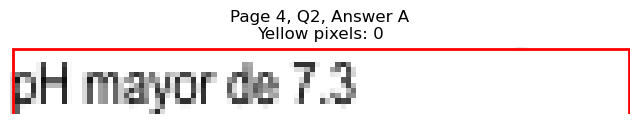

Page 4, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=187.2, y1=215.6
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 613
Page 4, Q2, B: Yellow percentage: 0.0%


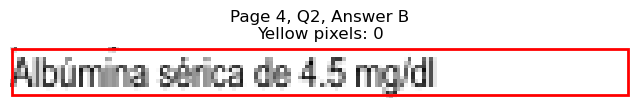

Page 4, Q2 - C: Detected box: x0=68.8, y0=215.7, x1=254.9, y1=228.3
Page 4, Q2, C: Yellow pixels: 1819
Page 4, Q2, C: Total non-white pixels: 2996
Page 4, Q2, C: Yellow percentage: 60.7%


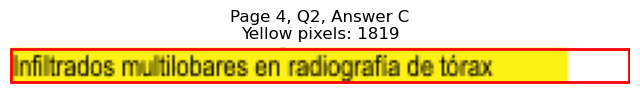

Page 4, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=453.4, y1=203.0
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 634
Page 4, Q2, D: Yellow percentage: 0.0%


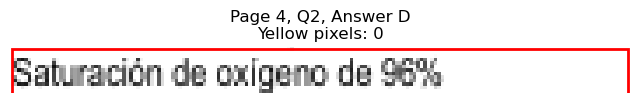

Page 4, Q2 - E: Detected box: x0=327.0, y0=202.9, x1=433.9, y1=215.6
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 542
Page 4, Q2, E: Yellow percentage: 0.0%


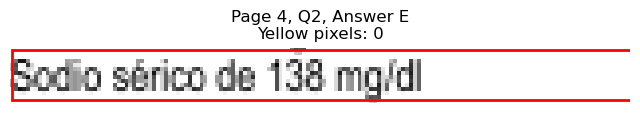


Page 4, Q2 - Selected Answer: C (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=120.5, y1=278.7
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 283
Page 4, Q3, A: Yellow percentage: 0.0%


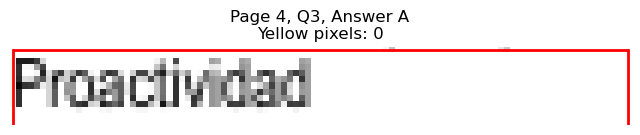

Page 4, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=115.0, y1=291.5
Page 4, Q3, B: Yellow pixels: 1083
Page 4, Q3, B: Total non-white pixels: 1358
Page 4, Q3, B: Yellow percentage: 79.7%


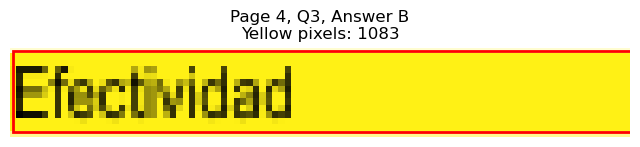

Page 4, Q3 - C: Detected box: x0=68.8, y0=291.4, x1=109.9, y1=304.1
Page 4, Q3, C: Yellow pixels: 92
Page 4, Q3, C: Total non-white pixels: 303
Page 4, Q3, C: Yellow percentage: 30.4%


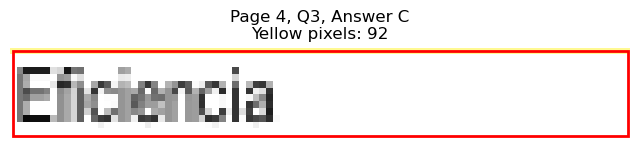

Page 4, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=368.7, y1=278.7
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 208
Page 4, Q3, D: Yellow percentage: 0.0%


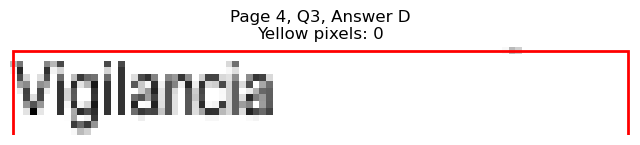

Page 4, Q3 - E: Detected box: x0=327.0, y0=278.8, x1=362.7, y1=291.5
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 202
Page 4, Q3, E: Yellow percentage: 0.0%


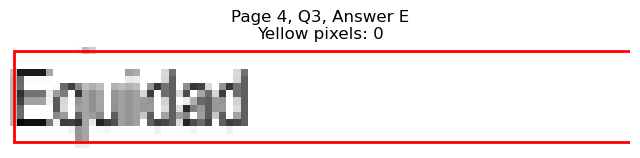


Page 4, Q3 - Selected Answer: B (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=367.1, x1=112.9, y1=379.8
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 235
Page 4, Q4, A: Yellow percentage: 0.0%


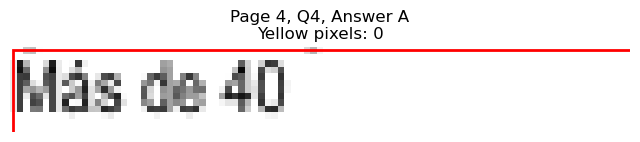

Page 4, Q4 - B: Detected box: x0=68.3, y0=379.7, x1=91.3, y1=392.4
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 89
Page 4, Q4, B: Yellow percentage: 0.0%


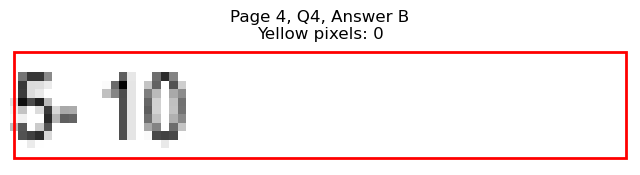

Page 4, Q4 - C: Detected box: x0=68.8, y0=392.3, x1=118.5, y1=405.0
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 233
Page 4, Q4, C: Yellow percentage: 0.0%


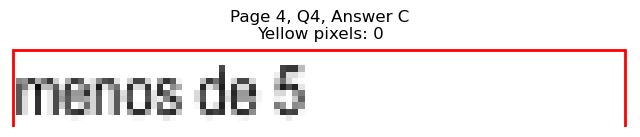

Page 4, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=353.1, y1=379.8
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 205
Page 4, Q4, D: Yellow percentage: 0.0%


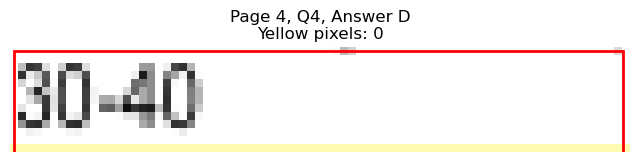

Page 4, Q4 - E: Detected box: x0=327.0, y0=379.7, x1=355.1, y1=392.4
Page 4, Q4, E: Yellow pixels: 850
Page 4, Q4, E: Total non-white pixels: 1106
Page 4, Q4, E: Yellow percentage: 76.9%


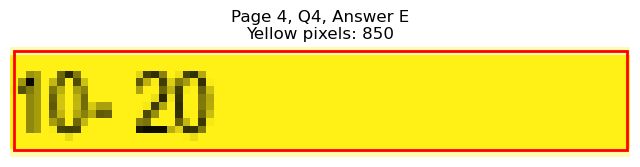


Page 4, Q4 - Selected Answer: E (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=442.8, x1=129.0, y1=455.5
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 317
Page 4, Q5, A: Yellow percentage: 0.0%


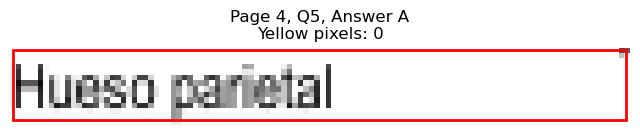

Page 4, Q5 - B: Detected box: x0=68.3, y0=455.5, x1=146.1, y1=468.1
Page 4, Q5, B: Yellow pixels: 129
Page 4, Q5, B: Total non-white pixels: 503
Page 4, Q5, B: Yellow percentage: 25.6%


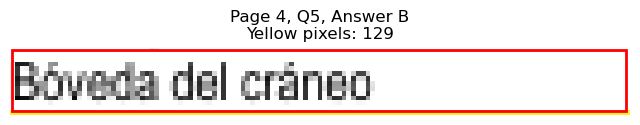

Page 4, Q5 - C: Detected box: x0=68.8, y0=468.1, x1=136.5, y1=480.7
Page 4, Q5, C: Yellow pixels: 1262
Page 4, Q5, C: Total non-white pixels: 1547
Page 4, Q5, C: Yellow percentage: 81.6%


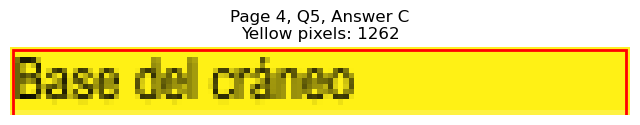

Page 4, Q5 - D: Detected box: x0=327.5, y0=442.8, x1=393.8, y1=455.5
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 351
Page 4, Q5, D: Yellow percentage: 0.0%


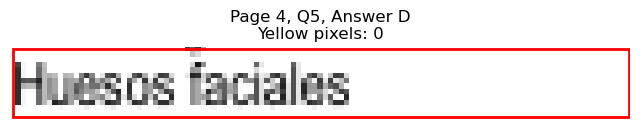

Page 4, Q5 - E: Detected box: x0=327.0, y0=455.5, x1=393.4, y1=468.1
Page 4, Q5, E: Yellow pixels: 0
Page 4, Q5, E: Total non-white pixels: 334
Page 4, Q5, E: Yellow percentage: 0.0%


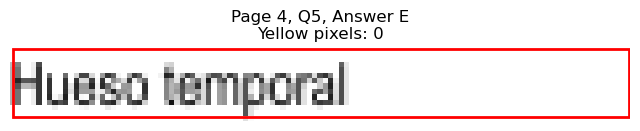


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=531.2, x1=115.5, y1=543.8
Page 4, Q6, A: Yellow pixels: 1088
Page 4, Q6, A: Total non-white pixels: 1274
Page 4, Q6, A: Yellow percentage: 85.4%


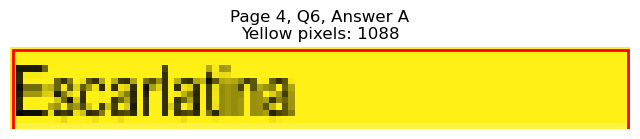

Page 4, Q6 - B: Detected box: x0=68.3, y0=543.8, x1=144.5, y1=556.4
Page 4, Q6, B: Yellow pixels: 127
Page 4, Q6, B: Total non-white pixels: 513
Page 4, Q6, B: Yellow percentage: 24.8%


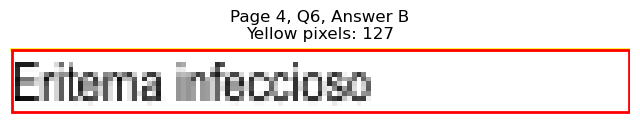

Page 4, Q6 - C: Detected box: x0=68.8, y0=556.5, x1=109.9, y1=569.2
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 211
Page 4, Q6, C: Yellow percentage: 0.0%


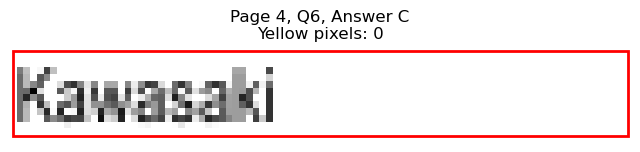

Page 4, Q6 - D: Detected box: x0=327.5, y0=531.2, x1=373.7, y1=543.8
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 231
Page 4, Q6, D: Yellow percentage: 0.0%


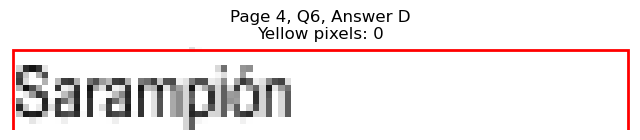

Page 4, Q6 - E: Detected box: x0=327.0, y0=139.9, x1=389.7, y1=152.6
Page 4, Q6, E: Yellow pixels: 113
Page 4, Q6, E: Total non-white pixels: 658
Page 4, Q6, E: Yellow percentage: 17.2%


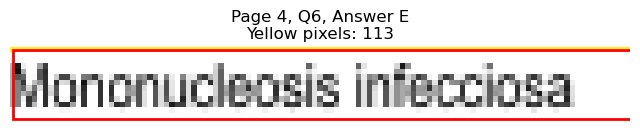


Page 4, Q6 - Selected Answer: A (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=619.6, x1=198.3, y1=632.3
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 691
Page 4, Q7, A: Yellow percentage: 0.0%


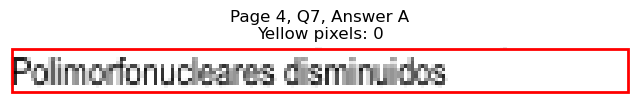

Page 4, Q7 - B: Detected box: x0=68.3, y0=632.2, x1=143.1, y1=644.9
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 339
Page 4, Q7, B: Yellow percentage: 0.0%


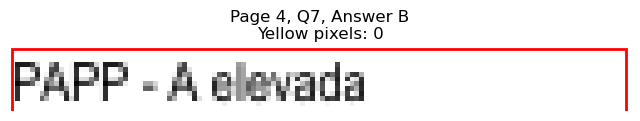

Page 4, Q7 - C: Detected box: x0=68.8, y0=644.9, x1=158.5, y1=657.5
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 439
Page 4, Q7, C: Yellow percentage: 0.0%


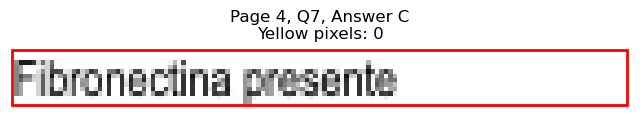

Page 4, Q7 - D: Detected box: x0=327.5, y0=619.6, x1=404.8, y1=632.3
Page 4, Q7, D: Yellow pixels: 128
Page 4, Q7, D: Total non-white pixels: 491
Page 4, Q7, D: Yellow percentage: 26.1%


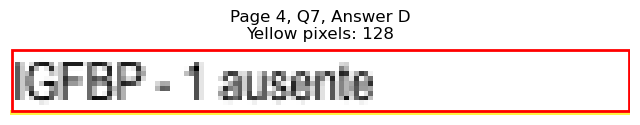

Page 4, Q7 - E: Detected box: x0=327.0, y0=632.2, x1=415.5, y1=644.9
Page 4, Q7, E: Yellow pixels: 1472
Page 4, Q7, E: Total non-white pixels: 1807
Page 4, Q7, E: Yellow percentage: 81.5%


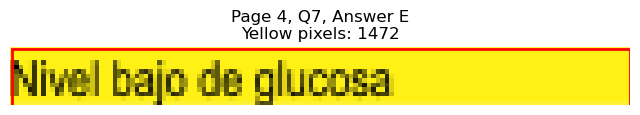


Page 4, Q7 - Selected Answer: E (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=682.7, x1=88.8, y1=695.3
Page 4, Q8, A: Yellow pixels: 796
Page 4, Q8, A: Total non-white pixels: 994
Page 4, Q8, A: Yellow percentage: 80.1%


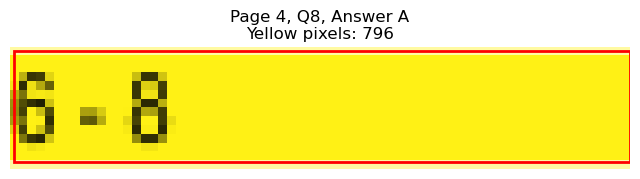

Page 4, Q8 - B: Detected box: x0=68.3, y0=695.4, x1=88.8, y1=708.0
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 132
Page 4, Q8, B: Yellow percentage: 0.0%


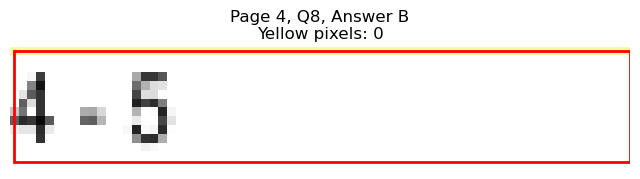

Page 4, Q8 - C: Detected box: x0=68.8, y0=708.0, x1=99.4, y1=720.6
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 101
Page 4, Q8, C: Yellow percentage: 0.0%


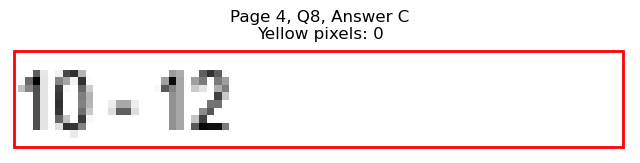

Page 4, Q8 - D: Detected box: x0=327.5, y0=682.7, x1=353.1, y1=695.3
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 91
Page 4, Q8, D: Yellow percentage: 0.0%


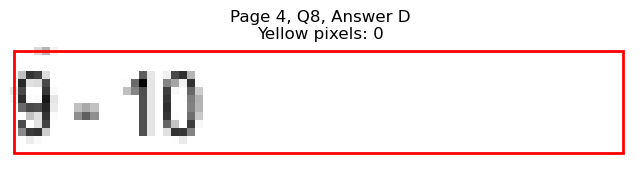

Page 4, Q8 - E: Detected box: x0=327.0, y0=695.4, x1=347.6, y1=708.0
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 60
Page 4, Q8, E: Yellow percentage: 0.0%


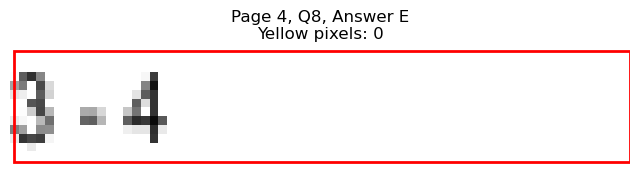


Page 4, Q8 - Selected Answer: A (based on yellow pixel count)





Page 5: Found 7 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=223.7, y1=139.9
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 775
Page 5, Q1, A: Yellow percentage: 0.0%


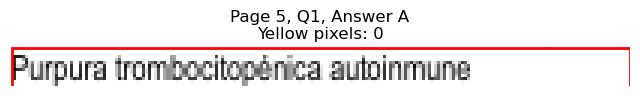

Page 5, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=218.8, y1=152.6
Page 5, Q1, B: Yellow pixels: 2033
Page 5, Q1, B: Total non-white pixels: 2814
Page 5, Q1, B: Yellow percentage: 72.2%


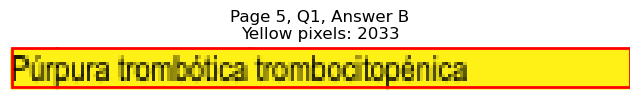

Page 5, Q1 - C: Detected box: x0=68.8, y0=152.5, x1=137.5, y1=165.2
Page 5, Q1, C: Yellow pixels: 120
Page 5, Q1, C: Total non-white pixels: 465
Page 5, Q1, C: Yellow percentage: 25.8%


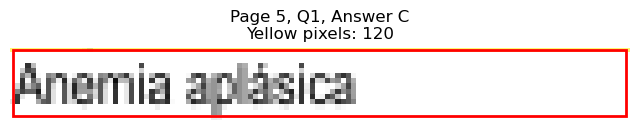

Page 5, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=444.4, y1=139.9
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 579
Page 5, Q1, D: Yellow percentage: 0.0%


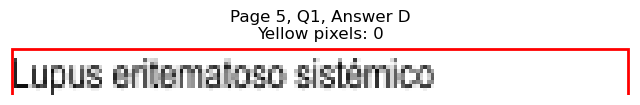

Page 5, Q1 - E: Detected box: x0=327.0, y0=139.9, x1=436.4, y1=152.6
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 565
Page 5, Q1, E: Yellow percentage: 0.0%


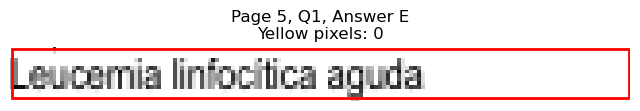


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=121.0, y1=215.6
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 262
Page 5, Q2, A: Yellow percentage: 0.0%


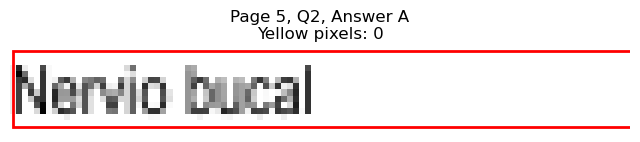

Page 5, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=142.5, y1=228.3
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 380
Page 5, Q2, B: Yellow percentage: 0.0%


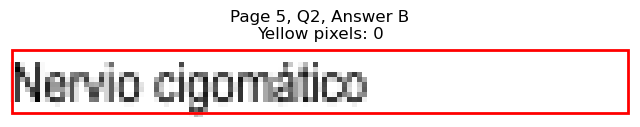

Page 5, Q2 - C: Detected box: x0=68.8, y0=228.3, x1=130.0, y1=240.9
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 261
Page 5, Q2, C: Yellow percentage: 0.0%


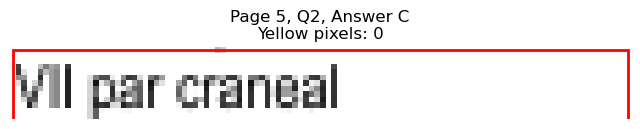

Page 5, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=383.7, y1=215.6
Page 5, Q2, D: Yellow pixels: 1175
Page 5, Q2, D: Total non-white pixels: 1498
Page 5, Q2, D: Yellow percentage: 78.4%


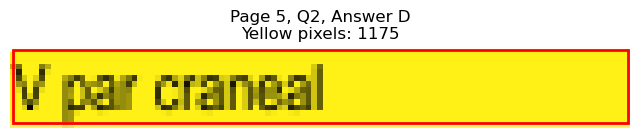

Page 5, Q2 - E: Detected box: x0=327.0, y0=215.7, x1=385.7, y1=228.3
Page 5, Q2, E: Yellow pixels: 109
Page 5, Q2, E: Total non-white pixels: 389
Page 5, Q2, E: Yellow percentage: 28.0%


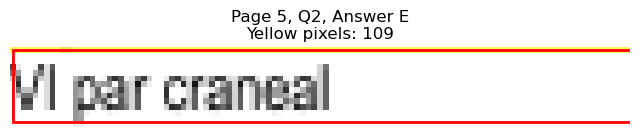


Page 5, Q2 - Selected Answer: D (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=266.1, x1=115.9, y1=278.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 249
Page 5, Q3, A: Yellow percentage: 0.0%


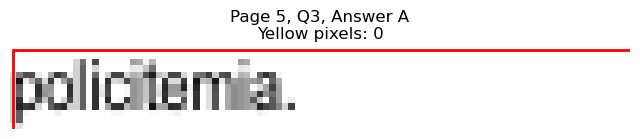

Page 5, Q3 - B: Detected box: x0=68.3, y0=278.8, x1=176.7, y1=291.5
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 529
Page 5, Q3, B: Yellow percentage: 0.0%


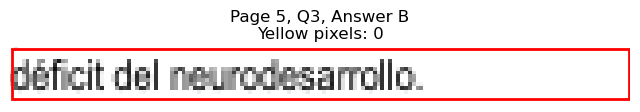

Page 5, Q3 - C: Detected box: x0=68.8, y0=291.4, x1=139.9, y1=304.1
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 360
Page 5, Q3, C: Yellow percentage: 0.0%


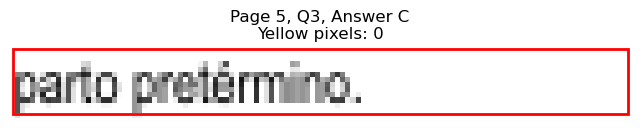

Page 5, Q3 - D: Detected box: x0=327.5, y0=266.1, x1=385.7, y1=278.7
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 304
Page 5, Q3, D: Yellow percentage: 0.0%


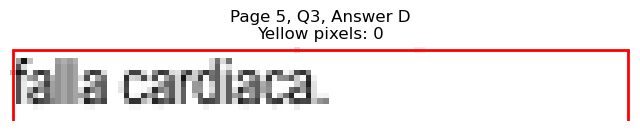

Page 5, Q3 - E: Detected box: x0=327.0, y0=278.8, x1=395.2, y1=291.5
Page 5, Q3, E: Yellow pixels: 1262
Page 5, Q3, E: Total non-white pixels: 1666
Page 5, Q3, E: Yellow percentage: 75.8%


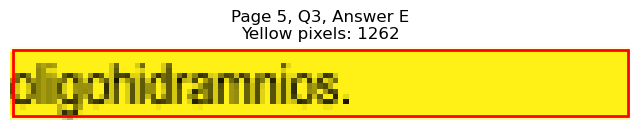


Page 5, Q3 - Selected Answer: E (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=354.5, x1=138.0, y1=367.2
Page 5, Q4, A: Yellow pixels: 121
Page 5, Q4, A: Total non-white pixels: 475
Page 5, Q4, A: Yellow percentage: 25.5%


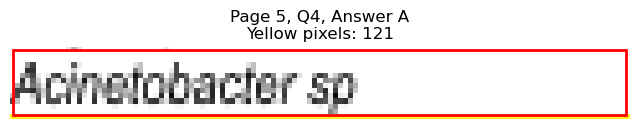

Page 5, Q4 - B: Detected box: x0=68.3, y0=367.1, x1=180.1, y1=379.8
Page 5, Q4, B: Yellow pixels: 1679
Page 5, Q4, B: Total non-white pixels: 2119
Page 5, Q4, B: Yellow percentage: 79.2%


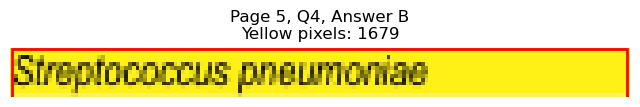

Page 5, Q4 - C: Detected box: x0=68.8, y0=379.7, x1=176.1, y1=392.4
Page 5, Q4, C: Yellow pixels: 159
Page 5, Q4, C: Total non-white pixels: 693
Page 5, Q4, C: Yellow percentage: 22.9%


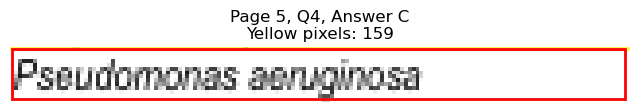

Page 5, Q4 - D: Detected box: x0=327.5, y0=354.5, x1=441.9, y1=367.2
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 596
Page 5, Q4, D: Yellow percentage: 0.0%


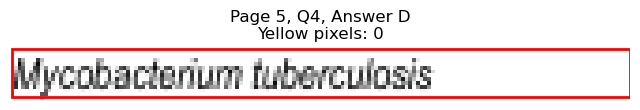

Page 5, Q4 - E: Detected box: x0=327.0, y0=367.1, x1=418.4, y1=379.8
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 480
Page 5, Q4, E: Yellow percentage: 0.0%


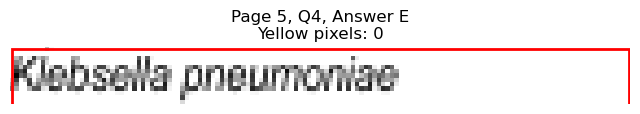


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=56.6, y0=442.8, x1=65.2, y1=455.5
Page 5, Q5, A: Yellow pixels: 60
Page 5, Q5, A: Total non-white pixels: 121
Page 5, Q5, A: Yellow percentage: 49.6%


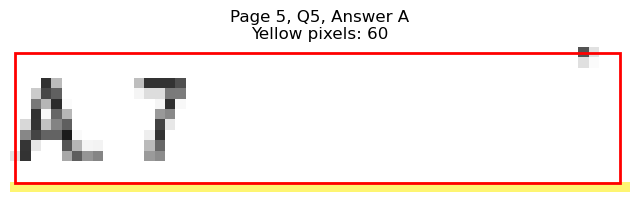

Page 5, Q5 - B: Detected box: x0=68.3, y0=455.5, x1=80.9, y1=468.1
Page 5, Q5, B: Yellow pixels: 783
Page 5, Q5, B: Total non-white pixels: 882
Page 5, Q5, B: Yellow percentage: 88.8%


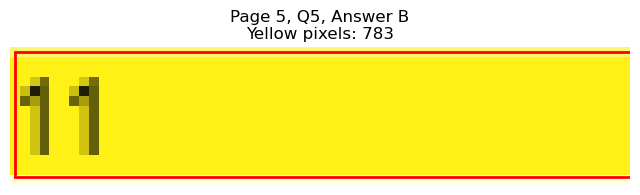

Page 5, Q5 - C: Detected box: x0=56.6, y0=468.1, x1=65.6, y1=480.7
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 132
Page 5, Q5, C: Yellow percentage: 0.0%


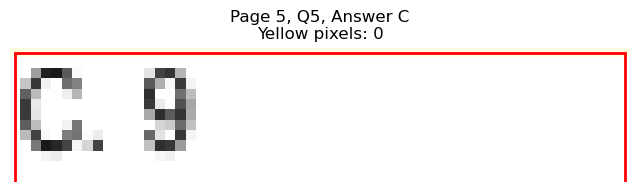

Page 5, Q5 - D: Detected box: x0=315.4, y0=442.8, x1=324.4, y1=455.5
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 73
Page 5, Q5, D: Yellow percentage: 0.0%


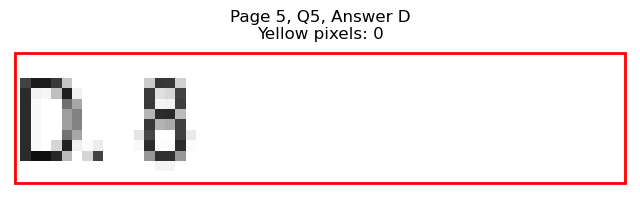

Page 5, Q5 - E: Detected box: x0=315.4, y0=455.5, x1=323.9, y1=468.1
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 71
Page 5, Q5, E: Yellow percentage: 0.0%


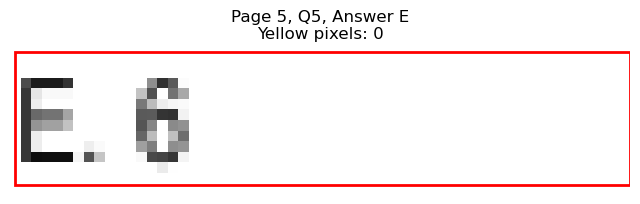


Page 5, Q5 - Selected Answer: B (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=506.0, x1=83.9, y1=518.6
Page 5, Q6, A: Yellow pixels: 806
Page 5, Q6, A: Total non-white pixels: 924
Page 5, Q6, A: Yellow percentage: 87.2%


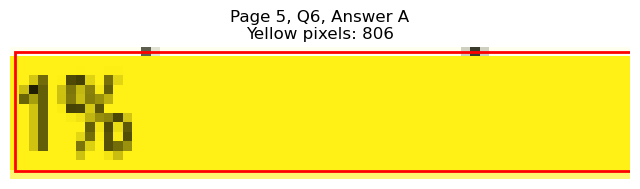

Page 5, Q6 - B: Detected box: x0=68.3, y0=518.6, x1=83.9, y1=531.2
Page 5, Q6, B: Yellow pixels: 66
Page 5, Q6, B: Total non-white pixels: 143
Page 5, Q6, B: Yellow percentage: 46.2%


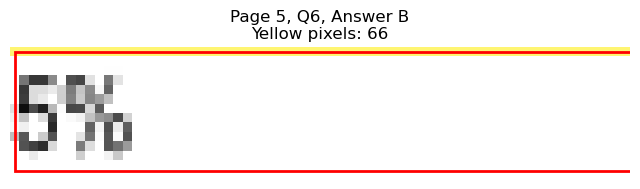

Page 5, Q6 - C: Detected box: x0=68.8, y0=531.2, x1=84.4, y1=543.8
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 75
Page 5, Q6, C: Yellow percentage: 0.0%


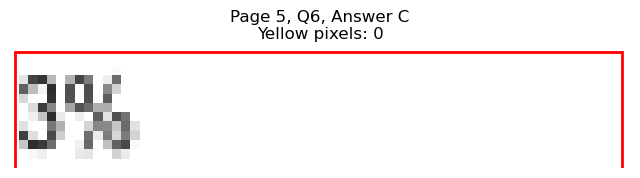

Page 5, Q6 - D: Detected box: x0=327.5, y0=506.0, x1=343.1, y1=518.6
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 68
Page 5, Q6, D: Yellow percentage: 0.0%


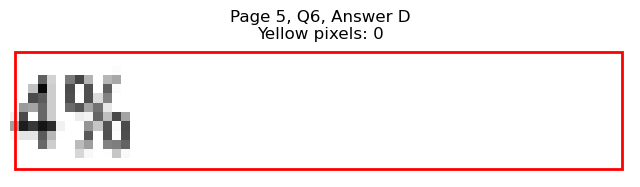

Page 5, Q6 - E: Detected box: x0=327.0, y0=518.6, x1=342.7, y1=531.2
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 72
Page 5, Q6, E: Yellow percentage: 0.0%


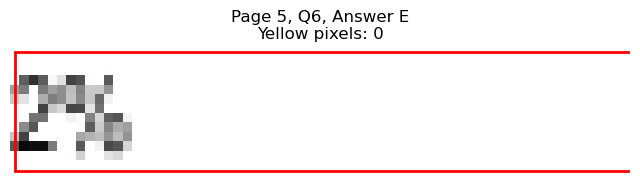


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=581.7, x1=149.1, y1=594.4
Page 5, Q7, A: Yellow pixels: 1265
Page 5, Q7, A: Total non-white pixels: 1848
Page 5, Q7, A: Yellow percentage: 68.5%


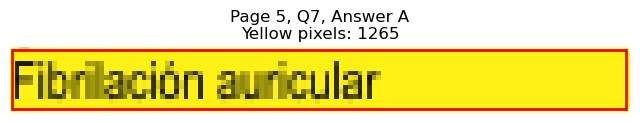

Page 5, Q7 - B: Detected box: x0=68.3, y0=594.3, x1=226.8, y1=607.0
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 1000
Page 5, Q7, B: Yellow percentage: 0.0%


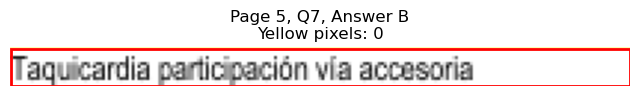

Page 5, Q7 - C: Detected box: x0=68.8, y0=606.9, x1=186.6, y1=619.6
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 598
Page 5, Q7, C: Yellow percentage: 0.0%


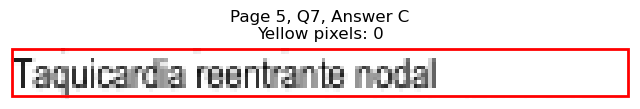

Page 5, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=392.7, y1=594.4
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 339
Page 5, Q7, D: Yellow percentage: 0.0%


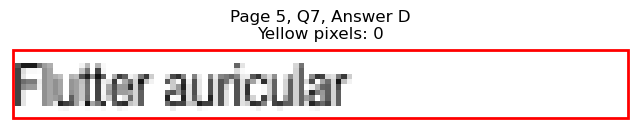

Page 5, Q7 - E: Detected box: x0=327.0, y0=594.3, x1=411.4, y1=607.0
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 443
Page 5, Q7, E: Yellow percentage: 0.0%


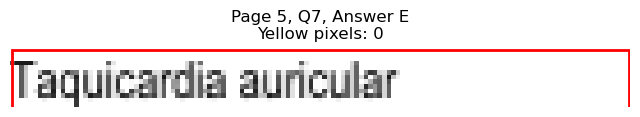


Page 5, Q7 - Selected Answer: A (based on yellow pixel count)





Page 6: Found 8 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=194.2, y1=139.9
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 619
Page 6, Q1, A: Yellow percentage: 0.0%


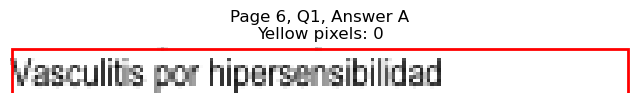

Page 6, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=205.1, y1=152.6
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 649
Page 6, Q1, B: Yellow percentage: 0.0%


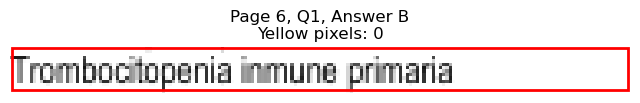

Page 6, Q1 - C: Detected box: x0=68.8, y0=152.5, x1=172.6, y1=165.2
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 532
Page 6, Q1, C: Yellow percentage: 0.0%


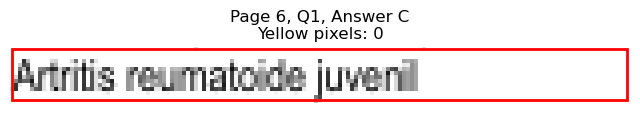

Page 6, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=450.9, y1=139.9
Page 6, Q1, D: Yellow pixels: 1807
Page 6, Q1, D: Total non-white pixels: 2262
Page 6, Q1, D: Yellow percentage: 79.9%


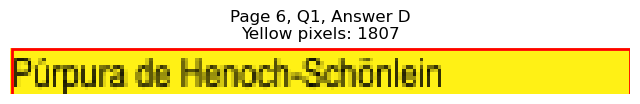

Page 6, Q1 - E: Detected box: x0=327.0, y0=139.9, x1=401.3, y1=152.6
Page 6, Q1, E: Yellow pixels: 124
Page 6, Q1, E: Total non-white pixels: 520
Page 6, Q1, E: Yellow percentage: 23.8%


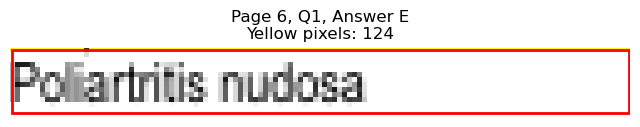


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=215.7, x1=111.4, y1=228.3
Page 6, Q2, A: Yellow pixels: 946
Page 6, Q2, A: Total non-white pixels: 1316
Page 6, Q2, A: Yellow percentage: 71.9%


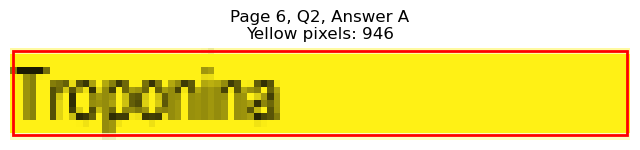

Page 6, Q2 - B: Detected box: x0=68.3, y0=228.3, x1=101.4, y1=240.9
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 258
Page 6, Q2, B: Yellow percentage: 0.0%


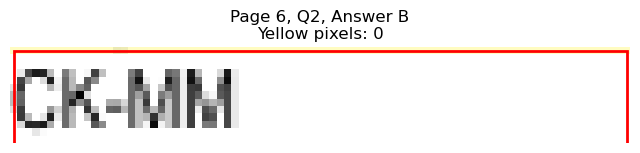

Page 6, Q2 - C: Detected box: x0=68.8, y0=240.9, x1=133.0, y1=253.5
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 305
Page 6, Q2, C: Yellow percentage: 0.0%


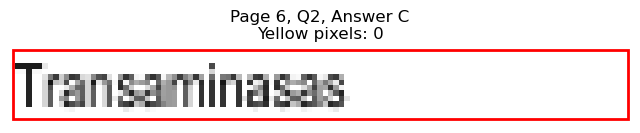

Page 6, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=364.6, y1=228.3
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 180
Page 6, Q2, D: Yellow percentage: 0.0%


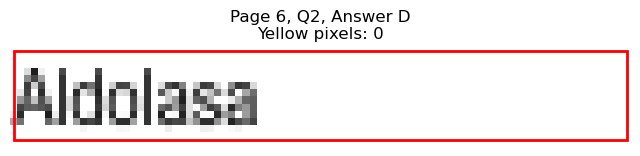

Page 6, Q2 - E: Detected box: x0=327.0, y0=228.3, x1=423.3, y1=240.9
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 529
Page 6, Q2, E: Yellow percentage: 0.0%


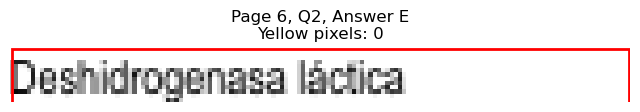


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=304.0, x1=132.5, y1=316.7
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 441
Page 6, Q3, A: Yellow percentage: 0.0%


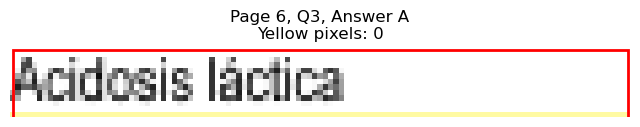

Page 6, Q3 - B: Detected box: x0=68.3, y0=316.6, x1=153.6, y1=329.3
Page 6, Q3, B: Yellow pixels: 1270
Page 6, Q3, B: Total non-white pixels: 1904
Page 6, Q3, B: Yellow percentage: 66.7%


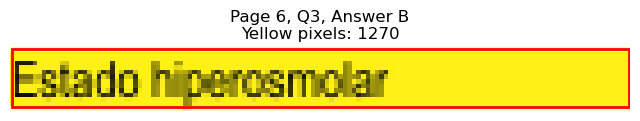

Page 6, Q3 - C: Detected box: x0=68.8, y0=329.2, x1=161.5, y1=341.9
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 636
Page 6, Q3, C: Yellow percentage: 0.0%


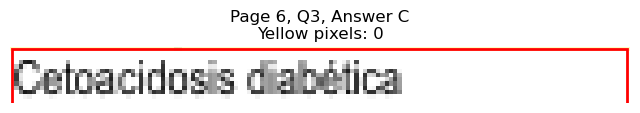

Page 6, Q3 - D: Detected box: x0=327.5, y0=304.0, x1=419.8, y1=316.7
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 478
Page 6, Q3, D: Yellow percentage: 0.0%


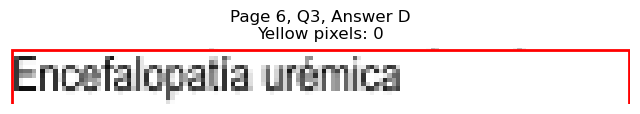

Page 6, Q3 - E: Detected box: x0=327.0, y0=316.6, x1=408.8, y1=329.3
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 414
Page 6, Q3, E: Yellow percentage: 0.0%


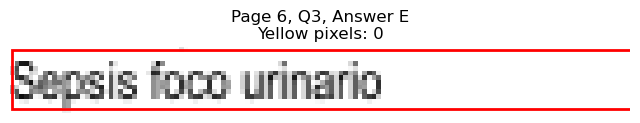


Page 6, Q3 - Selected Answer: B (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=367.1, x1=147.0, y1=379.8
Page 6, Q4, A: Yellow pixels: 1383
Page 6, Q4, A: Total non-white pixels: 1690
Page 6, Q4, A: Yellow percentage: 81.8%


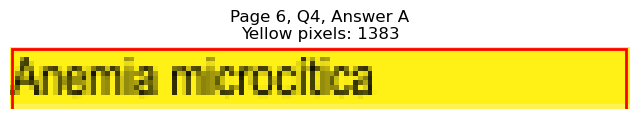

Page 6, Q4 - B: Detected box: x0=68.3, y0=379.7, x1=232.4, y1=392.4
Page 6, Q4, B: Yellow pixels: 213
Page 6, Q4, B: Total non-white pixels: 1061
Page 6, Q4, B: Yellow percentage: 20.1%


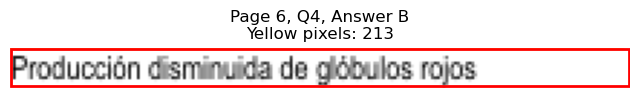

Page 6, Q4 - C: Detected box: x0=68.8, y0=392.3, x1=142.0, y1=405.0
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 354
Page 6, Q4, C: Yellow percentage: 0.0%


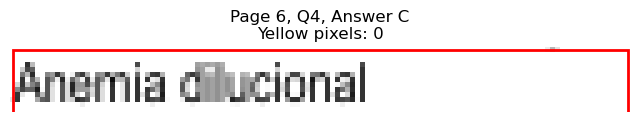

Page 6, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=409.3, y1=379.8
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 393
Page 6, Q4, D: Yellow percentage: 0.0%


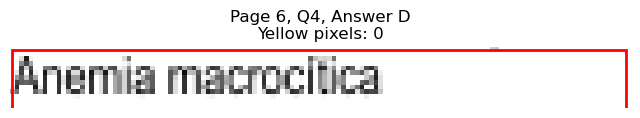

Page 6, Q4 - E: Detected box: x0=327.0, y0=379.7, x1=409.3, y1=392.4
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 401
Page 6, Q4, E: Yellow percentage: 0.0%


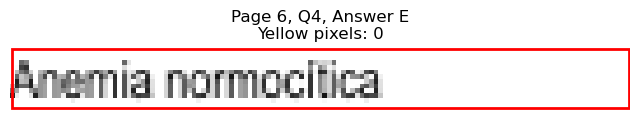


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=56.6, y0=442.8, x1=65.2, y1=455.5
Page 6, Q5, A: Yellow pixels: 60
Page 6, Q5, A: Total non-white pixels: 135
Page 6, Q5, A: Yellow percentage: 44.4%


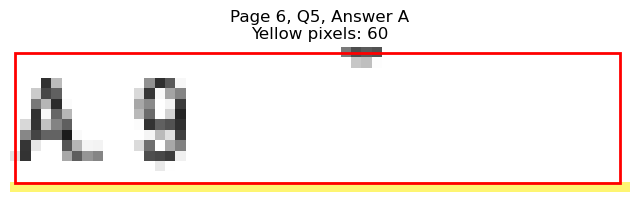

Page 6, Q5 - B: Detected box: x0=56.6, y0=455.5, x1=65.2, y1=468.1
Page 6, Q5, B: Yellow pixels: 716
Page 6, Q5, B: Total non-white pixels: 840
Page 6, Q5, B: Yellow percentage: 85.2%


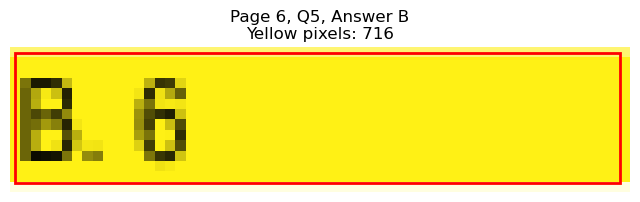

Page 6, Q5 - C: Detected box: x0=56.6, y0=468.1, x1=65.6, y1=480.7
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 123
Page 6, Q5, C: Yellow percentage: 0.0%


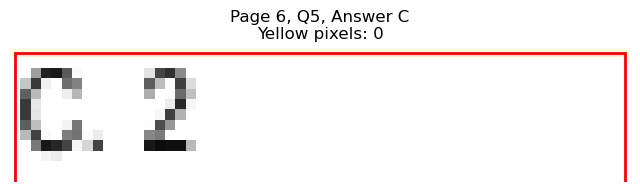

Page 6, Q5 - D: Detected box: x0=315.4, y0=442.8, x1=324.4, y1=455.5
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 69
Page 6, Q5, D: Yellow percentage: 0.0%


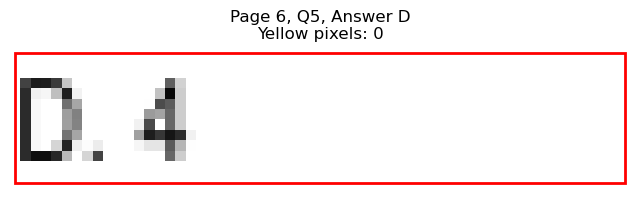

Page 6, Q5 - E: Detected box: x0=315.4, y0=455.5, x1=323.9, y1=468.1
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 66
Page 6, Q5, E: Yellow percentage: 0.0%


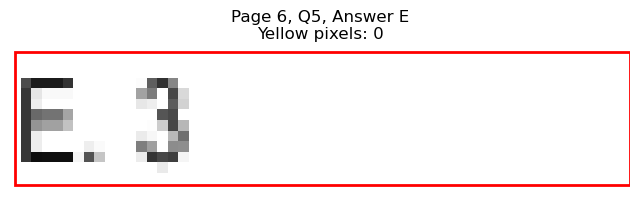


Page 6, Q5 - Selected Answer: B (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=543.8, x1=251.3, y1=556.4
Page 6, Q6, A: Yellow pixels: 2073
Page 6, Q6, A: Total non-white pixels: 2996
Page 6, Q6, A: Yellow percentage: 69.2%


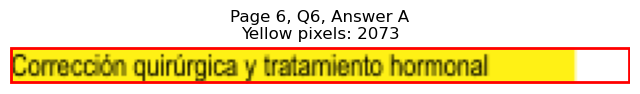

Page 6, Q6 - B: Detected box: x0=123.5, y0=556.5, x1=174.6, y1=569.2
Page 6, Q6, B: Yellow pixels: 99
Page 6, Q6, B: Total non-white pixels: 595
Page 6, Q6, B: Yellow percentage: 16.6%


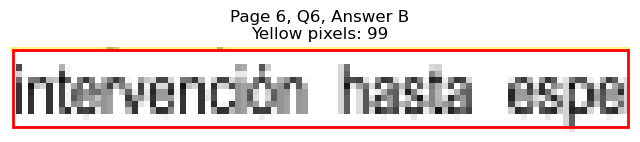

Page 6, Q6 - C: Detected box: x0=327.5, y0=543.8, x1=435.9, y1=556.4
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 542
Page 6, Q6, C: Yellow percentage: 0.0%


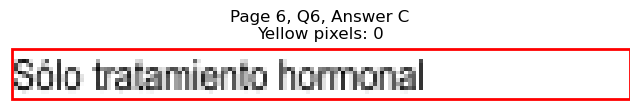

Page 6, Q6 - D: Detected box: x0=327.5, y0=556.5, x1=437.8, y1=569.2
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 581
Page 6, Q6, D: Yellow percentage: 0.0%


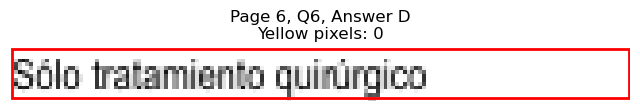

Page 6, Q6 - E: Detected box: x0=327.0, y0=569.1, x1=414.9, y1=581.8
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 435
Page 6, Q6, E: Yellow percentage: 0.0%


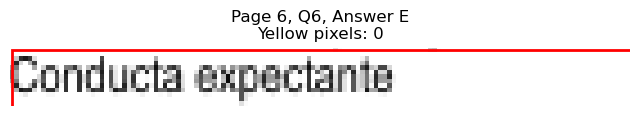


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=619.6, x1=107.9, y1=632.3
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 192
Page 6, Q7, A: Yellow percentage: 0.0%


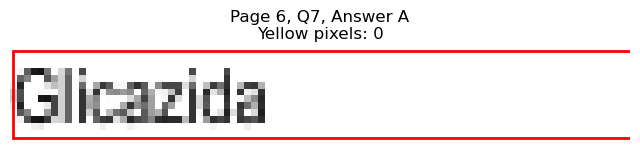

Page 6, Q7 - B: Detected box: x0=68.3, y0=632.2, x1=116.4, y1=644.9
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 259
Page 6, Q7, B: Yellow percentage: 0.0%


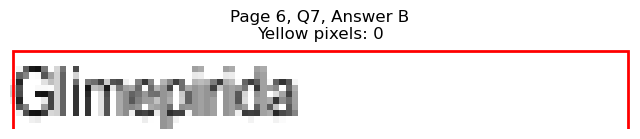

Page 6, Q7 - C: Detected box: x0=68.8, y0=644.9, x1=116.4, y1=657.5
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 253
Page 6, Q7, C: Yellow percentage: 0.0%


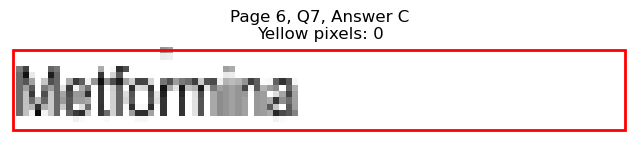

Page 6, Q7 - D: Detected box: x0=327.5, y0=619.6, x1=375.7, y1=632.3
Page 6, Q7, D: Yellow pixels: 1004
Page 6, Q7, D: Total non-white pixels: 1386
Page 6, Q7, D: Yellow percentage: 72.4%


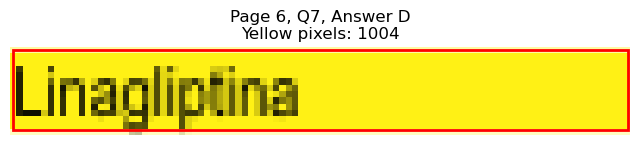

Page 6, Q7 - E: Detected box: x0=327.0, y0=632.2, x1=386.7, y1=644.9
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 443
Page 6, Q7, E: Yellow percentage: 0.0%


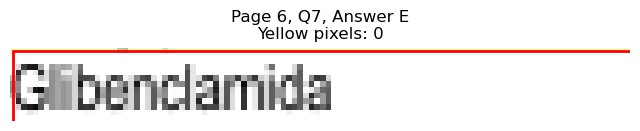


Page 6, Q7 - Selected Answer: D (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=708.0, x1=105.9, y1=720.6
Page 6, Q8, A: Yellow pixels: 1003
Page 6, Q8, A: Total non-white pixels: 1232
Page 6, Q8, A: Yellow percentage: 81.4%


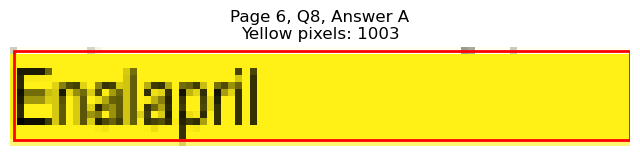

Page 6, Q8 - B: Detected box: x0=68.3, y0=720.6, x1=110.9, y1=733.2
Page 6, Q8, B: Yellow pixels: 93
Page 6, Q8, B: Total non-white pixels: 316
Page 6, Q8, B: Yellow percentage: 29.4%


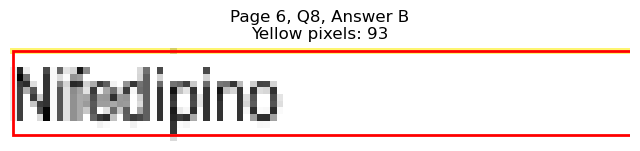

Page 6, Q8 - C: Detected box: x0=68.8, y0=733.2, x1=118.9, y1=745.8
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 239
Page 6, Q8, C: Yellow percentage: 0.0%


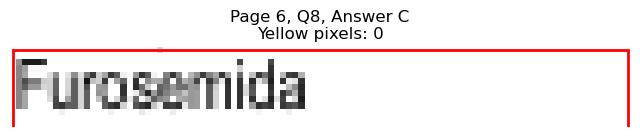

Page 6, Q8 - D: Detected box: x0=327.5, y0=708.0, x1=397.3, y1=720.6
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 390
Page 6, Q8, D: Yellow percentage: 0.0%


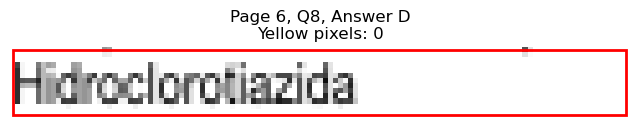

Page 6, Q8 - E: Detected box: x0=327.0, y0=720.6, x1=373.2, y1=733.2
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 255
Page 6, Q8, E: Yellow percentage: 0.0%


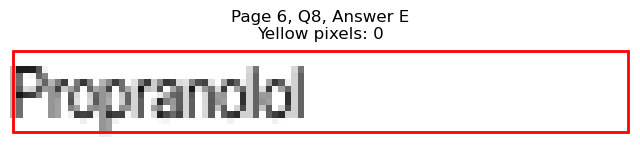


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)





Page 7: Found 8 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=149.1, y1=127.3
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 382
Page 7, Q1, A: Yellow percentage: 0.0%


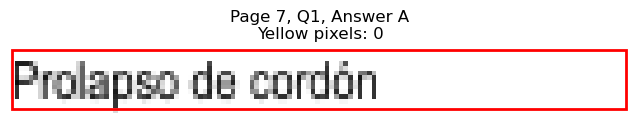

Page 7, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=165.6, y1=139.9
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 498
Page 7, Q1, B: Yellow percentage: 0.0%


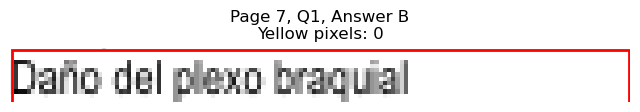

Page 7, Q1 - C: Detected box: x0=68.8, y0=139.9, x1=144.5, y1=152.6
Page 7, Q1, C: Yellow pixels: 1373
Page 7, Q1, C: Total non-white pixels: 1778
Page 7, Q1, C: Yellow percentage: 77.2%


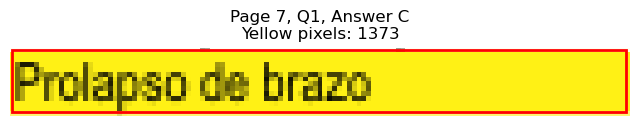

Page 7, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=356.1, y1=127.3
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 111
Page 7, Q1, D: Yellow percentage: 0.0%


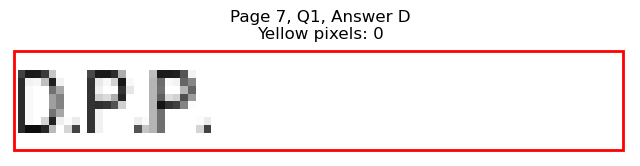

Page 7, Q1 - E: Detected box: x0=327.0, y0=127.2, x1=391.7, y1=139.9
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 327
Page 7, Q1, E: Yellow percentage: 0.0%


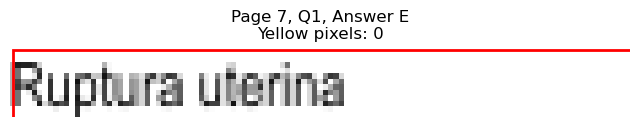


Page 7, Q1 - Selected Answer: C (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=190.3, x1=127.0, y1=203.0
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 287
Page 7, Q2, A: Yellow percentage: 0.0%


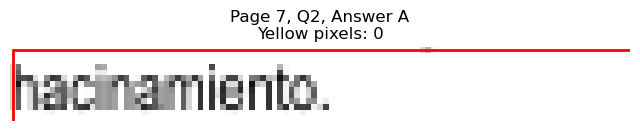

Page 7, Q2 - B: Detected box: x0=68.3, y0=202.9, x1=191.7, y1=215.6
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 623
Page 7, Q2, B: Yellow percentage: 0.0%


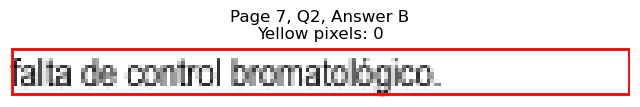

Page 7, Q2 - C: Detected box: x0=68.8, y0=215.7, x1=214.2, y1=228.3
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 716
Page 7, Q2, C: Yellow percentage: 0.0%


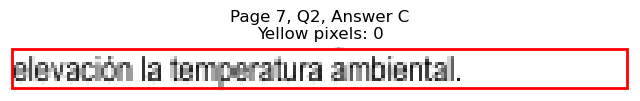

Page 7, Q2 - D: Detected box: x0=327.5, y0=190.3, x1=474.1, y1=203.0
Page 7, Q2, D: Yellow pixels: 2029
Page 7, Q2, D: Total non-white pixels: 2574
Page 7, Q2, D: Yellow percentage: 78.8%


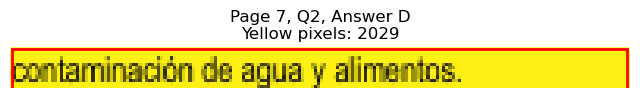

Page 7, Q2 - E: Detected box: x0=327.0, y0=202.9, x1=419.8, y1=215.6
Page 7, Q2, E: Yellow pixels: 137
Page 7, Q2, E: Total non-white pixels: 607
Page 7, Q2, E: Yellow percentage: 22.6%


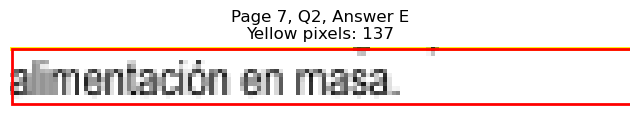


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=150.0, y1=291.5
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 411
Page 7, Q3, A: Yellow percentage: 0.0%


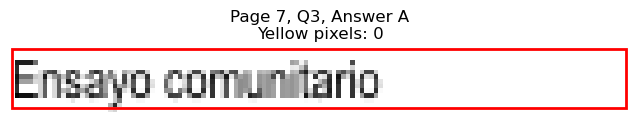

Page 7, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=129.0, y1=304.1
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 308
Page 7, Q3, B: Yellow percentage: 0.0%


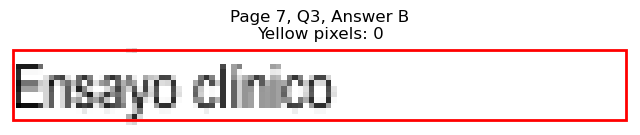

Page 7, Q3 - C: Detected box: x0=68.8, y0=304.0, x1=154.6, y1=316.7
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 412
Page 7, Q3, C: Yellow percentage: 0.0%


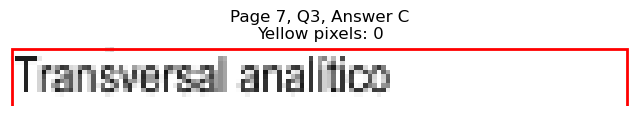

Page 7, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=362.1, y1=291.5
Page 7, Q3, D: Yellow pixels: 980
Page 7, Q3, D: Total non-white pixels: 1204
Page 7, Q3, D: Yellow percentage: 81.4%


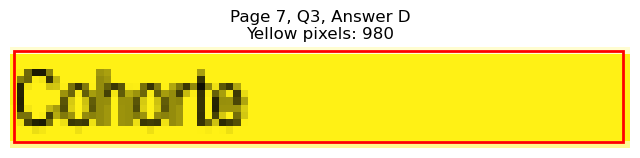

Page 7, Q3 - E: Detected box: x0=327.0, y0=291.4, x1=380.2, y1=304.1
Page 7, Q3, E: Yellow pixels: 104
Page 7, Q3, E: Total non-white pixels: 351
Page 7, Q3, E: Yellow percentage: 29.6%


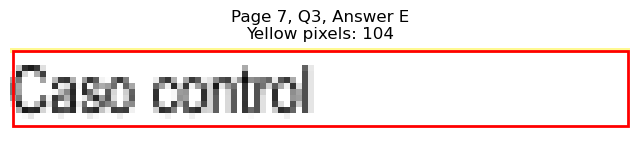


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=367.1, x1=109.5, y1=379.8
Page 7, Q4, A: Yellow pixels: 1024
Page 7, Q4, A: Total non-white pixels: 1196
Page 7, Q4, A: Yellow percentage: 85.6%


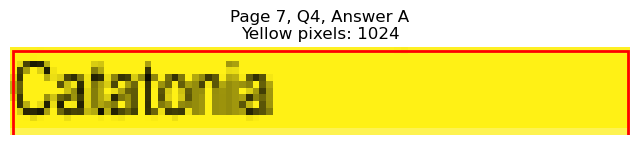

Page 7, Q4 - B: Detected box: x0=68.3, y0=379.7, x1=139.0, y1=392.4
Page 7, Q4, B: Yellow pixels: 121
Page 7, Q4, B: Total non-white pixels: 480
Page 7, Q4, B: Yellow percentage: 25.2%


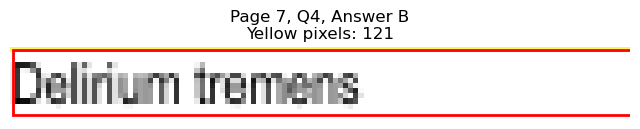

Page 7, Q4 - C: Detected box: x0=68.8, y0=392.3, x1=102.4, y1=405.0
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 166
Page 7, Q4, C: Yellow percentage: 0.0%


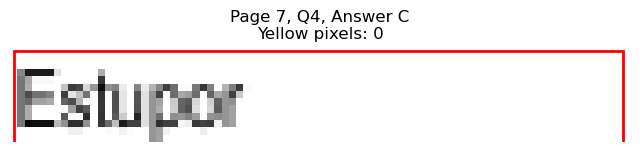

Page 7, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=355.6, y1=379.8
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 155
Page 7, Q4, D: Yellow percentage: 0.0%


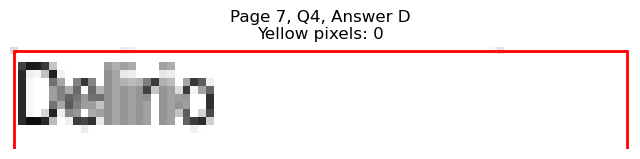

Page 7, Q4 - E: Detected box: x0=327.0, y0=379.7, x1=384.3, y1=392.4
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 296
Page 7, Q4, E: Yellow percentage: 0.0%


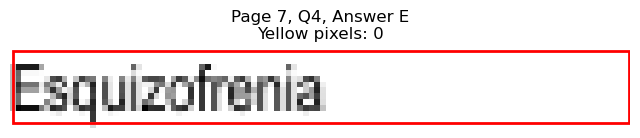


Page 7, Q4 - Selected Answer: A (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=442.8, x1=115.9, y1=455.5
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 245
Page 7, Q5, A: Yellow percentage: 0.0%


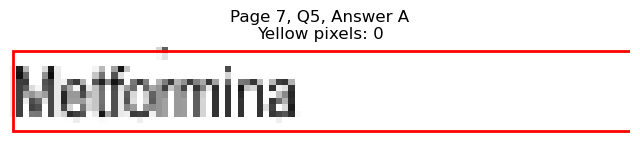

Page 7, Q5 - B: Detected box: x0=68.3, y0=455.5, x1=109.0, y1=468.1
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 204
Page 7, Q5, B: Yellow percentage: 0.0%


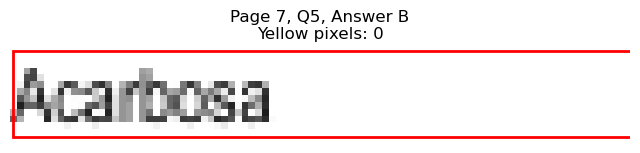

Page 7, Q5 - C: Detected box: x0=68.8, y0=468.1, x1=127.9, y1=480.7
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 291
Page 7, Q5, C: Yellow percentage: 0.0%


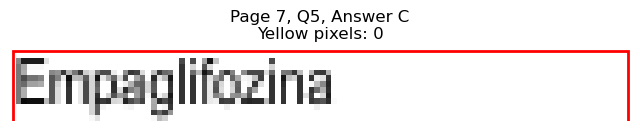

Page 7, Q5 - D: Detected box: x0=327.5, y0=442.8, x1=375.7, y1=455.5
Page 7, Q5, D: Yellow pixels: 1086
Page 7, Q5, D: Total non-white pixels: 1386
Page 7, Q5, D: Yellow percentage: 78.4%


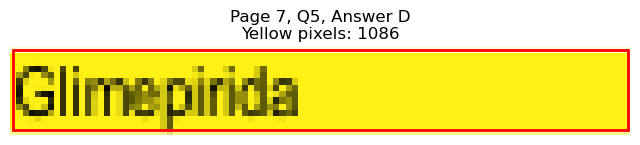

Page 7, Q5 - E: Detected box: x0=327.0, y0=455.5, x1=375.2, y1=468.1
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 272
Page 7, Q5, E: Yellow percentage: 0.0%


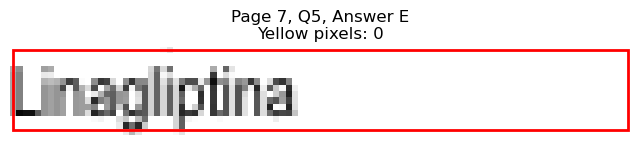


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=543.8, x1=136.0, y1=556.4
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 362
Page 7, Q6, A: Yellow percentage: 0.0%


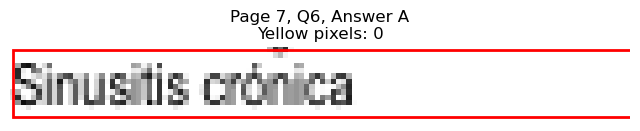

Page 7, Q6 - B: Detected box: x0=68.3, y0=556.5, x1=150.0, y1=569.2
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 412
Page 7, Q6, B: Yellow percentage: 0.0%


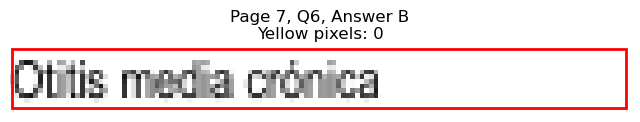

Page 7, Q6 - C: Detected box: x0=68.8, y0=569.1, x1=156.0, y1=581.8
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 446
Page 7, Q6, C: Yellow percentage: 0.0%


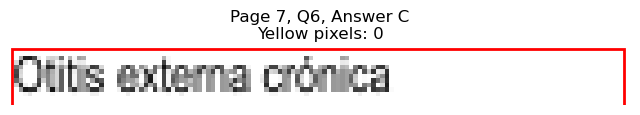

Page 7, Q6 - D: Detected box: x0=327.5, y0=543.8, x1=417.3, y1=556.4
Page 7, Q6, D: Yellow pixels: 1503
Page 7, Q6, D: Total non-white pixels: 1974
Page 7, Q6, D: Yellow percentage: 76.1%


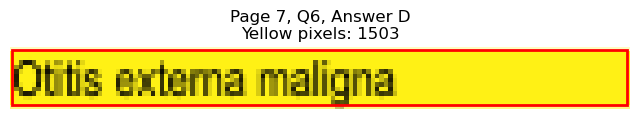

Page 7, Q6 - E: Detected box: x0=327.0, y0=556.5, x1=404.8, y1=569.2
Page 7, Q6, E: Yellow pixels: 126
Page 7, Q6, E: Total non-white pixels: 548
Page 7, Q6, E: Yellow percentage: 23.0%


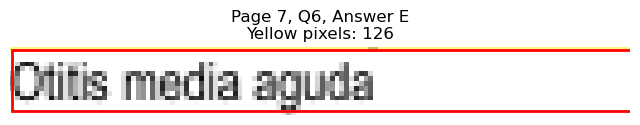


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=606.9, x1=260.0, y1=619.6
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 950
Page 7, Q7, A: Yellow percentage: 0.0%


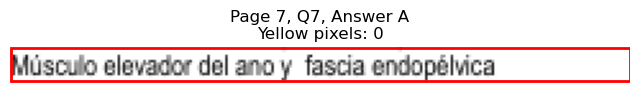

Page 7, Q7 - B: Detected box: x0=68.3, y0=619.6, x1=253.8, y1=632.3
Page 7, Q7, B: Yellow pixels: 1860
Page 7, Q7, B: Total non-white pixels: 2996
Page 7, Q7, B: Yellow percentage: 62.1%


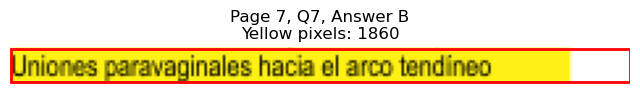

Page 7, Q7 - C: Detected box: x0=68.8, y0=632.2, x1=264.4, y1=644.9
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 1184
Page 7, Q7, C: Yellow percentage: 0.0%


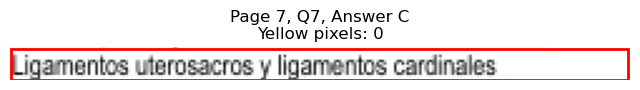

Page 7, Q7 - D: Detected box: x0=327.5, y0=606.9, x1=452.5, y1=619.6
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 644
Page 7, Q7, D: Yellow percentage: 0.0%


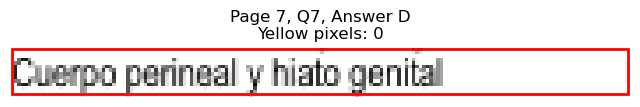

Page 7, Q7 - E: Detected box: x0=327.0, y0=619.6, x1=434.9, y1=632.3
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 553
Page 7, Q7, E: Yellow percentage: 0.0%


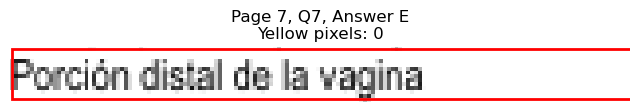


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=708.0, x1=87.9, y1=720.6
Page 7, Q8, A: Yellow pixels: 847
Page 7, Q8, A: Total non-white pixels: 980
Page 7, Q8, A: Yellow percentage: 86.4%


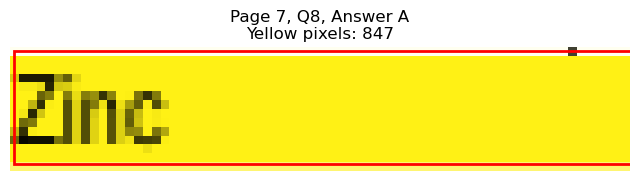

Page 7, Q8 - B: Detected box: x0=68.3, y0=720.6, x1=95.4, y1=733.2
Page 7, Q8, B: Yellow pixels: 78
Page 7, Q8, B: Total non-white pixels: 214
Page 7, Q8, B: Yellow percentage: 36.4%


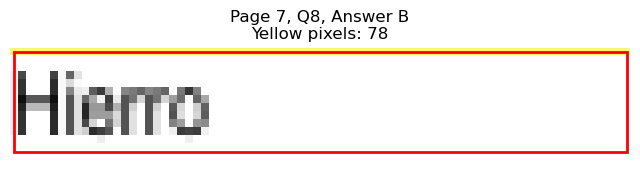

Page 7, Q8 - C: Detected box: x0=68.8, y0=733.2, x1=95.9, y1=745.8
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 132
Page 7, Q8, C: Yellow percentage: 0.0%


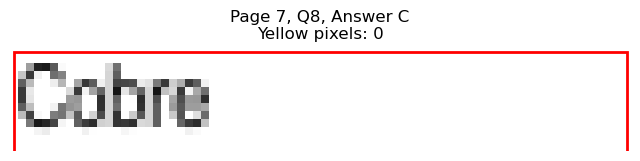

Page 7, Q8 - D: Detected box: x0=327.5, y0=708.0, x1=355.1, y1=720.6
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 131
Page 7, Q8, D: Yellow percentage: 0.0%


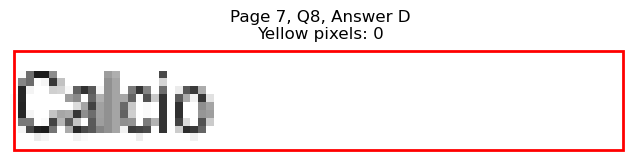

Page 7, Q8 - E: Detected box: x0=327.0, y0=720.6, x1=366.2, y1=733.2
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 222
Page 7, Q8, E: Yellow percentage: 0.0%


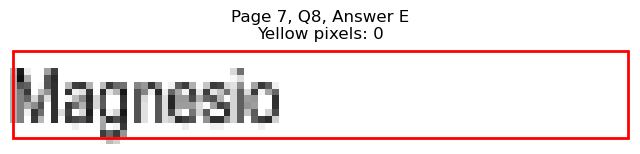


Page 7, Q8 - Selected Answer: A (based on yellow pixel count)





Page 8: Found 8 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=204.6, y1=127.3
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 700
Page 8, Q1, A: Yellow percentage: 0.0%


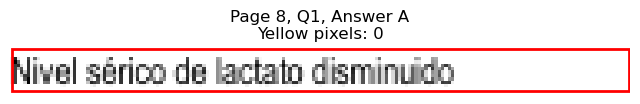

Page 8, Q1 - B: Detected box: x0=242.3, y0=127.2, x1=282.2, y1=139.9
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 274
Page 8, Q1, B: Yellow percentage: 0.0%


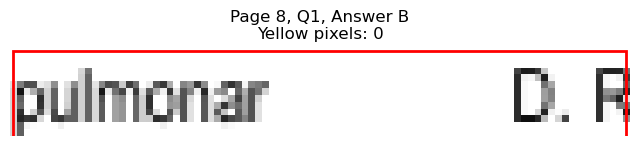

Page 8, Q1 - C: Detected box: x0=327.5, y0=114.6, x1=499.1, y1=127.3
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 859
Page 8, Q1, C: Yellow percentage: 0.0%


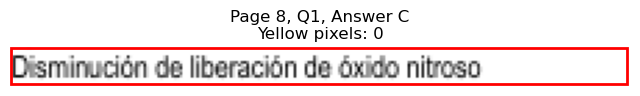

Page 8, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=520.3, y1=139.9
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 975
Page 8, Q1, D: Yellow percentage: 0.0%


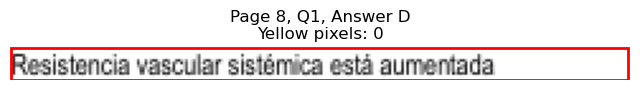

Page 8, Q1 - E: Detected box: x0=327.0, y0=139.9, x1=475.5, y1=152.6
Page 8, Q1, E: Yellow pixels: 2003
Page 8, Q1, E: Total non-white pixels: 2786
Page 8, Q1, E: Yellow percentage: 71.9%


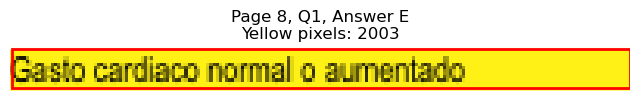


Page 8, Q1 - Selected Answer: E (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=215.7, x1=137.5, y1=228.3
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 365
Page 8, Q2, A: Yellow percentage: 0.0%


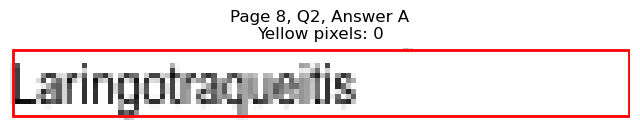

Page 8, Q2 - B: Detected box: x0=68.3, y0=228.3, x1=165.1, y1=240.9
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 672
Page 8, Q2, B: Yellow percentage: 0.0%


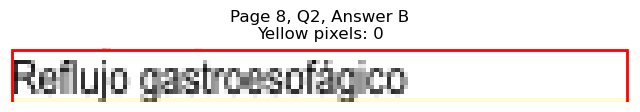

Page 8, Q2 - C: Detected box: x0=68.8, y0=240.9, x1=148.0, y1=253.5
Page 8, Q2, C: Yellow pixels: 1365
Page 8, Q2, C: Total non-white pixels: 1820
Page 8, Q2, C: Yellow percentage: 75.0%


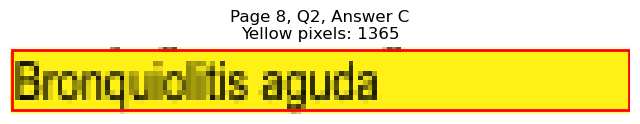

Page 8, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=416.8, y1=228.3
Page 8, Q2, D: Yellow pixels: 0
Page 8, Q2, D: Total non-white pixels: 458
Page 8, Q2, D: Yellow percentage: 0.0%


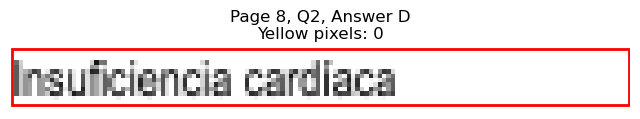

Page 8, Q2 - E: Detected box: x0=327.0, y0=228.3, x1=369.7, y1=240.9
Page 8, Q2, E: Yellow pixels: 0
Page 8, Q2, E: Total non-white pixels: 208
Page 8, Q2, E: Yellow percentage: 0.0%


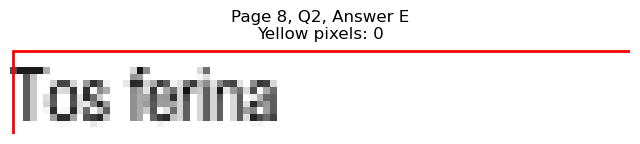


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=89.9, y1=291.5
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 113
Page 8, Q3, A: Yellow percentage: 0.0%


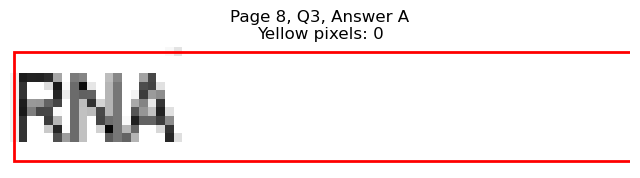

Page 8, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=139.0, y1=304.1
Page 8, Q3, B: Yellow pixels: 121
Page 8, Q3, B: Total non-white pixels: 461
Page 8, Q3, B: Yellow percentage: 26.2%


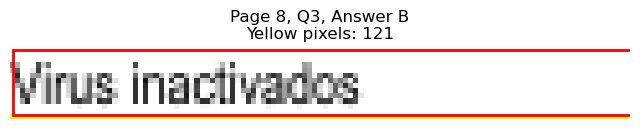

Page 8, Q3 - C: Detected box: x0=68.8, y0=304.0, x1=150.5, y1=316.7
Page 8, Q3, C: Yellow pixels: 1419
Page 8, Q3, C: Total non-white pixels: 1729
Page 8, Q3, C: Yellow percentage: 82.1%


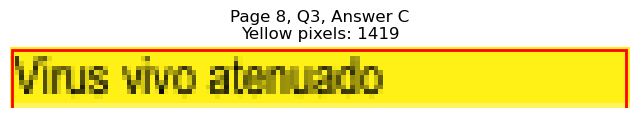

Page 8, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=388.3, y1=291.5
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 314
Page 8, Q3, D: Yellow percentage: 0.0%


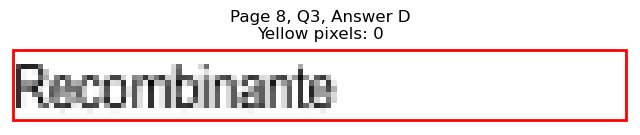

Page 8, Q3 - E: Detected box: x0=327.0, y0=291.4, x1=373.3, y1=304.1
Page 8, Q3, E: Yellow pixels: 0
Page 8, Q3, E: Total non-white pixels: 236
Page 8, Q3, E: Yellow percentage: 0.0%


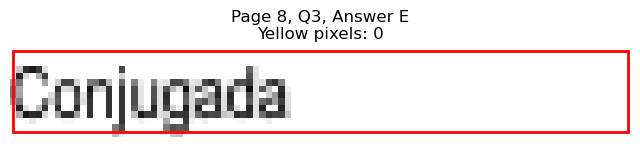


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=367.1, x1=107.5, y1=379.8
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 211
Page 8, Q4, A: Yellow percentage: 0.0%


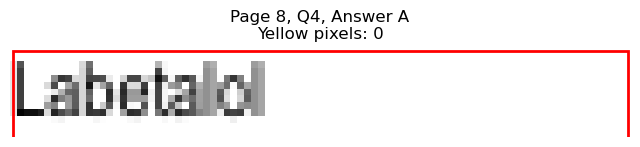

Page 8, Q4 - B: Detected box: x0=68.3, y0=379.7, x1=150.0, y1=392.4
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 403
Page 8, Q4, B: Yellow percentage: 0.0%


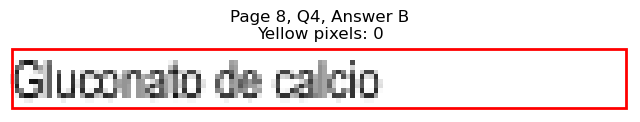

Page 8, Q4 - C: Detected box: x0=68.8, y0=392.3, x1=111.4, y1=405.0
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 240
Page 8, Q4, C: Yellow percentage: 0.0%


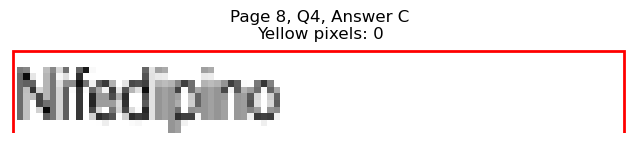

Page 8, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=412.3, y1=379.8
Page 8, Q4, D: Yellow pixels: 1441
Page 8, Q4, D: Total non-white pixels: 1768
Page 8, Q4, D: Yellow percentage: 81.5%


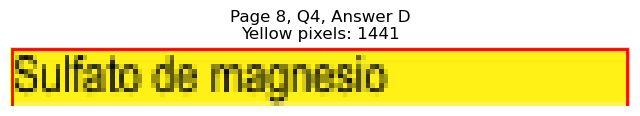

Page 8, Q4 - E: Detected box: x0=327.0, y0=379.7, x1=367.1, y1=392.4
Page 8, Q4, E: Yellow pixels: 90
Page 8, Q4, E: Total non-white pixels: 291
Page 8, Q4, E: Yellow percentage: 30.9%


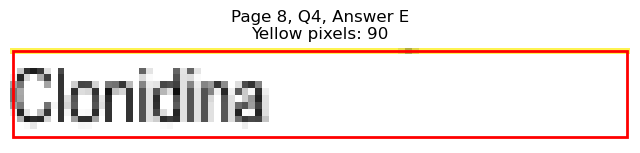


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=442.8, x1=125.1, y1=455.5
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 287
Page 8, Q5, A: Yellow percentage: 0.0%


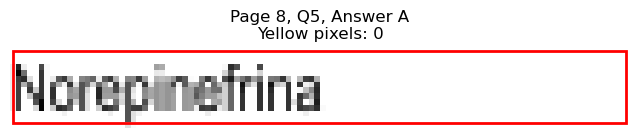

Page 8, Q5 - B: Detected box: x0=68.3, y0=455.5, x1=108.4, y1=468.1
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 206
Page 8, Q5, B: Yellow percentage: 0.0%


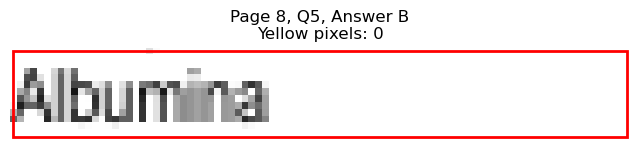

Page 8, Q5 - C: Detected box: x0=68.8, y0=468.1, x1=119.9, y1=480.7
Page 8, Q5, C: Yellow pixels: 0
Page 8, Q5, C: Total non-white pixels: 240
Page 8, Q5, C: Yellow percentage: 0.0%


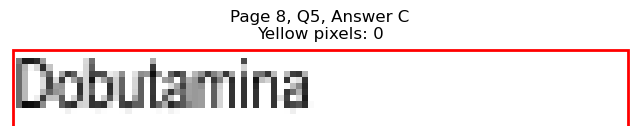

Page 8, Q5 - D: Detected box: x0=327.5, y0=442.8, x1=375.2, y1=455.5
Page 8, Q5, D: Yellow pixels: 99
Page 8, Q5, D: Total non-white pixels: 357
Page 8, Q5, D: Yellow percentage: 27.7%


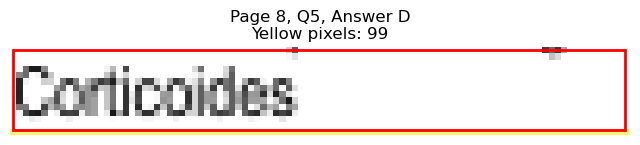

Page 8, Q5 - E: Detected box: x0=327.0, y0=455.5, x1=376.9, y1=468.1
Page 8, Q5, E: Yellow pixels: 1110
Page 8, Q5, E: Total non-white pixels: 1400
Page 8, Q5, E: Yellow percentage: 79.3%


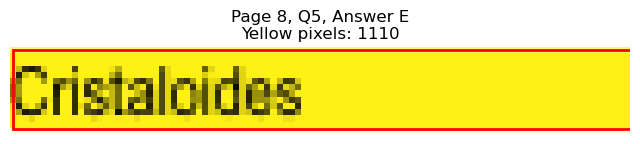


Page 8, Q5 - Selected Answer: E (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=543.8, x1=154.1, y1=556.4
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 461
Page 8, Q6, A: Yellow percentage: 0.0%


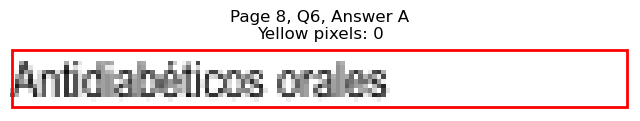

Page 8, Q6 - B: Detected box: x0=68.3, y0=556.5, x1=157.1, y1=569.2
Page 8, Q6, B: Yellow pixels: 1492
Page 8, Q6, B: Total non-white pixels: 1960
Page 8, Q6, B: Yellow percentage: 76.1%


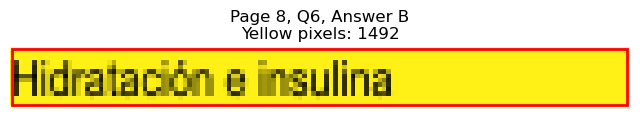

Page 8, Q6 - C: Detected box: x0=68.8, y0=569.1, x1=112.9, y1=581.8
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 332
Page 8, Q6, C: Yellow percentage: 0.0%


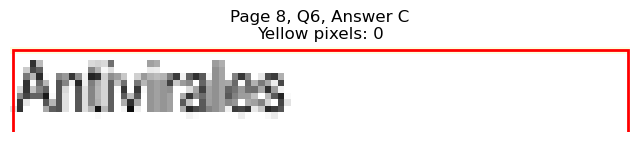

Page 8, Q6 - D: Detected box: x0=327.5, y0=543.8, x1=381.7, y1=556.4
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 270
Page 8, Q6, D: Yellow percentage: 0.0%


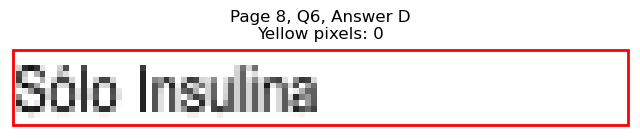

Page 8, Q6 - E: Detected box: x0=327.0, y0=556.5, x1=429.9, y1=569.2
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 530
Page 8, Q6, E: Yellow percentage: 0.0%


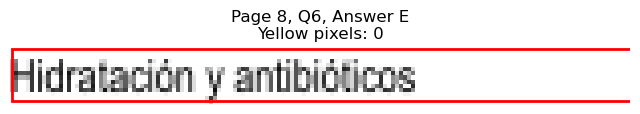


Page 8, Q6 - Selected Answer: B (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=619.6, x1=282.4, y1=632.3
Page 8, Q7, A: Yellow pixels: 19
Page 8, Q7, A: Total non-white pixels: 1165
Page 8, Q7, A: Yellow percentage: 1.6%


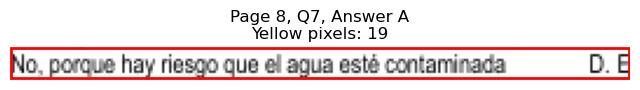

Page 8, Q7 - B: Detected box: x0=68.3, y0=632.2, x1=251.9, y1=644.9
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 917
Page 8, Q7, B: Yellow percentage: 0.0%


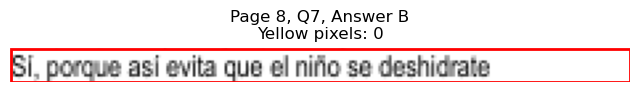

Page 8, Q7 - C: Detected box: x0=68.8, y0=644.9, x1=282.3, y1=657.5
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 1058
Page 8, Q7, C: Yellow percentage: 0.0%


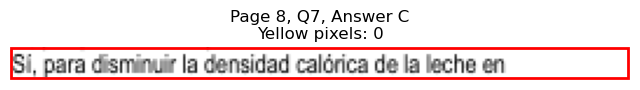

Page 8, Q7 - D: Detected box: x0=327.5, y0=619.6, x1=528.2, y1=632.3
Page 8, Q7, D: Yellow pixels: 213
Page 8, Q7, D: Total non-white pixels: 1227
Page 8, Q7, D: Yellow percentage: 17.4%


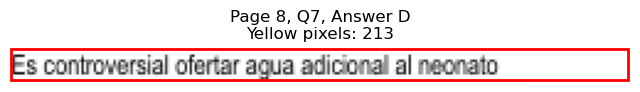

Page 8, Q7 - E: Detected box: x0=327.0, y0=632.2, x1=528.7, y1=644.9
Page 8, Q7, E: Yellow pixels: 1970
Page 8, Q7, E: Total non-white pixels: 2782
Page 8, Q7, E: Yellow percentage: 70.8%


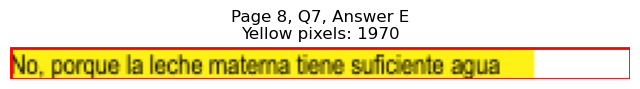


Page 8, Q7 - Selected Answer: E (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=720.6, x1=138.0, y1=733.2
Page 8, Q8, A: Yellow pixels: 1307
Page 8, Q8, A: Total non-white pixels: 1694
Page 8, Q8, A: Yellow percentage: 77.2%


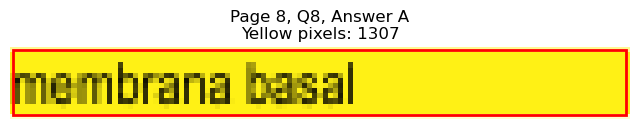

Page 8, Q8 - B: Detected box: x0=68.3, y0=733.2, x1=167.5, y1=745.8
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 646
Page 8, Q8, B: Yellow percentage: 0.0%


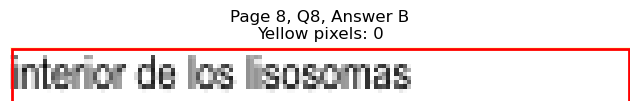

Page 8, Q8 - C: Detected box: x0=68.8, y0=745.8, x1=159.0, y1=758.4
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 459
Page 8, Q8, C: Yellow percentage: 0.0%


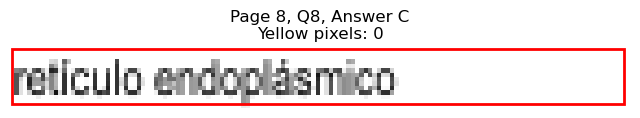

Page 8, Q8 - D: Detected box: x0=327.5, y0=720.6, x1=368.2, y1=733.2
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 199
Page 8, Q8, D: Yellow percentage: 0.0%


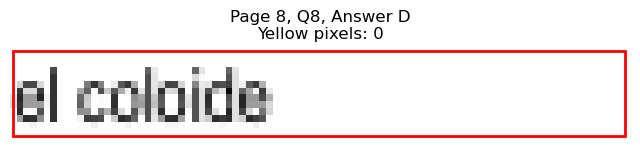

Page 8, Q8 - E: Detected box: x0=327.0, y0=733.2, x1=386.2, y1=745.8
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 293
Page 8, Q8, E: Yellow percentage: 0.0%


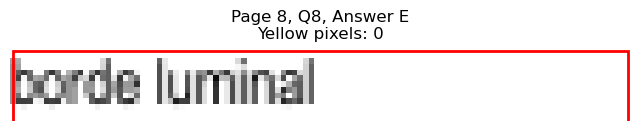


Page 8, Q8 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 8 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=114.6, x1=147.0, y1=127.3
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 414
Page 9, Q1, A: Yellow percentage: 0.0%


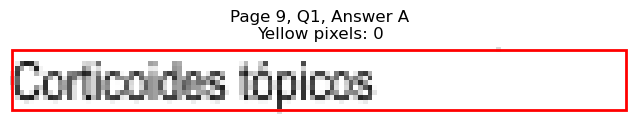

Page 9, Q1 - B: Detected box: x0=68.3, y0=127.2, x1=144.5, y1=139.9
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 368
Page 9, Q1, B: Yellow percentage: 0.0%


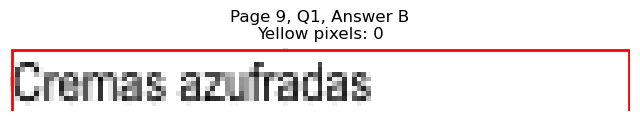

Page 9, Q1 - C: Detected box: x0=68.8, y0=139.9, x1=115.5, y1=152.6
Page 9, Q1, C: Yellow pixels: 1076
Page 9, Q1, C: Total non-white pixels: 1372
Page 9, Q1, C: Yellow percentage: 78.4%


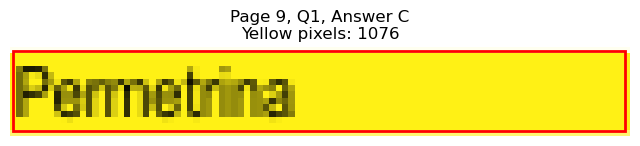

Page 9, Q1 - D: Detected box: x0=327.5, y0=114.6, x1=422.8, y1=127.3
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 500
Page 9, Q1, D: Yellow percentage: 0.0%


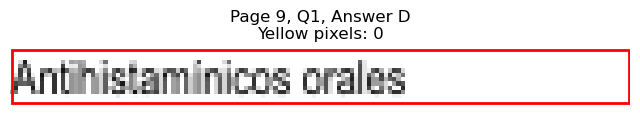

Page 9, Q1 - E: Detected box: x0=327.0, y0=127.2, x1=372.2, y1=139.9
Page 9, Q1, E: Yellow pixels: 0
Page 9, Q1, E: Total non-white pixels: 253
Page 9, Q1, E: Yellow percentage: 0.0%


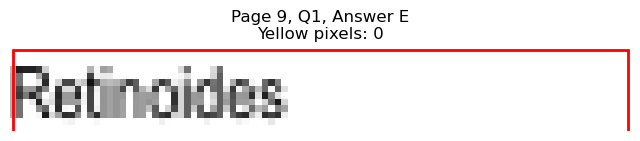


Page 9, Q1 - Selected Answer: C (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=215.7, x1=101.9, y1=228.3
Page 9, Q2, A: Yellow pixels: 84
Page 9, Q2, A: Total non-white pixels: 283
Page 9, Q2, A: Yellow percentage: 29.7%


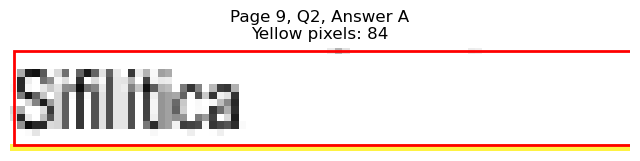

Page 9, Q2 - B: Detected box: x0=68.3, y0=228.3, x1=120.5, y1=240.9
Page 9, Q2, B: Yellow pixels: 1144
Page 9, Q2, B: Total non-white pixels: 1339
Page 9, Q2, B: Yellow percentage: 85.4%


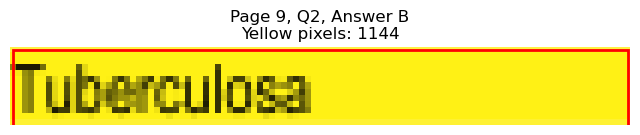

Page 9, Q2 - C: Detected box: x0=68.8, y0=240.9, x1=89.3, y1=253.5
Page 9, Q2, C: Yellow pixels: 72
Page 9, Q2, C: Total non-white pixels: 174
Page 9, Q2, C: Yellow percentage: 41.4%


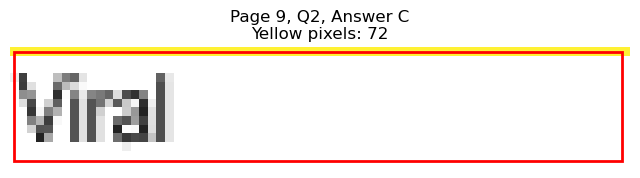

Page 9, Q2 - D: Detected box: x0=327.5, y0=215.7, x1=373.1, y1=228.3
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 244
Page 9, Q2, D: Yellow percentage: 0.0%


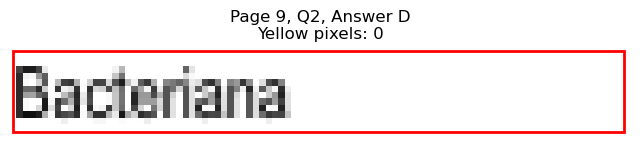

Page 9, Q2 - E: Detected box: x0=327.0, y0=228.3, x1=388.7, y1=240.9
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 303
Page 9, Q2, E: Yellow percentage: 0.0%


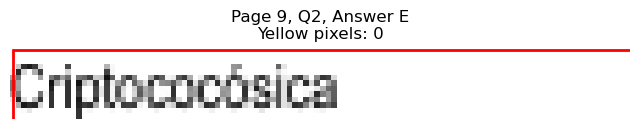


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=304.0, x1=121.0, y1=316.7
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 274
Page 9, Q3, A: Yellow percentage: 0.0%


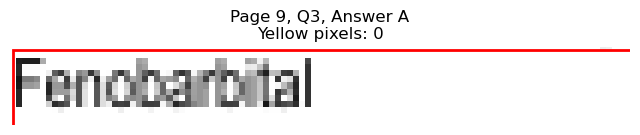

Page 9, Q3 - B: Detected box: x0=68.3, y0=316.6, x1=132.0, y1=329.3
Page 9, Q3, B: Yellow pixels: 115
Page 9, Q3, B: Total non-white pixels: 445
Page 9, Q3, B: Yellow percentage: 25.8%


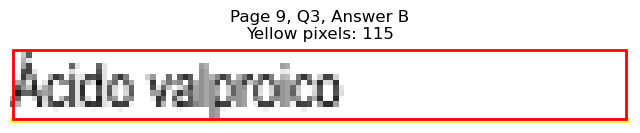

Page 9, Q3 - C: Detected box: x0=68.8, y0=329.2, x1=135.1, y1=341.9
Page 9, Q3, C: Yellow pixels: 1281
Page 9, Q3, C: Total non-white pixels: 1534
Page 9, Q3, C: Yellow percentage: 83.5%


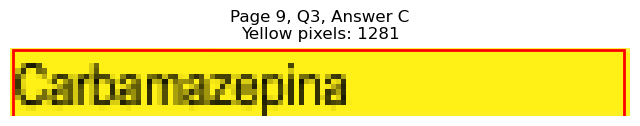

Page 9, Q3 - D: Detected box: x0=327.5, y0=304.0, x1=375.7, y1=316.7
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 250
Page 9, Q3, D: Yellow percentage: 0.0%


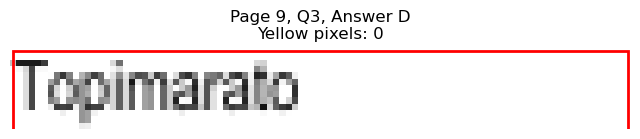

Page 9, Q3 - E: Detected box: x0=327.0, y0=316.6, x1=381.3, y1=329.3
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 298
Page 9, Q3, E: Yellow percentage: 0.0%


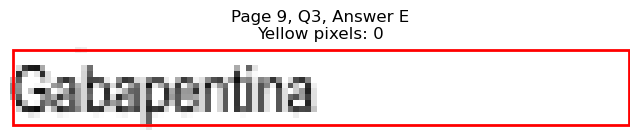


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=367.1, x1=199.1, y1=379.8
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 848
Page 9, Q4, A: Yellow percentage: 0.0%


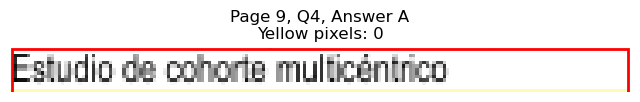

Page 9, Q4 - B: Detected box: x0=68.3, y0=379.7, x1=121.0, y1=392.4
Page 9, Q4, B: Yellow pixels: 1020
Page 9, Q4, B: Total non-white pixels: 1442
Page 9, Q4, B: Yellow percentage: 70.7%


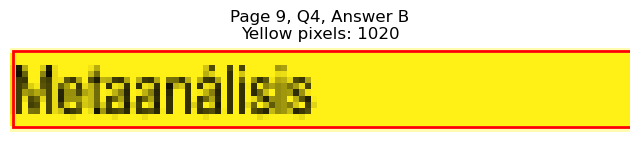

Page 9, Q4 - C: Detected box: x0=68.8, y0=392.3, x1=151.1, y1=405.0
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 556
Page 9, Q4, C: Yellow percentage: 0.0%


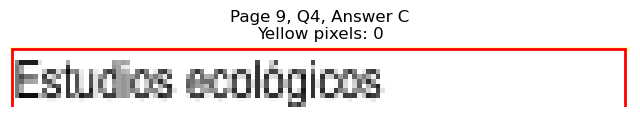

Page 9, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=484.1, y1=379.8
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 736
Page 9, Q4, D: Yellow percentage: 0.0%


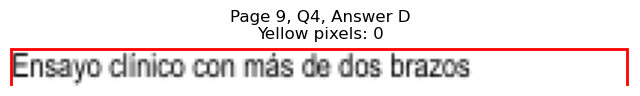

Page 9, Q4 - E: Detected box: x0=327.0, y0=379.7, x1=411.8, y1=392.4
Page 9, Q4, E: Yellow pixels: 0
Page 9, Q4, E: Total non-white pixels: 449
Page 9, Q4, E: Yellow percentage: 0.0%


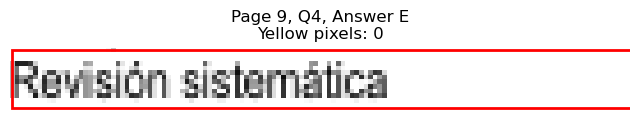


Page 9, Q4 - Selected Answer: B (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=455.5, x1=175.6, y1=468.1
Page 9, Q5, A: Yellow pixels: 1658
Page 9, Q5, A: Total non-white pixels: 2212
Page 9, Q5, A: Yellow percentage: 75.0%


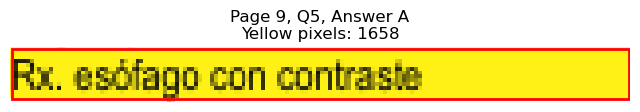

Page 9, Q5 - B: Detected box: x0=68.3, y0=468.1, x1=152.1, y1=480.7
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 539
Page 9, Q5, B: Yellow percentage: 0.0%


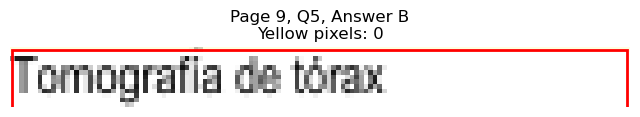

Page 9, Q5 - C: Detected box: x0=68.8, y0=480.8, x1=141.5, y1=493.4
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 384
Page 9, Q5, C: Yellow percentage: 0.0%


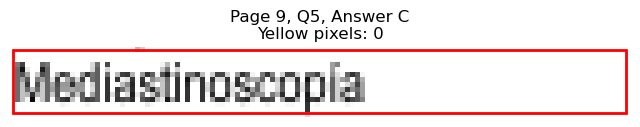

Page 9, Q5 - D: Detected box: x0=327.5, y0=455.5, x1=384.8, y1=468.1
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 282
Page 9, Q5, D: Yellow percentage: 0.0%


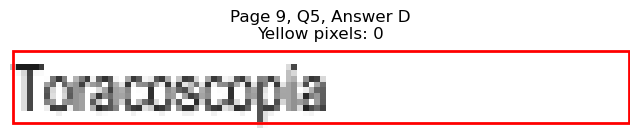

Page 9, Q5 - E: Detected box: x0=327.0, y0=468.1, x1=406.7, y1=480.7
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 378
Page 9, Q5, E: Yellow percentage: 0.0%


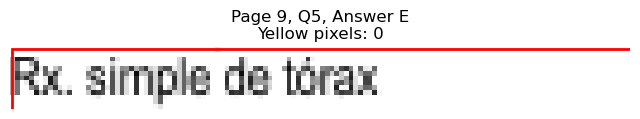


Page 9, Q5 - Selected Answer: A (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=543.8, x1=122.4, y1=556.4
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 302
Page 9, Q6, A: Yellow percentage: 0.0%


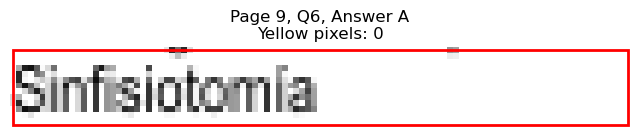

Page 9, Q6 - B: Detected box: x0=68.3, y0=556.5, x1=118.9, y1=569.2
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 271
Page 9, Q6, B: Yellow percentage: 0.0%


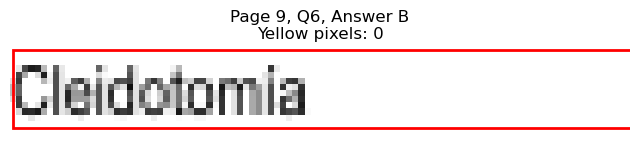

Page 9, Q6 - C: Detected box: x0=68.8, y0=569.1, x1=147.0, y1=581.8
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 399
Page 9, Q6, C: Yellow percentage: 0.0%


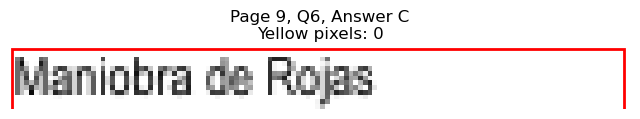

Page 9, Q6 - D: Detected box: x0=327.5, y0=543.8, x1=418.9, y1=556.4
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 467
Page 9, Q6, D: Yellow percentage: 0.0%


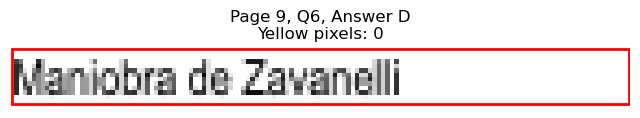

Page 9, Q6 - E: Detected box: x0=327.0, y0=556.5, x1=449.0, y1=569.2
Page 9, Q6, E: Yellow pixels: 1770
Page 9, Q6, E: Total non-white pixels: 2408
Page 9, Q6, E: Yellow percentage: 73.5%


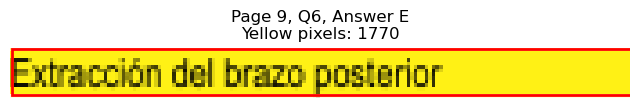


Page 9, Q6 - Selected Answer: E (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=606.9, x1=184.7, y1=619.6
Page 9, Q7, A: Yellow pixels: 1681
Page 9, Q7, A: Total non-white pixels: 2338
Page 9, Q7, A: Yellow percentage: 71.9%


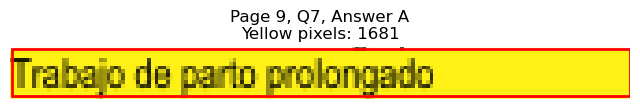

Page 9, Q7 - B: Detected box: x0=68.3, y0=619.6, x1=139.0, y1=632.3
Page 9, Q7, B: Yellow pixels: 119
Page 9, Q7, B: Total non-white pixels: 455
Page 9, Q7, B: Yellow percentage: 26.2%


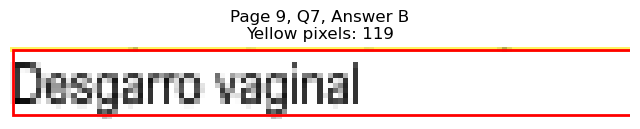

Page 9, Q7 - C: Detected box: x0=68.8, y0=632.2, x1=93.4, y1=644.9
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 124
Page 9, Q7, C: Yellow percentage: 0.0%


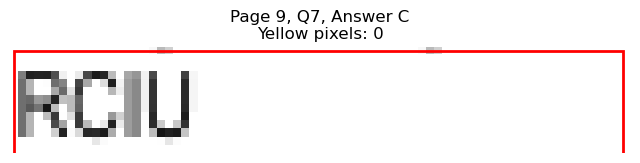

Page 9, Q7 - D: Detected box: x0=327.5, y0=606.9, x1=422.3, y1=619.6
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 496
Page 9, Q7, D: Yellow percentage: 0.0%


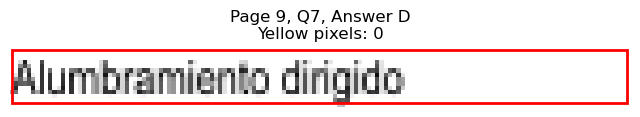

Page 9, Q7 - E: Detected box: x0=327.0, y0=619.6, x1=383.7, y1=632.3
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 301
Page 9, Q7, E: Yellow percentage: 0.0%


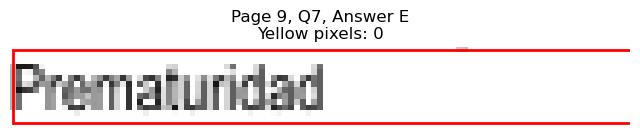


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=682.7, x1=121.5, y1=695.3
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 275
Page 9, Q8, A: Yellow percentage: 0.0%


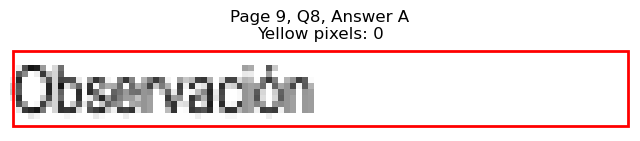

Page 9, Q8 - B: Detected box: x0=68.3, y0=695.4, x1=130.5, y1=708.0
Page 9, Q8, B: Yellow pixels: 1253
Page 9, Q8, B: Total non-white pixels: 1470
Page 9, Q8, B: Yellow percentage: 85.2%


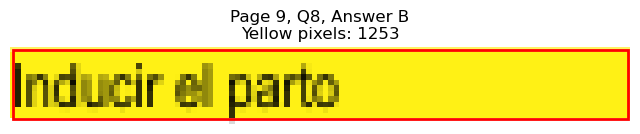

Page 9, Q8 - C: Detected box: x0=68.8, y0=708.0, x1=214.2, y1=720.6
Page 9, Q8, C: Yellow pixels: 196
Page 9, Q8, C: Total non-white pixels: 881
Page 9, Q8, C: Yellow percentage: 22.2%


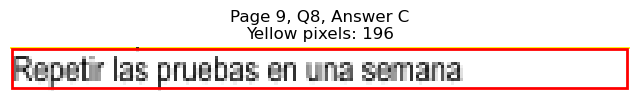

Page 9, Q8 - D: Detected box: x0=327.5, y0=682.7, x1=427.9, y1=695.3
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 491
Page 9, Q8, D: Yellow percentage: 0.0%


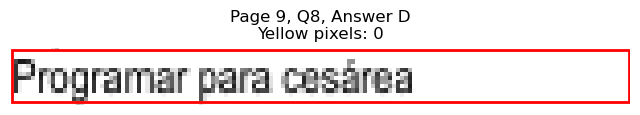

Page 9, Q8 - E: Detected box: x0=327.0, y0=695.4, x1=398.8, y1=708.0
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 351
Page 9, Q8, E: Yellow percentage: 0.0%


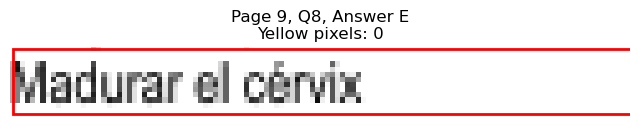


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 8 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=122.4, y1=139.9
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 259
Page 10, Q1, A: Yellow percentage: 0.0%


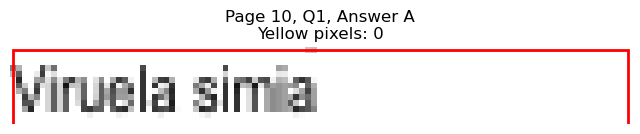

Page 10, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=144.5, y1=152.6
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 386
Page 10, Q1, B: Yellow percentage: 0.0%


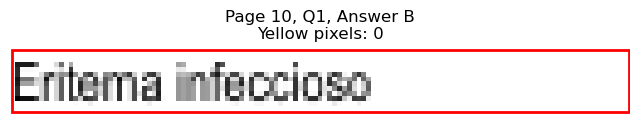

Page 10, Q1 - C: Detected box: x0=68.8, y0=152.5, x1=177.7, y1=165.2
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 589
Page 10, Q1, C: Yellow percentage: 0.0%


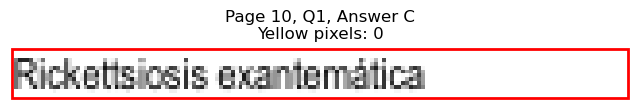

Page 10, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=362.7, y1=139.9
Page 10, Q1, D: Yellow pixels: 988
Page 10, Q1, D: Total non-white pixels: 1118
Page 10, Q1, D: Yellow percentage: 88.4%


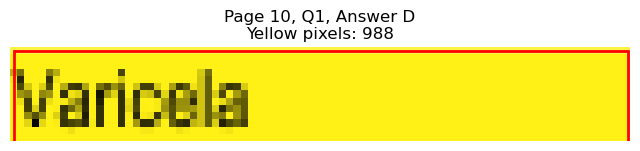

Page 10, Q1 - E: Detected box: x0=327.0, y0=139.9, x1=391.3, y1=152.6
Page 10, Q1, E: Yellow pixels: 115
Page 10, Q1, E: Total non-white pixels: 460
Page 10, Q1, E: Yellow percentage: 25.0%


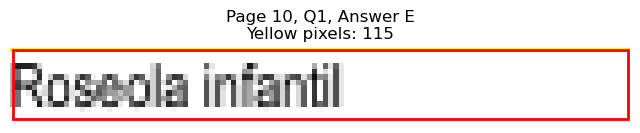


Page 10, Q1 - Selected Answer: D (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=215.7, x1=80.9, y1=228.3
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 51
Page 10, Q2, A: Yellow percentage: 0.0%


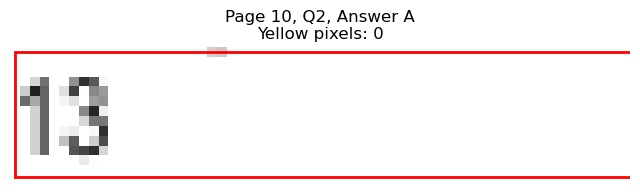

Page 10, Q2 - B: Detected box: x0=56.6, y0=228.3, x1=65.2, y1=240.9
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 76
Page 10, Q2, B: Yellow percentage: 0.0%


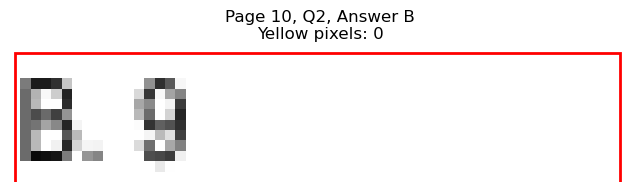

Page 10, Q2 - C: Detected box: x0=68.8, y0=240.9, x1=81.4, y1=253.5
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 45
Page 10, Q2, C: Yellow percentage: 0.0%


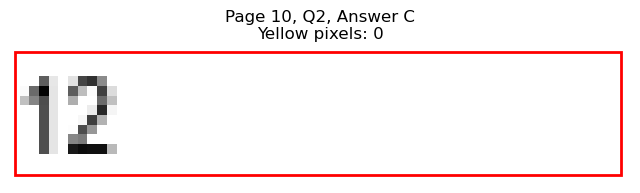

Page 10, Q2 - D: Detected box: x0=315.4, y0=215.7, x1=324.4, y1=228.3
Page 10, Q2, D: Yellow pixels: 60
Page 10, Q2, D: Total non-white pixels: 133
Page 10, Q2, D: Yellow percentage: 45.1%


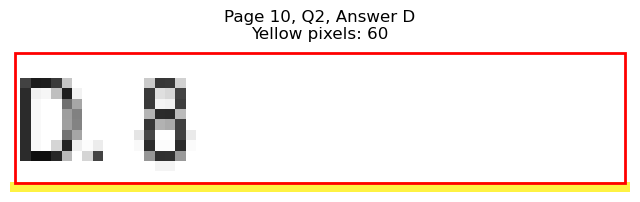

Page 10, Q2 - E: Detected box: x0=327.0, y0=228.3, x1=339.7, y1=240.9
Page 10, Q2, E: Yellow pixels: 771
Page 10, Q2, E: Total non-white pixels: 819
Page 10, Q2, E: Yellow percentage: 94.1%


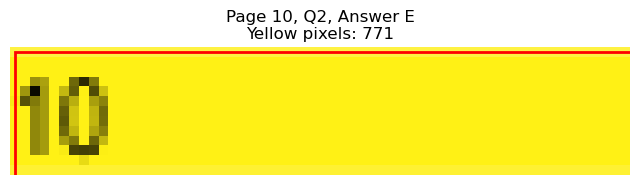


Page 10, Q2 - Selected Answer: E (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=291.4, x1=199.2, y1=304.1
Page 10, Q3, A: Yellow pixels: 182
Page 10, Q3, A: Total non-white pixels: 817
Page 10, Q3, A: Yellow percentage: 22.3%


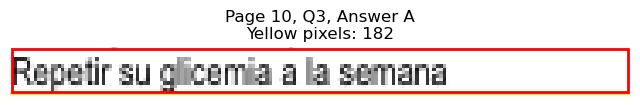

Page 10, Q3 - B: Detected box: x0=68.3, y0=304.0, x1=247.4, y1=316.7
Page 10, Q3, B: Yellow pixels: 2075
Page 10, Q3, B: Total non-white pixels: 2782
Page 10, Q3, B: Yellow percentage: 74.6%


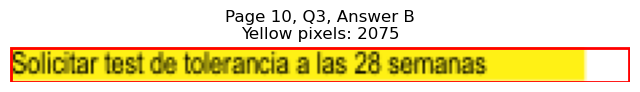

Page 10, Q3 - C: Detected box: x0=68.8, y0=316.6, x1=234.4, y1=329.3
Page 10, Q3, C: Yellow pixels: 213
Page 10, Q3, C: Total non-white pixels: 1003
Page 10, Q3, C: Yellow percentage: 21.2%


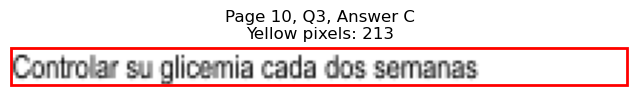

Page 10, Q3 - D: Detected box: x0=327.5, y0=291.4, x1=459.4, y1=304.1
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 674
Page 10, Q3, D: Yellow percentage: 0.0%


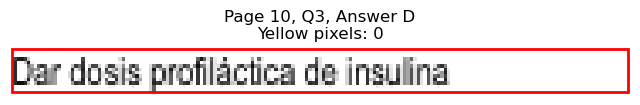

Page 10, Q3 - E: Detected box: x0=327.0, y0=304.0, x1=492.6, y1=316.7
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 760
Page 10, Q3, E: Yellow percentage: 0.0%


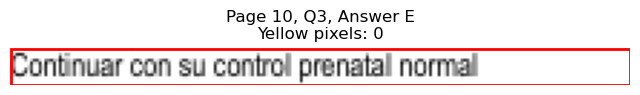


Page 10, Q3 - Selected Answer: B (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=392.3, x1=127.5, y1=405.0
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 315
Page 10, Q4, A: Yellow percentage: 0.0%


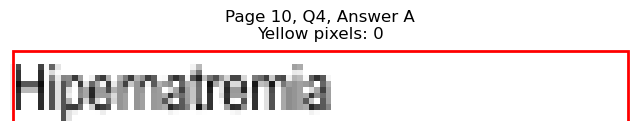

Page 10, Q4 - B: Detected box: x0=68.3, y0=404.9, x1=127.9, y1=417.6
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 306
Page 10, Q4, B: Yellow percentage: 0.0%


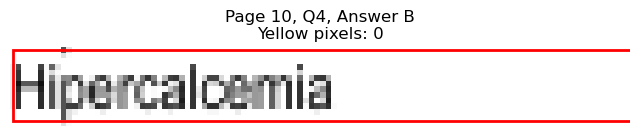

Page 10, Q4 - C: Detected box: x0=68.8, y0=417.6, x1=124.0, y1=430.3
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 290
Page 10, Q4, C: Yellow percentage: 0.0%


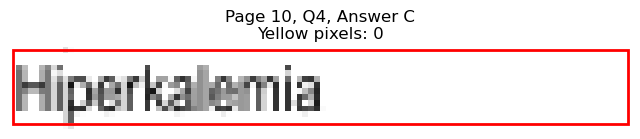

Page 10, Q4 - D: Detected box: x0=327.5, y0=392.3, x1=384.2, y1=405.0
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 412
Page 10, Q4, D: Yellow percentage: 0.0%


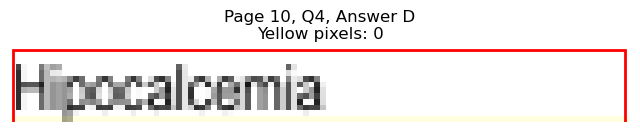

Page 10, Q4 - E: Detected box: x0=327.0, y0=404.9, x1=379.3, y1=417.6
Page 10, Q4, E: Yellow pixels: 1128
Page 10, Q4, E: Total non-white pixels: 1442
Page 10, Q4, E: Yellow percentage: 78.2%


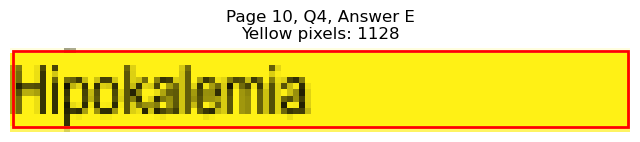


Page 10, Q4 - Selected Answer: E (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=480.8, x1=116.9, y1=493.4
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 266
Page 10, Q5, A: Yellow percentage: 0.0%


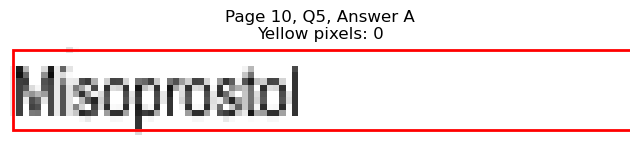

Page 10, Q5 - B: Detected box: x0=68.3, y0=493.4, x1=121.5, y1=506.0
Page 10, Q5, B: Yellow pixels: 104
Page 10, Q5, B: Total non-white pixels: 490
Page 10, Q5, B: Yellow percentage: 21.2%


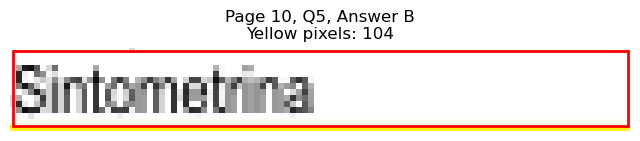

Page 10, Q5 - C: Detected box: x0=68.8, y0=506.0, x1=108.9, y1=518.6
Page 10, Q5, C: Yellow pixels: 1040
Page 10, Q5, C: Total non-white pixels: 1274
Page 10, Q5, C: Yellow percentage: 81.6%


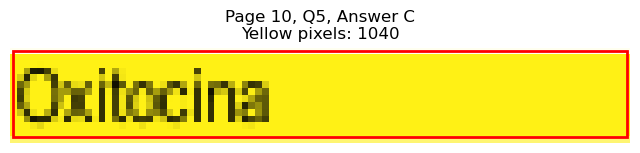

Page 10, Q5 - D: Detected box: x0=327.5, y0=480.8, x1=379.1, y1=493.4
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 261
Page 10, Q5, D: Yellow percentage: 0.0%


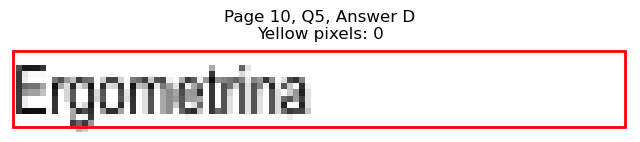

Page 10, Q5 - E: Detected box: x0=327.0, y0=493.4, x1=374.2, y1=506.0
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 228
Page 10, Q5, E: Yellow percentage: 0.0%


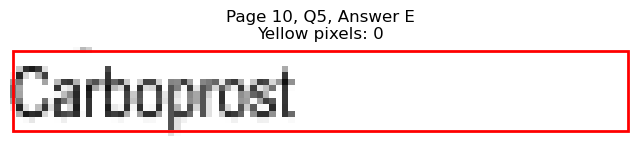


Page 10, Q5 - Selected Answer: C (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=569.1, x1=118.0, y1=581.8
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 268
Page 10, Q6, A: Yellow percentage: 0.0%


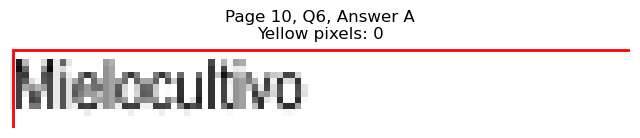

Page 10, Q6 - B: Detected box: x0=68.3, y0=581.7, x1=120.5, y1=594.4
Page 10, Q6, B: Yellow pixels: 103
Page 10, Q6, B: Total non-white pixels: 355
Page 10, Q6, B: Yellow percentage: 29.0%


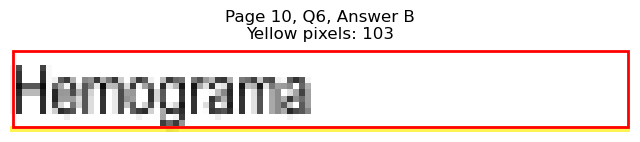

Page 10, Q6 - C: Detected box: x0=68.8, y0=594.3, x1=157.6, y1=607.0
Page 10, Q6, C: Yellow pixels: 1467
Page 10, Q6, C: Total non-white pixels: 1820
Page 10, Q6, C: Yellow percentage: 80.6%


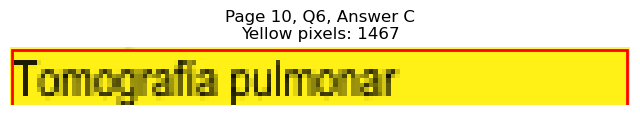

Page 10, Q6 - D: Detected box: x0=327.5, y0=569.1, x1=399.8, y1=581.8
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 360
Page 10, Q6, D: Yellow percentage: 0.0%


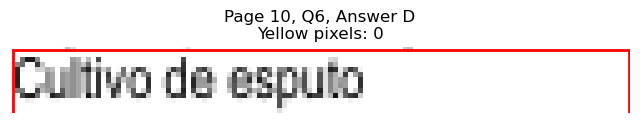

Page 10, Q6 - E: Detected box: x0=327.0, y0=581.7, x1=426.9, y1=594.4
Page 10, Q6, E: Yellow pixels: 0
Page 10, Q6, E: Total non-white pixels: 533
Page 10, Q6, E: Yellow percentage: 0.0%


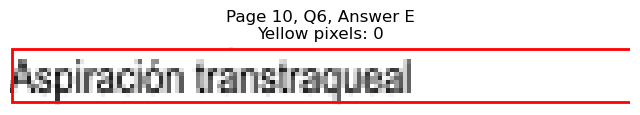


Page 10, Q6 - Selected Answer: C (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=657.5, x1=130.9, y1=670.1
Page 10, Q7, A: Yellow pixels: 113
Page 10, Q7, A: Total non-white pixels: 436
Page 10, Q7, A: Yellow percentage: 25.9%


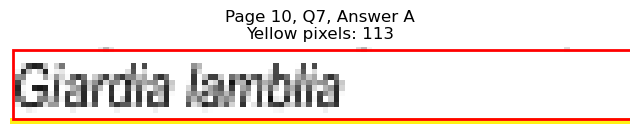

Page 10, Q7 - B: Detected box: x0=68.3, y0=670.1, x1=146.1, y1=682.7
Page 10, Q7, B: Yellow pixels: 1360
Page 10, Q7, B: Total non-white pixels: 1677
Page 10, Q7, B: Yellow percentage: 81.1%


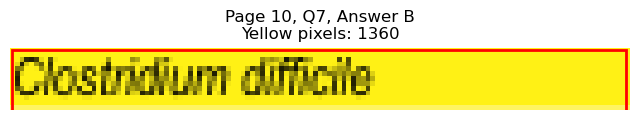

Page 10, Q7 - C: Detected box: x0=68.8, y0=682.7, x1=153.0, y1=695.3
Page 10, Q7, C: Yellow pixels: 136
Page 10, Q7, C: Total non-white pixels: 580
Page 10, Q7, C: Yellow percentage: 23.4%


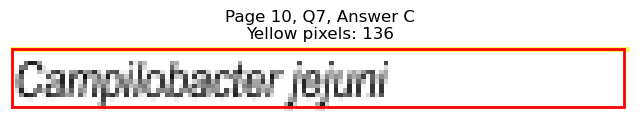

Page 10, Q7 - D: Detected box: x0=327.5, y0=657.5, x1=392.7, y1=670.1
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 331
Page 10, Q7, D: Yellow percentage: 0.0%


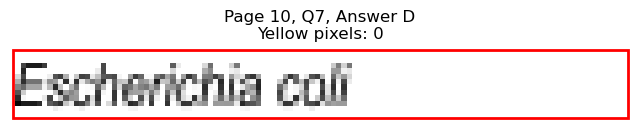

Page 10, Q7 - E: Detected box: x0=327.0, y0=670.1, x1=417.9, y1=682.7
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 470
Page 10, Q7, E: Yellow percentage: 0.0%


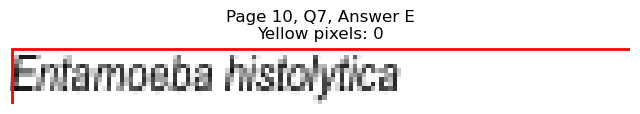


Page 10, Q7 - Selected Answer: B (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=68.3, y0=733.2, x1=164.1, y1=745.8
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 492
Page 10, Q8, A: Yellow percentage: 0.0%


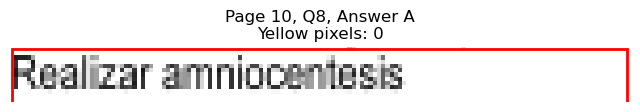

Page 10, Q8 - B: Detected box: x0=68.3, y0=745.8, x1=198.6, y1=758.4
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 689
Page 10, Q8, B: Yellow percentage: 0.0%


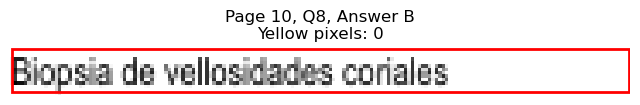

Page 10, Q8 - C: Detected box: x0=68.8, y0=758.5, x1=136.1, y1=771.2
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 306
Page 10, Q8, C: Yellow percentage: 0.0%


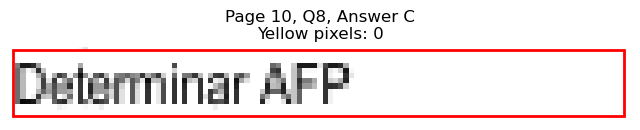

Page 10, Q8 - D: Detected box: x0=327.5, y0=733.2, x1=478.1, y1=745.8
Page 10, Q8, D: Yellow pixels: 1
Page 10, Q8, D: Total non-white pixels: 908
Page 10, Q8, D: Yellow percentage: 0.1%


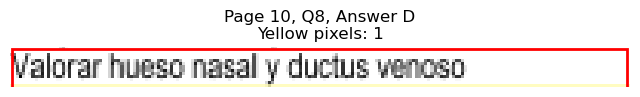

Page 10, Q8 - E: Detected box: x0=327.0, y0=745.8, x1=444.4, y1=758.4
Page 10, Q8, E: Yellow pixels: 1748
Page 10, Q8, E: Total non-white pixels: 2352
Page 10, Q8, E: Yellow percentage: 74.3%


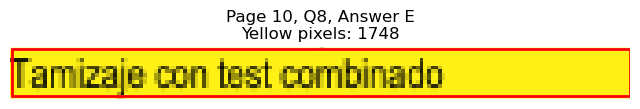


Page 10, Q8 - Selected Answer: E (based on yellow pixel count)





Page 11: Found 8 questions
Page 11, Q1 - A: Detected box: x0=68.3, y0=89.4, x1=208.2, y1=102.1
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 724
Page 11, Q1, A: Yellow percentage: 0.0%


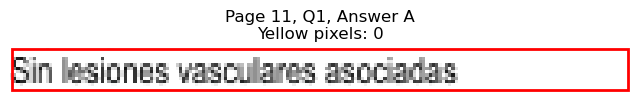

Page 11, Q1 - B: Detected box: x0=68.3, y0=102.0, x1=258.0, y1=114.7
Page 11, Q1, B: Yellow pixels: 2
Page 11, Q1, B: Total non-white pixels: 1172
Page 11, Q1, B: Yellow percentage: 0.2%


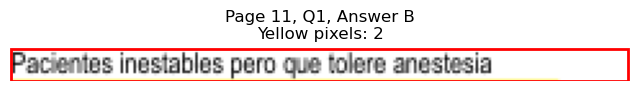

Page 11, Q1 - C: Detected box: x0=68.8, y0=114.6, x1=104.4, y1=127.3
Page 11, Q1, C: Yellow pixels: 899
Page 11, Q1, C: Total non-white pixels: 1218
Page 11, Q1, C: Yellow percentage: 73.8%


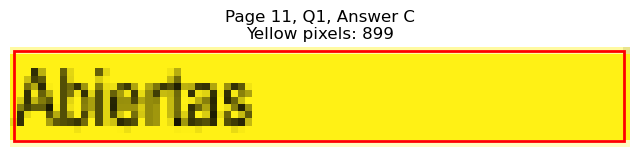

Page 11, Q1 - D: Detected box: x0=327.5, y0=89.4, x1=521.1, y1=102.1
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 966
Page 11, Q1, D: Yellow percentage: 0.0%


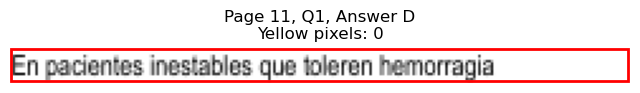

Page 11, Q1 - E: Detected box: x0=327.0, y0=102.0, x1=540.9, y1=114.7
Page 11, Q1, E: Yellow pixels: 0
Page 11, Q1, E: Total non-white pixels: 1082
Page 11, Q1, E: Yellow percentage: 0.0%


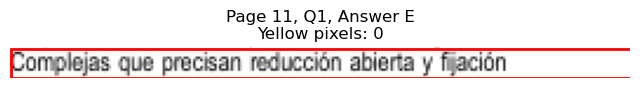


Page 11, Q1 - Selected Answer: C (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=134.5, y1=177.8
Page 11, Q2, A: Yellow pixels: 1266
Page 11, Q2, A: Total non-white pixels: 1521
Page 11, Q2, A: Yellow percentage: 83.2%


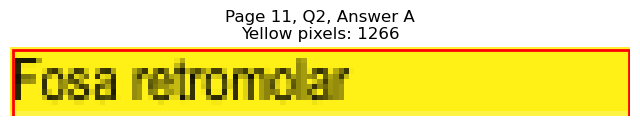

Page 11, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=124.9, y1=190.4
Page 11, Q2, B: Yellow pixels: 107
Page 11, Q2, B: Total non-white pixels: 412
Page 11, Q2, B: Yellow percentage: 26.0%


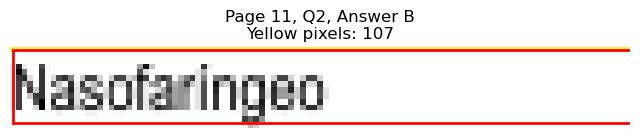

Page 11, Q2 - C: Detected box: x0=68.8, y0=190.3, x1=152.5, y1=203.0
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 437
Page 11, Q2, C: Yellow percentage: 0.0%


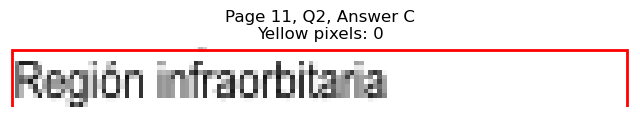

Page 11, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=408.3, y1=177.8
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 403
Page 11, Q2, D: Yellow percentage: 0.0%


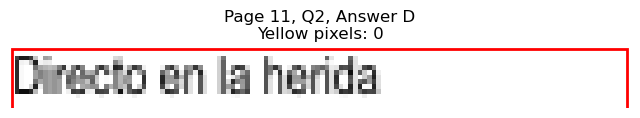

Page 11, Q2 - E: Detected box: x0=327.0, y0=177.7, x1=393.8, y1=190.4
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 349
Page 11, Q2, E: Yellow percentage: 0.0%


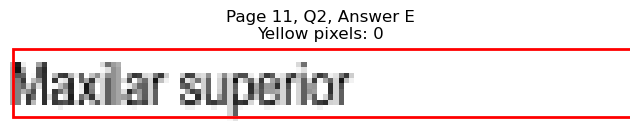


Page 11, Q2 - Selected Answer: A (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=166.6, y1=266.1
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 480
Page 11, Q3, A: Yellow percentage: 0.0%


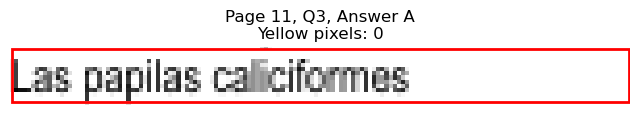

Page 11, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=150.1, y1=278.7
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 411
Page 11, Q3, B: Yellow percentage: 0.0%


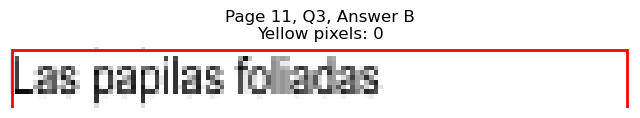

Page 11, Q3 - C: Detected box: x0=68.8, y0=278.8, x1=166.7, y1=291.5
Page 11, Q3, C: Yellow pixels: 1531
Page 11, Q3, C: Total non-white pixels: 2086
Page 11, Q3, C: Yellow percentage: 73.4%


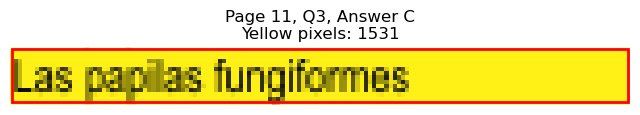

Page 11, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=420.3, y1=266.1
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 451
Page 11, Q3, D: Yellow percentage: 0.0%


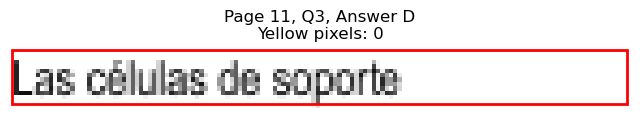

Page 11, Q3 - E: Detected box: x0=327.0, y0=266.1, x1=418.4, y1=278.7
Page 11, Q3, E: Yellow pixels: 0
Page 11, Q3, E: Total non-white pixels: 476
Page 11, Q3, E: Yellow percentage: 0.0%


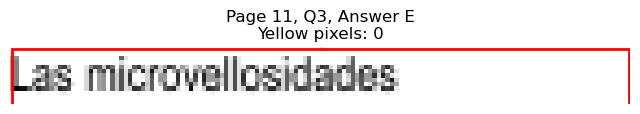


Page 11, Q3 - Selected Answer: C (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=68.3, y0=367.1, x1=110.4, y1=379.8
Page 11, Q4, A: Yellow pixels: 1039
Page 11, Q4, A: Total non-white pixels: 1209
Page 11, Q4, A: Yellow percentage: 85.9%


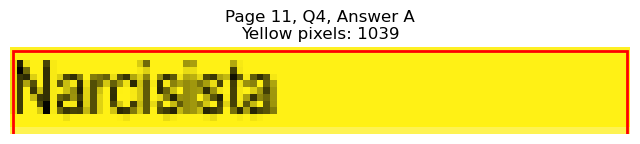

Page 11, Q4 - B: Detected box: x0=68.3, y0=379.7, x1=112.9, y1=392.4
Page 11, Q4, B: Yellow pixels: 95
Page 11, Q4, B: Total non-white pixels: 339
Page 11, Q4, B: Yellow percentage: 28.0%


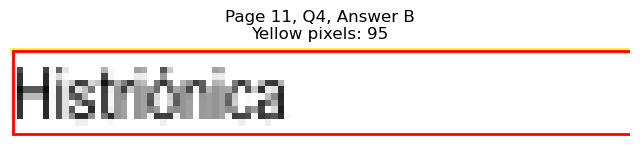

Page 11, Q4 - C: Detected box: x0=68.8, y0=392.3, x1=108.9, y1=405.0
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 209
Page 11, Q4, C: Yellow percentage: 0.0%


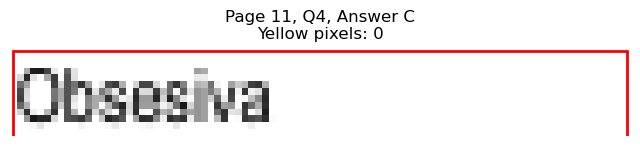

Page 11, Q4 - D: Detected box: x0=327.5, y0=367.1, x1=383.7, y1=379.8
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 308
Page 11, Q4, D: Yellow percentage: 0.0%


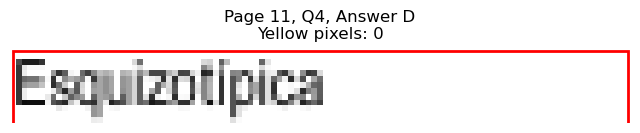

Page 11, Q4 - E: Detected box: x0=327.0, y0=379.7, x1=368.2, y1=392.4
Page 11, Q4, E: Yellow pixels: 0
Page 11, Q4, E: Total non-white pixels: 216
Page 11, Q4, E: Yellow percentage: 0.0%


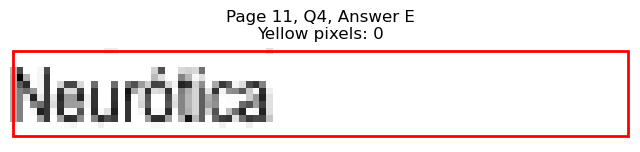


Page 11, Q4 - Selected Answer: A (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=68.3, y0=455.5, x1=214.7, y1=468.1
Page 11, Q5, A: Yellow pixels: 1976
Page 11, Q5, A: Total non-white pixels: 2758
Page 11, Q5, A: Yellow percentage: 71.6%


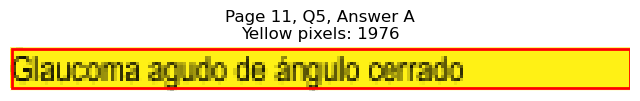

Page 11, Q5 - B: Detected box: x0=68.3, y0=468.1, x1=158.5, y1=480.7
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 608
Page 11, Q5, B: Yellow percentage: 0.0%


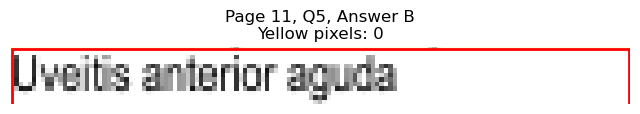

Page 11, Q5 - C: Detected box: x0=68.8, y0=480.8, x1=161.5, y1=493.4
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 478
Page 11, Q5, C: Yellow percentage: 0.0%


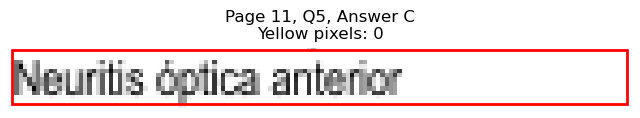

Page 11, Q5 - D: Detected box: x0=327.5, y0=455.5, x1=435.9, y1=468.1
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 547
Page 11, Q5, D: Yellow percentage: 0.0%


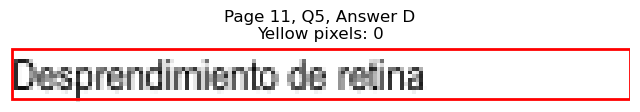

Page 11, Q5 - E: Detected box: x0=327.0, y0=468.1, x1=470.5, y1=480.7
Page 11, Q5, E: Yellow pixels: 0
Page 11, Q5, E: Total non-white pixels: 736
Page 11, Q5, E: Yellow percentage: 0.0%


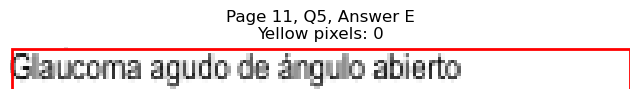


Page 11, Q5 - Selected Answer: A (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=68.3, y0=543.8, x1=180.6, y1=556.4
Page 11, Q6, A: Yellow pixels: 1687
Page 11, Q6, A: Total non-white pixels: 2282
Page 11, Q6, A: Yellow percentage: 73.9%


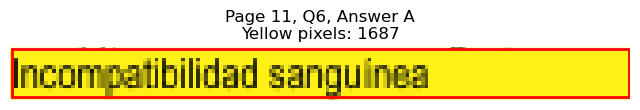

Page 11, Q6 - B: Detected box: x0=68.3, y0=556.5, x1=156.6, y1=569.2
Page 11, Q6, B: Yellow pixels: 137
Page 11, Q6, B: Total non-white pixels: 594
Page 11, Q6, B: Yellow percentage: 23.1%


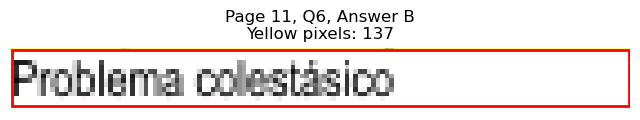

Page 11, Q6 - C: Detected box: x0=68.8, y0=569.1, x1=131.5, y1=581.8
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 288
Page 11, Q6, C: Yellow percentage: 0.0%


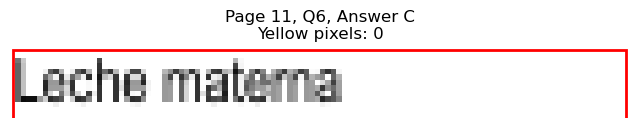

Page 11, Q6 - D: Detected box: x0=327.5, y0=543.8, x1=384.2, y1=556.4
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 289
Page 11, Q6, D: Yellow percentage: 0.0%


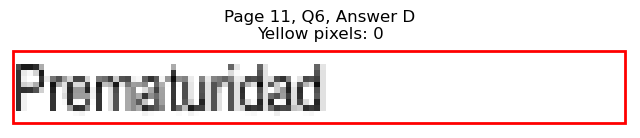

Page 11, Q6 - E: Detected box: x0=327.0, y0=556.5, x1=393.3, y1=569.2
Page 11, Q6, E: Yellow pixels: 0
Page 11, Q6, E: Total non-white pixels: 339
Page 11, Q6, E: Yellow percentage: 0.0%


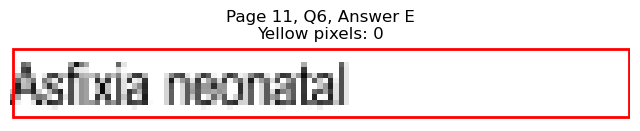


Page 11, Q6 - Selected Answer: A (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=68.3, y0=619.6, x1=159.6, y1=632.3
Page 11, Q7, A: Yellow pixels: 0
Page 11, Q7, A: Total non-white pixels: 468
Page 11, Q7, A: Yellow percentage: 0.0%


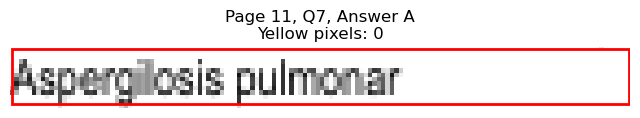

Page 11, Q7 - B: Detected box: x0=68.3, y0=632.2, x1=172.1, y1=644.9
Page 11, Q7, B: Yellow pixels: 0
Page 11, Q7, B: Total non-white pixels: 490
Page 11, Q7, B: Yellow percentage: 0.0%


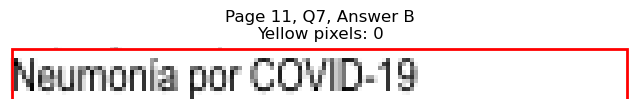

Page 11, Q7 - C: Detected box: x0=68.8, y0=644.9, x1=139.5, y1=657.5
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 355
Page 11, Q7, C: Yellow percentage: 0.0%


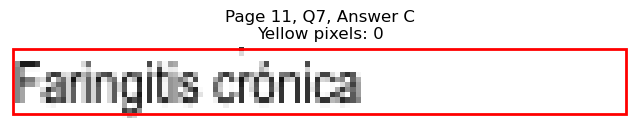

Page 11, Q7 - D: Detected box: x0=327.5, y0=619.6, x1=421.3, y1=632.3
Page 11, Q7, D: Yellow pixels: 1379
Page 11, Q7, D: Total non-white pixels: 2030
Page 11, Q7, D: Yellow percentage: 67.9%


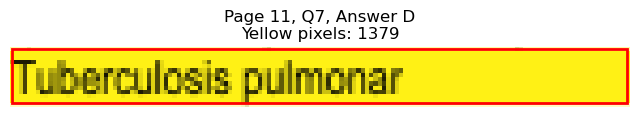

Page 11, Q7 - E: Detected box: x0=327.0, y0=632.2, x1=401.3, y1=644.9
Page 11, Q7, E: Yellow pixels: 0
Page 11, Q7, E: Total non-white pixels: 507
Page 11, Q7, E: Yellow percentage: 0.0%


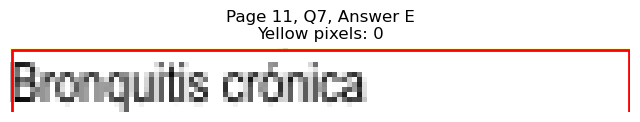


Page 11, Q7 - Selected Answer: D (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=68.3, y0=708.0, x1=120.5, y1=720.6
Page 11, Q8, A: Yellow pixels: 0
Page 11, Q8, A: Total non-white pixels: 291
Page 11, Q8, A: Yellow percentage: 0.0%


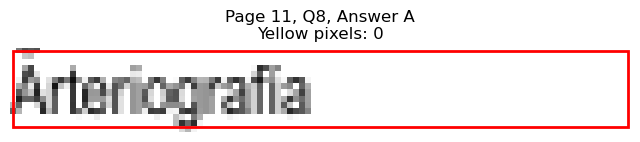

Page 11, Q8 - B: Detected box: x0=68.3, y0=720.6, x1=116.9, y1=733.2
Page 11, Q8, B: Yellow pixels: 0
Page 11, Q8, B: Total non-white pixels: 237
Page 11, Q8, B: Yellow percentage: 0.0%


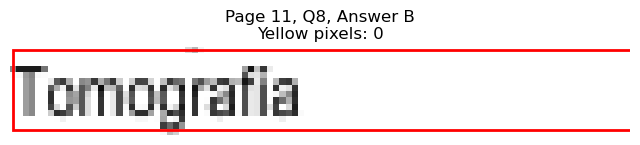

Page 11, Q8 - C: Detected box: x0=68.8, y0=733.2, x1=163.1, y1=745.8
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 478
Page 11, Q8, C: Yellow percentage: 0.0%


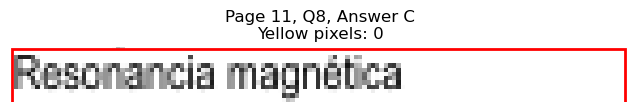

Page 11, Q8 - D: Detected box: x0=327.5, y0=708.0, x1=379.7, y1=720.6
Page 11, Q8, D: Yellow pixels: 1133
Page 11, Q8, D: Total non-white pixels: 1442
Page 11, Q8, D: Yellow percentage: 78.6%


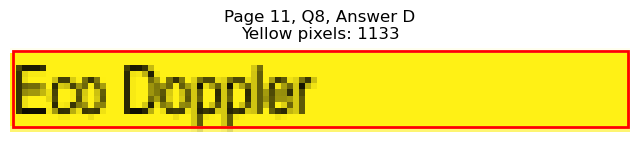

Page 11, Q8 - E: Detected box: x0=327.0, y0=720.6, x1=374.8, y1=733.2
Page 11, Q8, E: Yellow pixels: 98
Page 11, Q8, E: Total non-white pixels: 368
Page 11, Q8, E: Yellow percentage: 26.6%


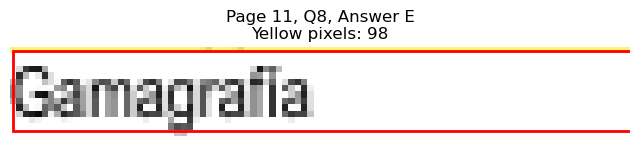


Page 11, Q8 - Selected Answer: D (based on yellow pixel count)





Page 12: Found 8 questions
Page 12, Q1 - A: Detected box: x0=68.3, y0=102.0, x1=148.0, y1=114.7
Page 12, Q1, A: Yellow pixels: 0
Page 12, Q1, A: Total non-white pixels: 375
Page 12, Q1, A: Yellow percentage: 0.0%


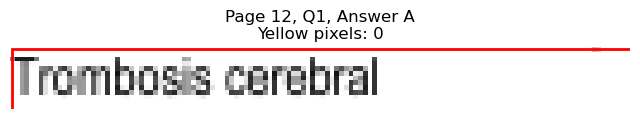

Page 12, Q1 - B: Detected box: x0=68.3, y0=114.6, x1=184.7, y1=127.3
Page 12, Q1, B: Yellow pixels: 0
Page 12, Q1, B: Total non-white pixels: 588
Page 12, Q1, B: Yellow percentage: 0.0%


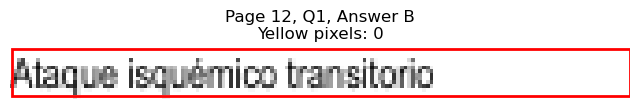

Page 12, Q1 - C: Detected box: x0=68.8, y0=127.2, x1=153.5, y1=139.9
Page 12, Q1, C: Yellow pixels: 0
Page 12, Q1, C: Total non-white pixels: 449
Page 12, Q1, C: Yellow percentage: 0.0%


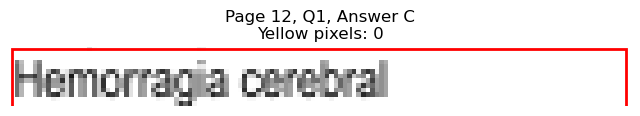

Page 12, Q1 - D: Detected box: x0=327.5, y0=102.0, x1=397.7, y1=114.7
Page 12, Q1, D: Yellow pixels: 1275
Page 12, Q1, D: Total non-white pixels: 1573
Page 12, Q1, D: Yellow percentage: 81.1%


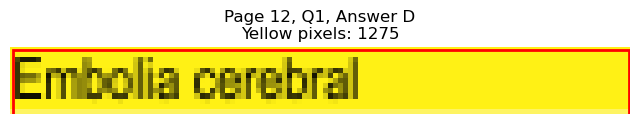

Page 12, Q1 - E: Detected box: x0=327.0, y0=114.6, x1=407.9, y1=127.3
Page 12, Q1, E: Yellow pixels: 131
Page 12, Q1, E: Total non-white pixels: 540
Page 12, Q1, E: Yellow percentage: 24.3%


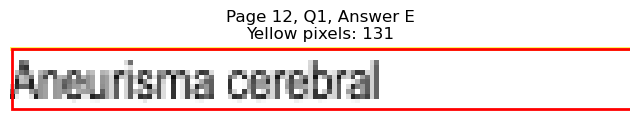


Page 12, Q1 - Selected Answer: D (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=68.3, y0=165.1, x1=171.6, y1=177.8
Page 12, Q2, A: Yellow pixels: 0
Page 12, Q2, A: Total non-white pixels: 696
Page 12, Q2, A: Yellow percentage: 0.0%


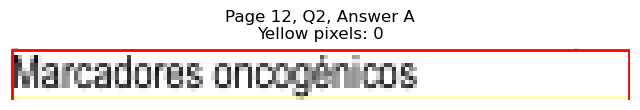

Page 12, Q2 - B: Detected box: x0=68.3, y0=177.7, x1=154.1, y1=190.4
Page 12, Q2, B: Yellow pixels: 1304
Page 12, Q2, B: Total non-white pixels: 1918
Page 12, Q2, B: Yellow percentage: 68.0%


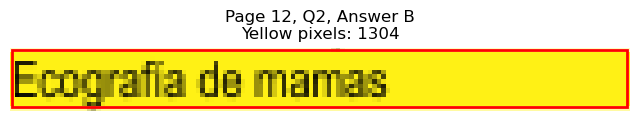

Page 12, Q2 - C: Detected box: x0=68.8, y0=190.3, x1=160.1, y1=203.0
Page 12, Q2, C: Yellow pixels: 1
Page 12, Q2, C: Total non-white pixels: 630
Page 12, Q2, C: Yellow percentage: 0.2%


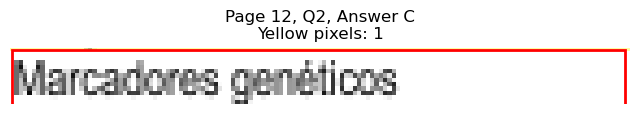

Page 12, Q2 - D: Detected box: x0=327.5, y0=165.1, x1=399.8, y1=177.8
Page 12, Q2, D: Yellow pixels: 0
Page 12, Q2, D: Total non-white pixels: 362
Page 12, Q2, D: Yellow percentage: 0.0%


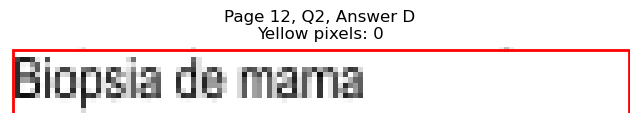

Page 12, Q2 - E: Detected box: x0=327.0, y0=506.0, x1=421.4, y1=518.6
Page 12, Q2, E: Yellow pixels: 0
Page 12, Q2, E: Total non-white pixels: 676
Page 12, Q2, E: Yellow percentage: 0.0%


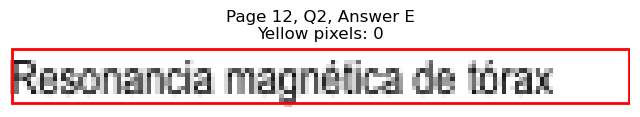


Page 12, Q2 - Selected Answer: B (based on yellow pixel count)




Page 12, Q3 - A: Detected box: x0=68.3, y0=253.5, x1=251.4, y1=266.1
Page 12, Q3, A: Yellow pixels: 213
Page 12, Q3, A: Total non-white pixels: 1107
Page 12, Q3, A: Yellow percentage: 19.2%


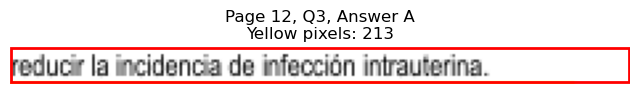

Page 12, Q3 - B: Detected box: x0=68.3, y0=266.1, x1=229.2, y1=278.7
Page 12, Q3, B: Yellow pixels: 2115
Page 12, Q3, B: Total non-white pixels: 2756
Page 12, Q3, B: Yellow percentage: 76.7%


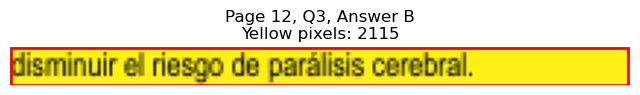

Page 12, Q3 - C: Detected box: x0=68.8, y0=278.8, x1=255.8, y1=291.5
Page 12, Q3, C: Yellow pixels: 212
Page 12, Q3, C: Total non-white pixels: 1103
Page 12, Q3, C: Yellow percentage: 19.2%


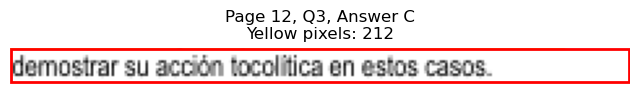

Page 12, Q3 - D: Detected box: x0=327.5, y0=253.5, x1=449.5, y1=266.1
Page 12, Q3, D: Yellow pixels: 0
Page 12, Q3, D: Total non-white pixels: 587
Page 12, Q3, D: Yellow percentage: 0.0%


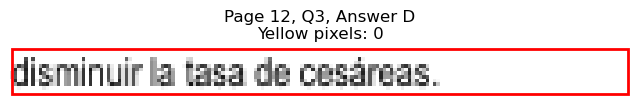

Page 12, Q3 - E: Detected box: x0=327.0, y0=266.1, x1=491.1, y1=278.7
Page 12, Q3, E: Yellow pixels: 0
Page 12, Q3, E: Total non-white pixels: 824
Page 12, Q3, E: Yellow percentage: 0.0%


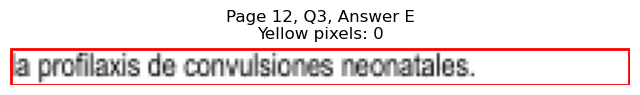


Page 12, Q3 - Selected Answer: B (based on yellow pixel count)




Page 12, Q4 - A: Detected box: x0=68.3, y0=329.2, x1=160.6, y1=341.9
Page 12, Q4, A: Yellow pixels: 1472
Page 12, Q4, A: Total non-white pixels: 1859
Page 12, Q4, A: Yellow percentage: 79.2%


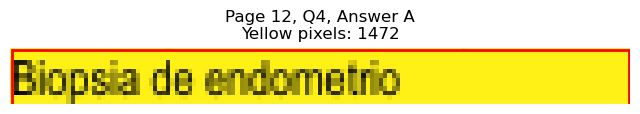

Page 12, Q4 - B: Detected box: x0=68.3, y0=341.9, x1=187.2, y1=354.6
Page 12, Q4, B: Yellow pixels: 168
Page 12, Q4, B: Total non-white pixels: 737
Page 12, Q4, B: Yellow percentage: 22.8%


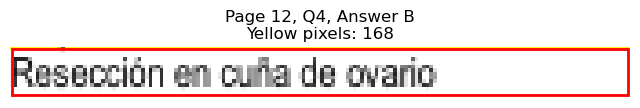

Page 12, Q4 - C: Detected box: x0=68.8, y0=354.5, x1=122.1, y1=367.2
Page 12, Q4, C: Yellow pixels: 0
Page 12, Q4, C: Total non-white pixels: 269
Page 12, Q4, C: Yellow percentage: 0.0%


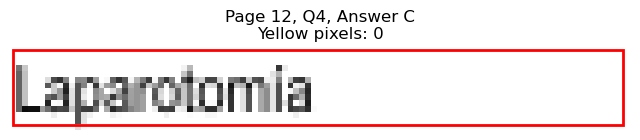

Page 12, Q4 - D: Detected box: x0=327.5, y0=329.2, x1=429.9, y1=341.9
Page 12, Q4, D: Yellow pixels: 0
Page 12, Q4, D: Total non-white pixels: 539
Page 12, Q4, D: Yellow percentage: 0.0%


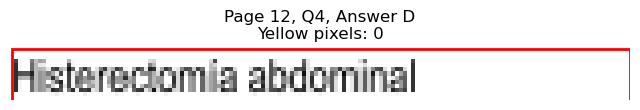

Page 12, Q4 - E: Detected box: x0=327.0, y0=341.9, x1=419.8, y1=354.6
Page 12, Q4, E: Yellow pixels: 0
Page 12, Q4, E: Total non-white pixels: 468
Page 12, Q4, E: Yellow percentage: 0.0%


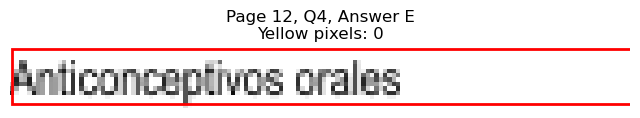


Page 12, Q4 - Selected Answer: A (based on yellow pixel count)




Page 12, Q5 - A: Detected box: x0=68.3, y0=404.9, x1=215.4, y1=417.6
Page 12, Q5, A: Yellow pixels: 0
Page 12, Q5, A: Total non-white pixels: 712
Page 12, Q5, A: Yellow percentage: 0.0%


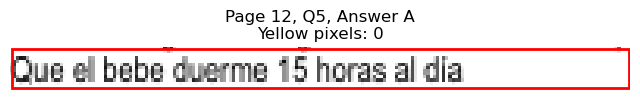

Page 12, Q5 - B: Detected box: x0=68.3, y0=417.6, x1=250.4, y1=430.3
Page 12, Q5, B: Yellow pixels: 213
Page 12, Q5, B: Total non-white pixels: 1070
Page 12, Q5, B: Yellow percentage: 19.9%


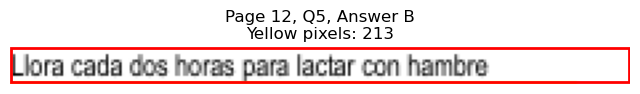

Page 12, Q5 - C: Detected box: x0=68.8, y0=430.2, x1=200.2, y1=442.9
Page 12, Q5, C: Yellow pixels: 1898
Page 12, Q5, C: Total non-white pixels: 2379
Page 12, Q5, C: Yellow percentage: 79.8%


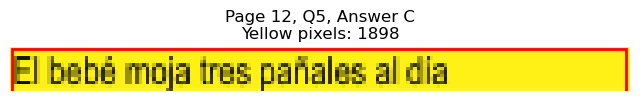

Page 12, Q5 - D: Detected box: x0=327.5, y0=404.9, x1=527.7, y1=417.6
Page 12, Q5, D: Yellow pixels: 0
Page 12, Q5, D: Total non-white pixels: 976
Page 12, Q5, D: Yellow percentage: 0.0%


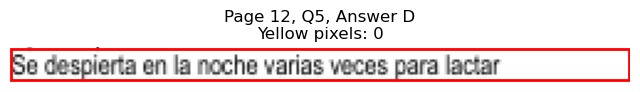

Page 12, Q5 - E: Detected box: x0=327.0, y0=417.6, x1=460.5, y1=430.3
Page 12, Q5, E: Yellow pixels: 0
Page 12, Q5, E: Total non-white pixels: 689
Page 12, Q5, E: Yellow percentage: 0.0%


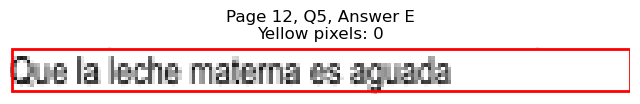


Page 12, Q5 - Selected Answer: C (based on yellow pixel count)




Page 12, Q6 - A: Detected box: x0=68.3, y0=493.4, x1=152.1, y1=506.0
Page 12, Q6, A: Yellow pixels: 135
Page 12, Q6, A: Total non-white pixels: 667
Page 12, Q6, A: Yellow percentage: 20.2%


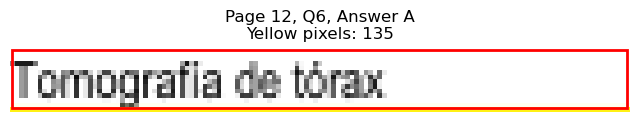

Page 12, Q6 - B: Detected box: x0=68.3, y0=506.0, x1=134.1, y1=518.6
Page 12, Q6, B: Yellow pixels: 1277
Page 12, Q6, B: Total non-white pixels: 1638
Page 12, Q6, B: Yellow percentage: 78.0%


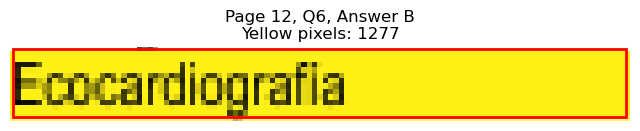

Page 12, Q6 - C: Detected box: x0=68.8, y0=518.6, x1=149.5, y1=531.2
Page 12, Q6, C: Yellow pixels: 130
Page 12, Q6, C: Total non-white pixels: 537
Page 12, Q6, C: Yellow percentage: 24.2%


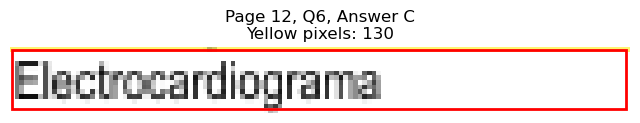

Page 12, Q6 - D: Detected box: x0=327.5, y0=493.4, x1=378.7, y1=506.0
Page 12, Q6, D: Yellow pixels: 0
Page 12, Q6, D: Total non-white pixels: 223
Page 12, Q6, D: Yellow percentage: 0.0%


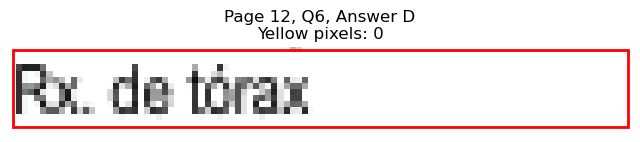

Page 12, Q6 - E: Detected box: x0=327.0, y0=506.0, x1=456.5, y1=518.6
Page 12, Q6, E: Yellow pixels: 0
Page 12, Q6, E: Total non-white pixels: 676
Page 12, Q6, E: Yellow percentage: 0.0%


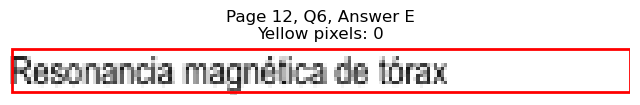


Page 12, Q6 - Selected Answer: B (based on yellow pixel count)




Page 12, Q7 - A: Detected box: x0=68.3, y0=581.7, x1=231.8, y1=594.4
Page 12, Q7, A: Yellow pixels: 0
Page 12, Q7, A: Total non-white pixels: 781
Page 12, Q7, A: Yellow percentage: 0.0%


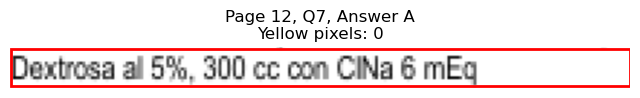

Page 12, Q7 - B: Detected box: x0=68.3, y0=594.3, x1=211.8, y1=607.0
Page 12, Q7, B: Yellow pixels: 0
Page 12, Q7, B: Total non-white pixels: 882
Page 12, Q7, B: Yellow percentage: 0.0%


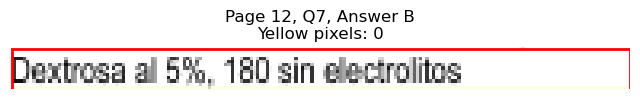

Page 12, Q7 - C: Detected box: x0=68.8, y0=606.9, x1=228.8, y1=619.6
Page 12, Q7, C: Yellow pixels: 2112
Page 12, Q7, C: Total non-white pixels: 2954
Page 12, Q7, C: Yellow percentage: 71.5%


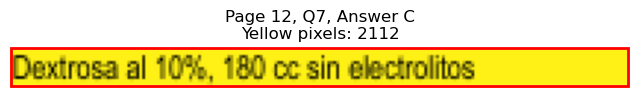

Page 12, Q7 - D: Detected box: x0=327.5, y0=581.7, x1=496.5, y1=594.4
Page 12, Q7, D: Yellow pixels: 0
Page 12, Q7, D: Total non-white pixels: 805
Page 12, Q7, D: Yellow percentage: 0.0%


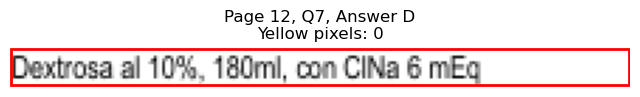

Page 12, Q7 - E: Detected box: x0=327.0, y0=594.3, x1=494.0, y1=607.0
Page 12, Q7, E: Yellow pixels: 0
Page 12, Q7, E: Total non-white pixels: 846
Page 12, Q7, E: Yellow percentage: 0.0%


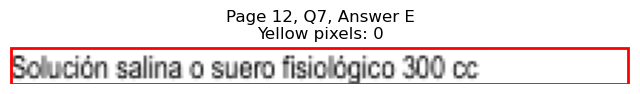


Page 12, Q7 - Selected Answer: C (based on yellow pixel count)




Page 12, Q8 - A: Detected box: x0=68.3, y0=682.7, x1=114.5, y1=695.3
Page 12, Q8, A: Yellow pixels: 969
Page 12, Q8, A: Total non-white pixels: 1358
Page 12, Q8, A: Yellow percentage: 71.4%


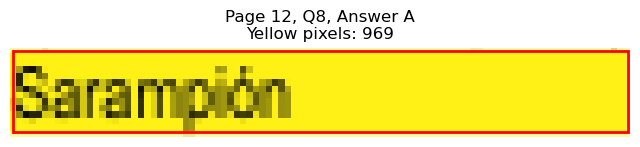

Page 12, Q8 - B: Detected box: x0=68.3, y0=695.4, x1=144.5, y1=708.0
Page 12, Q8, B: Yellow pixels: 1
Page 12, Q8, B: Total non-white pixels: 513
Page 12, Q8, B: Yellow percentage: 0.2%


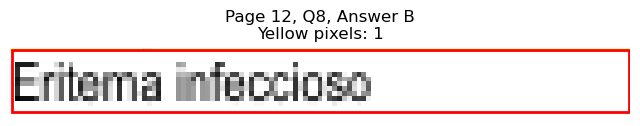

Page 12, Q8 - C: Detected box: x0=68.8, y0=708.0, x1=104.9, y1=720.6
Page 12, Q8, C: Yellow pixels: 0
Page 12, Q8, C: Total non-white pixels: 182
Page 12, Q8, C: Yellow percentage: 0.0%


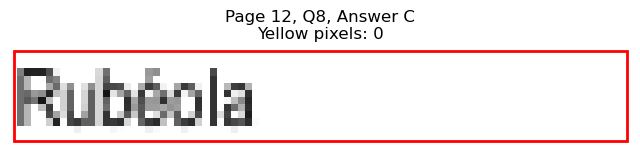

Page 12, Q8 - D: Detected box: x0=327.5, y0=682.7, x1=362.7, y1=695.3
Page 12, Q8, D: Yellow pixels: 0
Page 12, Q8, D: Total non-white pixels: 172
Page 12, Q8, D: Yellow percentage: 0.0%


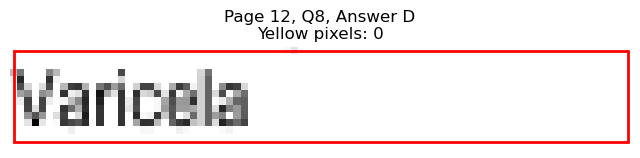

Page 12, Q8 - E: Detected box: x0=327.0, y0=695.4, x1=391.3, y1=708.0
Page 12, Q8, E: Yellow pixels: 0
Page 12, Q8, E: Total non-white pixels: 345
Page 12, Q8, E: Yellow percentage: 0.0%


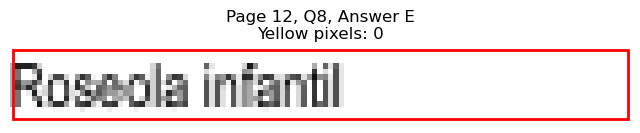


Page 12, Q8 - Selected Answer: A (based on yellow pixel count)





Page 13: Found 6 questions
Page 13, Q1 - A: Detected box: x0=68.3, y0=127.2, x1=144.5, y1=139.9
Page 13, Q1, A: Yellow pixels: 0
Page 13, Q1, A: Total non-white pixels: 380
Page 13, Q1, A: Yellow percentage: 0.0%


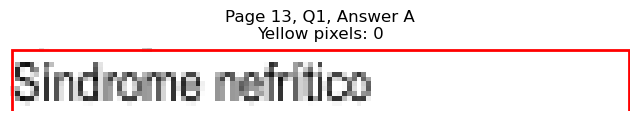

Page 13, Q1 - B: Detected box: x0=68.3, y0=139.9, x1=145.1, y1=152.6
Page 13, Q1, B: Yellow pixels: 1358
Page 13, Q1, B: Total non-white pixels: 1792
Page 13, Q1, B: Yellow percentage: 75.8%


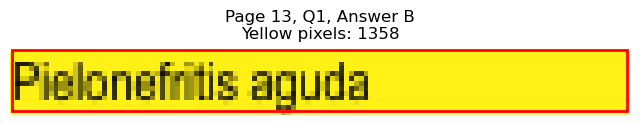

Page 13, Q1 - C: Detected box: x0=68.8, y0=152.5, x1=111.4, y1=165.2
Page 13, Q1, C: Yellow pixels: 92
Page 13, Q1, C: Total non-white pixels: 312
Page 13, Q1, C: Yellow percentage: 29.5%


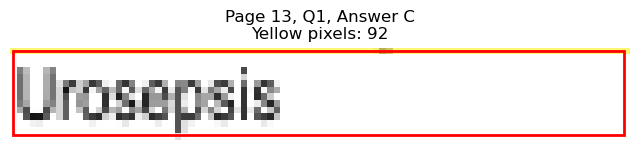

Page 13, Q1 - D: Detected box: x0=327.5, y0=127.2, x1=429.9, y1=139.9
Page 13, Q1, D: Yellow pixels: 0
Page 13, Q1, D: Total non-white pixels: 528
Page 13, Q1, D: Yellow percentage: 0.0%


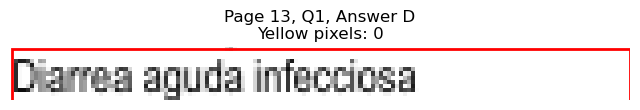

Page 13, Q1 - E: Detected box: x0=327.0, y0=139.9, x1=390.8, y1=152.6
Page 13, Q1, E: Yellow pixels: 0
Page 13, Q1, E: Total non-white pixels: 307
Page 13, Q1, E: Yellow percentage: 0.0%


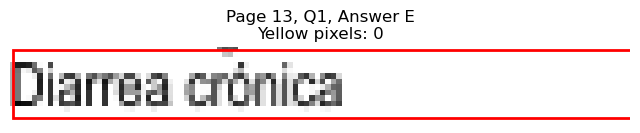


Page 13, Q1 - Selected Answer: B (based on yellow pixel count)




Page 13, Q2 - A: Detected box: x0=68.3, y0=202.9, x1=175.1, y1=215.6
Page 13, Q2, A: Yellow pixels: 1663
Page 13, Q2, A: Total non-white pixels: 2212
Page 13, Q2, A: Yellow percentage: 75.2%


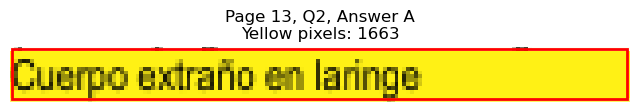

Page 13, Q2 - B: Detected box: x0=68.3, y0=215.7, x1=150.0, y1=228.3
Page 13, Q2, B: Yellow pixels: 131
Page 13, Q2, B: Total non-white pixels: 542
Page 13, Q2, B: Yellow percentage: 24.2%


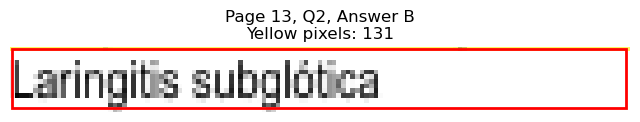

Page 13, Q2 - C: Detected box: x0=68.8, y0=228.3, x1=163.1, y1=240.9
Page 13, Q2, C: Yellow pixels: 0
Page 13, Q2, C: Total non-white pixels: 511
Page 13, Q2, C: Yellow percentage: 0.0%


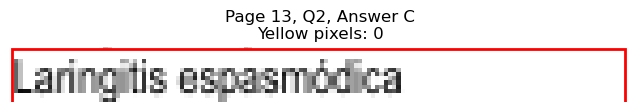

Page 13, Q2 - D: Detected box: x0=327.5, y0=202.9, x1=434.8, y1=215.6
Page 13, Q2, D: Yellow pixels: 0
Page 13, Q2, D: Total non-white pixels: 551
Page 13, Q2, D: Yellow percentage: 0.0%


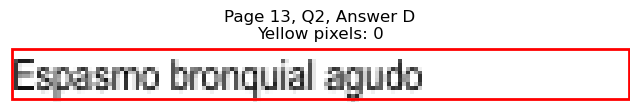

Page 13, Q2 - E: Detected box: x0=327.0, y0=215.7, x1=459.9, y1=228.3
Page 13, Q2, E: Yellow pixels: 0
Page 13, Q2, E: Total non-white pixels: 668
Page 13, Q2, E: Yellow percentage: 0.0%


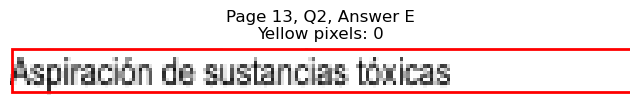


Page 13, Q2 - Selected Answer: A (based on yellow pixel count)




Page 13, Q3 - A: Detected box: x0=68.3, y0=278.8, x1=101.4, y1=291.5
Page 13, Q3, A: Yellow pixels: 0
Page 13, Q3, A: Total non-white pixels: 169
Page 13, Q3, A: Yellow percentage: 0.0%


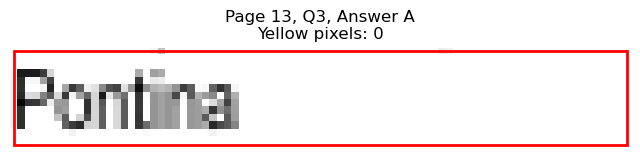

Page 13, Q3 - B: Detected box: x0=68.3, y0=291.4, x1=130.5, y1=304.1
Page 13, Q3, B: Yellow pixels: 113
Page 13, Q3, B: Total non-white pixels: 417
Page 13, Q3, B: Yellow percentage: 27.1%


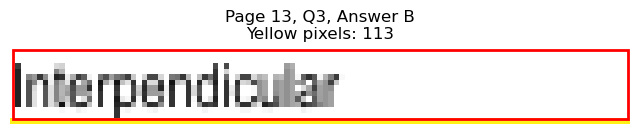

Page 13, Q3 - C: Detected box: x0=68.8, y0=304.0, x1=127.5, y1=316.7
Page 13, Q3, C: Yellow pixels: 1178
Page 13, Q3, C: Total non-white pixels: 1430
Page 13, Q3, C: Yellow percentage: 82.4%


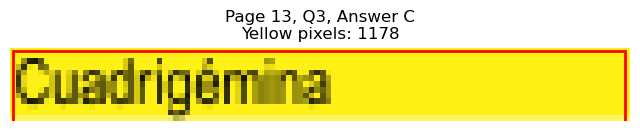

Page 13, Q3 - D: Detected box: x0=327.5, y0=278.8, x1=429.3, y1=291.5
Page 13, Q3, D: Yellow pixels: 0
Page 13, Q3, D: Total non-white pixels: 534
Page 13, Q3, D: Yellow percentage: 0.0%


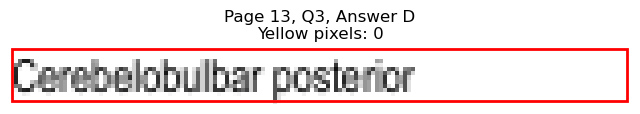

Page 13, Q3 - E: Detected box: x0=327.0, y0=291.4, x1=379.7, y1=304.1
Page 13, Q3, E: Yellow pixels: 0
Page 13, Q3, E: Total non-white pixels: 283
Page 13, Q3, E: Yellow percentage: 0.0%


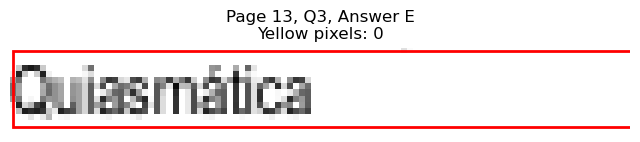


Page 13, Q3 - Selected Answer: C (based on yellow pixel count)




Page 13, Q4 - A: Detected box: x0=68.3, y0=379.7, x1=188.2, y1=392.4
Page 13, Q4, A: Yellow pixels: 1527
Page 13, Q4, A: Total non-white pixels: 2394
Page 13, Q4, A: Yellow percentage: 63.8%


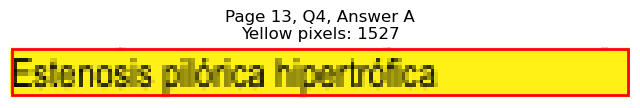

Page 13, Q4 - B: Detected box: x0=68.3, y0=392.3, x1=149.5, y1=405.0
Page 13, Q4, B: Yellow pixels: 0
Page 13, Q4, B: Total non-white pixels: 566
Page 13, Q4, B: Yellow percentage: 0.0%


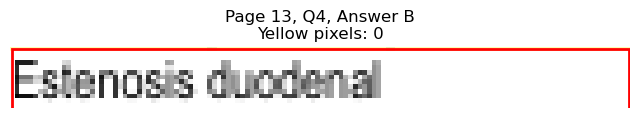

Page 13, Q4 - C: Detected box: x0=68.8, y0=404.9, x1=131.5, y1=417.6
Page 13, Q4, C: Yellow pixels: 0
Page 13, Q4, C: Total non-white pixels: 318
Page 13, Q4, C: Yellow percentage: 0.0%


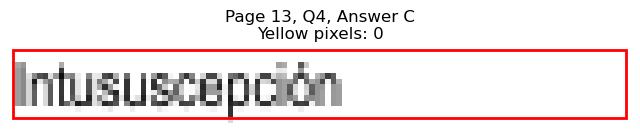

Page 13, Q4 - D: Detected box: x0=327.5, y0=379.7, x1=391.7, y1=392.4
Page 13, Q4, D: Yellow pixels: 0
Page 13, Q4, D: Total non-white pixels: 327
Page 13, Q4, D: Yellow percentage: 0.0%


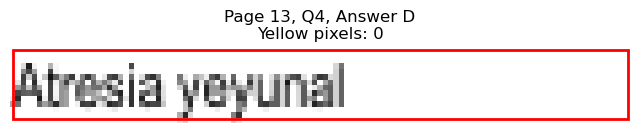

Page 13, Q4 - E: Detected box: x0=327.0, y0=392.3, x1=414.3, y1=405.0
Page 13, Q4, E: Yellow pixels: 0
Page 13, Q4, E: Total non-white pixels: 448
Page 13, Q4, E: Yellow percentage: 0.0%


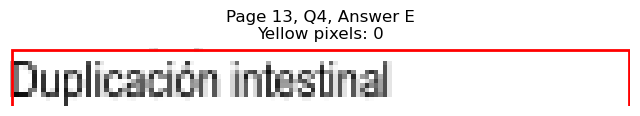


Page 13, Q4 - Selected Answer: A (based on yellow pixel count)




Page 13, Q5 - A: Detected box: x0=68.3, y0=468.1, x1=160.6, y1=480.7
Page 13, Q5, A: Yellow pixels: 0
Page 13, Q5, A: Total non-white pixels: 463
Page 13, Q5, A: Yellow percentage: 0.0%


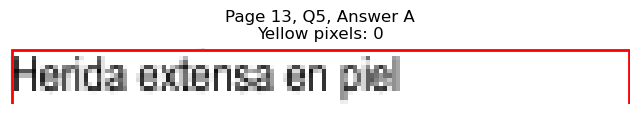

Page 13, Q5 - B: Detected box: x0=68.3, y0=480.8, x1=162.3, y1=493.4
Page 13, Q5, B: Yellow pixels: 145
Page 13, Q5, B: Total non-white pixels: 589
Page 13, Q5, B: Yellow percentage: 24.6%


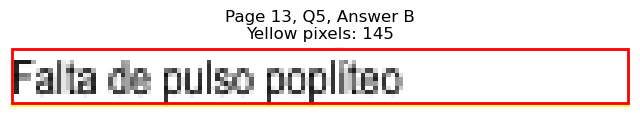

Page 13, Q5 - C: Detected box: x0=68.8, y0=493.4, x1=177.6, y1=506.0
Page 13, Q5, C: Yellow pixels: 1671
Page 13, Q5, C: Total non-white pixels: 2085
Page 13, Q5, C: Yellow percentage: 80.1%


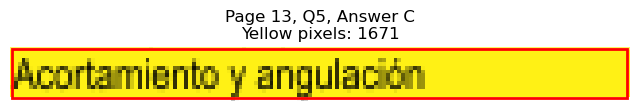

Page 13, Q5 - D: Detected box: x0=327.5, y0=468.1, x1=469.4, y1=480.7
Page 13, Q5, D: Yellow pixels: 0
Page 13, Q5, D: Total non-white pixels: 701
Page 13, Q5, D: Yellow percentage: 0.0%


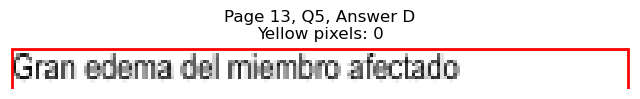

Page 13, Q5 - E: Detected box: x0=327.0, y0=480.8, x1=398.3, y1=493.4
Page 13, Q5, E: Yellow pixels: 0
Page 13, Q5, E: Total non-white pixels: 381
Page 13, Q5, E: Yellow percentage: 0.0%


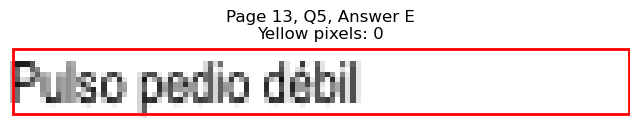


Page 13, Q5 - Selected Answer: C (based on yellow pixel count)




Page 13, Q6 - A: Detected box: x0=68.3, y0=531.2, x1=102.4, y1=543.8
Page 13, Q6, A: Yellow pixels: 0
Page 13, Q6, A: Total non-white pixels: 177
Page 13, Q6, A: Yellow percentage: 0.0%


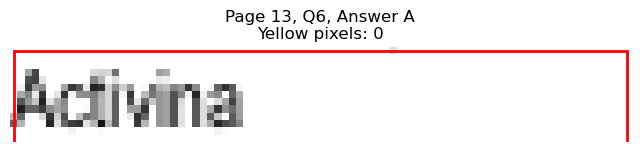

Page 13, Q6 - B: Detected box: x0=68.3, y0=543.8, x1=124.9, y1=556.4
Page 13, Q6, B: Yellow pixels: 0
Page 13, Q6, B: Total non-white pixels: 294
Page 13, Q6, B: Yellow percentage: 0.0%


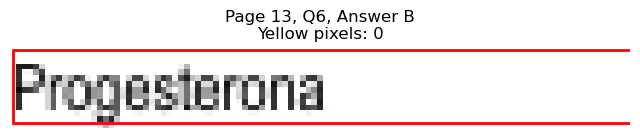

Page 13, Q6 - C: Detected box: x0=68.8, y0=556.5, x1=106.3, y1=569.2
Page 13, Q6, C: Yellow pixels: 992
Page 13, Q6, C: Total non-white pixels: 1246
Page 13, Q6, C: Yellow percentage: 79.6%


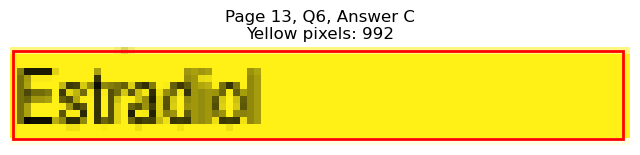

Page 13, Q6 - D: Detected box: x0=327.5, y0=531.2, x1=365.1, y1=543.8
Page 13, Q6, D: Yellow pixels: 0
Page 13, Q6, D: Total non-white pixels: 200
Page 13, Q6, D: Yellow percentage: 0.0%


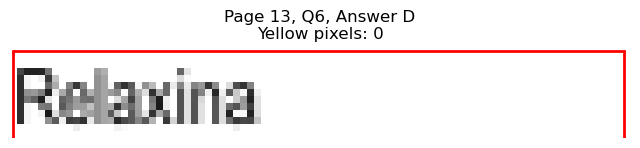

Page 13, Q6 - E: Detected box: x0=327.0, y0=543.8, x1=364.7, y1=556.4
Page 13, Q6, E: Yellow pixels: 0
Page 13, Q6, E: Total non-white pixels: 210
Page 13, Q6, E: Yellow percentage: 0.0%


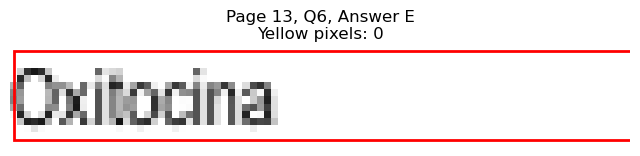


Page 13, Q6 - Selected Answer: C (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Lactante de 10 meses, es traído a emergencia p...
1   Mujer de 30 años, intervenida de hernioplastia...
2   Niña de 3 años, con prurito intenso en cuero c...
3   ¿Con qué agente etiológico está relacionada la...
4   En un paciente con diagnóstico de Síndrome de ...
..                                                ...
95  Niño de 7 años, sin antecedente previo, súbita...
96  En relación a las cisternas subaracnoideas. ¿A...
97  RN varón, presenta vómitos no biliosos “en pro...
98  Varón de 25 años, politraumatizado, se queja d...
99  ¿Qué hormona promueve el desarrollo del sistem...

[100 rows x 1 columns]

In [8]:
answers_df

option_A                 option_B  \
0                  Síndrome de West               Mioclonías   
1            Depresión respiratoria       Schok anafiláctico   
2                  Malation al 0,5%               Tacrolimus   
3      Infecciones por estafilococo                Radiación   
4         Membrana basal glomerular      Conductos papilares   
..                              ...                      ...   
95        Cuerpo extraño en laringe    Laringitis subglótica   
96                          Pontina          Interpendicular   
97  Estenosis pilórica hipertrófica       Estenosis duodenal   
98           Herida extensa en piel  Falta de pulso poplíteo   
99                         Activina             Progesterona   

                      option_C                         option_D  \
0   Convulsión febril compleja         Convulsión febril simple   
1        Desgarro de duramadre                   Reacción vagal   
2                  Ivermectina                   Lindano loción   
3               Histoplasmosis                    Equinococosis   
4           Túbulos conectores  Conductos colectores corticales   
..                         ...                              ...   
95      Laringitis espasmódica          Espasmo bronquial agudo   
96                Cuadrigémina         Cerebelobulbar posterior   
97              Intususcepción                  Atresia yeyunal   
98   Acortamiento y angulación  Gran edema del miembro afectado   
99                   Estradiol                         Relaxina   

                                   option_E  
0                                 Epilepsia  
1          Síndrome de la "cola de caballo"  
2                                  Vaselina  
3                   Virus de la parotiditis  
4   Endotelio de los capilares glomerulares  
..                                      ...  
95         Aspiración de sustancias tóxicas  
96                              Quiasmática  
97                   Duplicación intestinal  
98                        Pulso pedio débil  
99                                Oxitocina  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               C
1               C
2               C
3               E
4               A
..            ...
95              A
96              C
97              A
98              C
99              C

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   Lactante de 10 meses, es traído a emergencia p...   
1   Mujer de 30 años, intervenida de hernioplastia...   
2   Niña de 3 años, con prurito intenso en cuero c...   
3   ¿Con qué agente etiológico está relacionada la...   
4   En un paciente con diagnóstico de Síndrome de ...   
..                                                ...   
95  Niño de 7 años, sin antecedente previo, súbita...   
96  En relación a las cisternas subaracnoideas. ¿A...   
97  RN varón, presenta vómitos no biliosos “en pro...   
98  Varón de 25 años, politraumatizado, se queja d...   
99  ¿Qué hormona promueve el desarrollo del sistem...   

                           option_A                 option_B  \
0                  Síndrome de West               Mioclonías   
1            Depresión respiratoria       Schok anafiláctico   
2                  Malation al 0,5%               Tacrolimus   
3      Infecciones por estafilococo                Radiación   
4         Membrana basal glomerular      Conductos papilares   
..                              ...                      ...   
95        Cuerpo extraño en laringe    Laringitis subglótica   
96                          Pontina          Interpendicular   
97  Estenosis pilórica hipertrófica       Estenosis duodenal   
98           Herida extensa en piel  Falta de pulso poplíteo   
99                         Activina             Progesterona   

                      option_C                         option_D  \
0   Convulsión febril compleja         Convulsión febril simple   
1        Desgarro de duramadre                   Reacción vagal   
2                  Ivermectina                   Lindano loción   
3               Histoplasmosis                    Equinococosis   
4           Túbulos conectores  Conductos colectores corticales   
..                         ...                              ...   
95      Laringitis espasmódica          Espasmo bronquial agudo   
96                Cuadrigémina         Cerebelobulbar posterior   
97              Intususcepción                  Atresia yeyunal   
98   Acortamiento y angulación  Gran edema del miembro afectado   
99                   Estradiol                         Relaxina   

                                   option_E correct_answer  
0                                 Epilepsia              C  
1          Síndrome de la "cola de caballo"              C  
2                                  Vaselina              C  
3                   Virus de la parotiditis              E  
4   Endotelio de los capilares glomerulares              A  
..                                      ...            ...  
95         Aspiración de sustancias tóxicas              A  
96                              Quiasmática              C  
97                   Duplicación intestinal              A  
98                        Pulso pedio débil              C  
99                                Oxitocina              C  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2022/Especialidad Prueba A.csv
